# Introduction
The project below investigates 2019 Trends in International Math and Science Study (TIMSS) Data for 8th graders.

_Source: [2019 TIMSS Database](https://timss2019.org/international-database/)_

### [Summary Article on Medium](https://sjhaluck.medium.com/timss-2019-a-data-science-study-c8a779d6cc7b)

<div id='top'></div>

# Table of Contents
* [Business Understanding](#business_understanding)
* [Data Understanding](#data_understanding)
* [Data Preparation](#data_preparation)
* [Data Modeling](#data_modeling)
* [Appendix: Supplementary Data Visualization](#appendix)

<div id='business_understanding'></div>

# Business Understanding

### Questions of Interest
1. How does a student's environment at home, in the classroom, and at school affect academic understanding?
2. Are there specific teacher behaviors that lead to improved understanding in specific disciplines?
3. What can students and teachers do to improve student academic understanding?

The project will cover a variety of analyses regarding vast data collected. The project will include:
* prediction of student score based on student attitudes and demographics, school characteristics
* prediction of student scores based on teacher attitudes and practices
* recommendation engine for additional study problems for a given student (or group of students from a school or country)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import re
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.metrics import confusion_matrix
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [2]:
# import the country codes into a dataframe
country_codes = pd.read_csv('data/country_codes.csv').dropna()
# rename the columns to be consistent with TIMSS information
country_codes.rename(columns = {'ID':'IDCNTRY'}, inplace=True)
# convert IDCNTRY to integers
country_codes['IDCNTRY'] = country_codes['IDCNTRY'].astype(int)
# demonstrate country code information
country_codes

Country  IDCNTRY
0                   Australia       36
1                     Bahrain       48
2                       Chile      152
3              Chinese Taipei      158
4                      Cyprus      196
5                       Egypt      818
6                     England      926
7                     Finland      246
8                      France      250
9                     Georgia      268
10              Hong Kong SAR      344
11                    Hungary      348
12      Iran, Islamic Rep. of      364
13                    Ireland      372
14                     Israel      376
15                      Italy      380
16                      Japan      392
17                     Jordan      400
18                 Kazakhstan      398
19             Korea, Rep. of      410
20                     Kuwait      414
21                    Lebanon      422
22                  Lithuania      440
23                   Malaysia      458
24                    Morocco      504
25                New Zealand      554
26                     Norway      578
27                       Oman      512
28                   Portugal      620
29                      Qatar      634
30                    Romania      642
31         Russian Federation      643
32               Saudi Arabia      682
33                  Singapore      702
34               South Africa      710
35                     Sweden      752
36                     Turkey      792
37       United Arab Emirates      784
38              United States      840
39            Ontario, Canada     9132
40             Quebec, Canada     9133
41  Moscow City, Russian Fed.   643001
42             Abu Dhabi, UAE     7842
43                 Dubai, UAE     7841

<div id='data_understanding'></div>

[Return to Top](#top)

# Data Understanding

### Load Data
Import the 2019 TIMSS Data into six separate dataframes

In [3]:
# gather the metadata (column names) for the student assessment data
meta = pyreadstat.read_sav('T19_G8_SPSS Data/bsachlm7.sav', metadataonly=True)
# select a subset of the columns for analysis
stud_ach_cols = meta[0].columns[:1265]

In [4]:
# initialize variables for reading in the TIMSS data
school = 0
stud_ach = 0
student = 0
stud_teach = 0
math_teach = 0
sci_teach = 0

# loop through each SPSS file
for file in glob.glob('T19_G8_SPSS Data/*.sav'):
    # print the file name to monitor progress
    print(file)
    # if file name contains "bcg" then it is a file with school level information
    if re.search('bcg',file) != None:
        # identify the subset of columns necessary for school level analysis
        school_cols = ['IDCNTRY','IDSCHOOL','IDPOP','ITLANG_C','LCID_C','BCBGDAS','BCBGEAS','BCBGMRS','BCBGSRS','BCDGDAS','BCDGEAS',
                       'BCDGMRS','BCDGSRS','BCDGSBC','BCDGTIHY']
        try:
            # append the new file onto the existing school level data (if exists)
            school = school.append(pd.read_spss(file, usecols=school_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the school level data
            school = pd.read_spss(file, usecols=school_cols)
    # if file name contains "bsa" then it is a file with student achievement level information
    elif re.search('bsa',file) != None:
        try:
            # append the new file onto the existing student achievement level data (if exists)
            stud_ach = stud_ach.append(pd.read_spss(file, usecols=stud_ach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student achievement level data
            stud_ach = pd.read_spss(file, usecols=stud_ach_cols)
    # if file name contains "bsg" then it is a file with student level information
    elif re.search('bsg',file) != None:
        # identify the subset of columns necessary for student level analysis
        student_cols = ['IDCNTRY','IDBOOK','IDSCHOOL','IDCLASS','IDSTUD','BSBG01','BSBG03','BSBG04','BSBG05A','BSBG05B',
                        'BSBG05C','BSBG05D','BSBG05E','BSBG05F','BSBG05G','BSBG05H','BSBG05I','BSBG06A','BSBG06B','BSBG07',
                        'BSBG08A','BSBG08B','BSBG09A','BSBG09B','BSBG10','BSBG11A','BSBG11B','BSBG12A','BSBG12B','BSBG12C',
                        'BSBG12D','BSBG12E','BSBG12F','IDPOP','ITLANG_SQ','LCID_SQ','ITLANG_SA','LCID_SA','ITSEX','BSDAGE',
                        'BSBGHER','BSDGHER','BSBGSSB','BSDGSSB','BSBGSB','BSDGSB','BSBGSLM','BSDGSLM','BSBGICM','BSDGICM',
                        'BSBGDML','BSDGDML','BSBGSCM','BSDGSCM','BSBGSVM','BSDGSVM','BSBGSLS','BSDGSLS','BSBGICS','BSDGICS',
                        'BSBGSCS','BSDGSCS','BSBGSVS','BSDGSVS','BSBGSLB','BSDGSLB','BSBGICB','BSDGICB','BSBGSCB','BSDGSCB',
                        'BSBGSLE','BSDGSLE','BSBGICE','BSDGICE','BSBGSCE','BSDGSCE','BSBGSLC','BSDGSLC','BSBGICC','BSDGICC',
                        'BSBGSCC','BSDGSCC','BSBGSLP','BSDGSLP','BSBGICP','BSDGICP','BSBGSCP','BSDGSCP','BSBGSEC','BSDGSEC',
                        'BSDG05S','BSDGEDUP']
        try:
            # append the new file onto the existing student level data (if exists)
            student = student.append(pd.read_spss(file, usecols=student_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student level data
            student = pd.read_spss(file, usecols=student_cols)
    # if file name contains "bst" then it is a file with student-teacher level information
    elif re.search('bst',file) != None:
        try:
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDSUBJ',
                               'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # append the new file onto the existing student-teacher level data (if exists)
            stud_teach = stud_teach.append(pd.read_spss(file, usecols=stud_teach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student-teacher level data
            stud_teach = pd.read_spss(file)
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDSUBJ',
                               'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # select the appropriate columns from the available data
            stud_teach = stud_teach.loc[:,stud_teach_cols]
    # if file name contains "btm" then it is a file with math teacher level information
    elif re.search('btm',file) != None:
        try:
            # append the new file onto the existing math teacher level data (if exists)
            math_teach = math_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the math teacher level data
            math_teach = pd.read_spss(file)
    # if file name contains "bts" then it is a file with science teacher level information
    elif re.search('bts',file) != None:
        try:
            # append the new file onto the existing science teacher level data (if exists)
            sci_teach = sci_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the science teacher level data
            sci_teach = pd.read_spss(file)

T19_G8_SPSS Data\bcgchlm7.sav
T19_G8_SPSS Data\bcgengm7.sav
T19_G8_SPSS Data\bcgfram7.sav
T19_G8_SPSS Data\bcggeom7.sav
T19_G8_SPSS Data\bcgisrm7.sav
T19_G8_SPSS Data\bcgitam7.sav
T19_G8_SPSS Data\bcgjpnm7.sav
T19_G8_SPSS Data\bcgltum7.sav
T19_G8_SPSS Data\bcgprtm7.sav
T19_G8_SPSS Data\bcgturm7.sav
T19_G8_SPSS Data\bsachlm7.sav
T19_G8_SPSS Data\bsaengm7.sav
T19_G8_SPSS Data\bsafram7.sav
T19_G8_SPSS Data\bsageom7.sav
T19_G8_SPSS Data\bsaisrm7.sav
T19_G8_SPSS Data\bsaitam7.sav
T19_G8_SPSS Data\bsajpnm7.sav
T19_G8_SPSS Data\bsaltum7.sav
T19_G8_SPSS Data\bsaprtm7.sav
T19_G8_SPSS Data\bsaturm7.sav
T19_G8_SPSS Data\bsgchlm7.sav
T19_G8_SPSS Data\bsgengm7.sav
T19_G8_SPSS Data\bsgfram7.sav
T19_G8_SPSS Data\bsggeom7.sav
T19_G8_SPSS Data\bsgisrm7.sav
T19_G8_SPSS Data\bsgitam7.sav
T19_G8_SPSS Data\bsgjpnm7.sav
T19_G8_SPSS Data\bsgltum7.sav
T19_G8_SPSS Data\bsgprtm7.sav
T19_G8_SPSS Data\bsgturm7.sav
T19_G8_SPSS Data\bsrchlm7.sav
T19_G8_SPSS Data\bsrengm7.sav
T19_G8_SPSS Data\bsrfram7.sav
T19_G8_SPS

In [5]:
# column prefixes to drop from math teacher data
math_teach_drop_cols = ['BTBM18','BTBM22','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in math_teach_drop_cols:
    drop_cols = [col for col in math_teach.columns if drop_head in col]
# drop all matching columns
math_teach.drop(columns=drop_cols,inplace=True)

In [6]:
# column prefixes to drop from science teacher data
sci_teach_drop_cols = ['BTBS17','BTBS21','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in sci_teach_drop_cols:
    drop_cols = [col for col in sci_teach.columns if drop_head in col]
# drop all matching columns
sci_teach.drop(columns=drop_cols,inplace=True)

In [7]:
# identify the file containing all of the code interpretations
file_name = 'T19_G8_Codebooks/T19_G8_Codebook.xlsx'
# store all codes into respectively named _codes dataframes
school_codes = pd.read_excel(file_name, sheet_name='BCGM7').set_index('Variable').iloc[:,:1]
stud_ach_codes = pd.read_excel(file_name, sheet_name='BSAM7').set_index('Variable').iloc[:,:1]
student_codes = pd.read_excel(file_name, sheet_name='BSGM7').set_index('Variable').iloc[:,:1]
stud_teach_codes = pd.read_excel(file_name, sheet_name='BSTM7').set_index('Variable').iloc[:,:1]
math_teach_codes = pd.read_excel(file_name, sheet_name='BTMM7').set_index('Variable').iloc[:,:1]
sci_teach_codes = pd.read_excel(file_name, sheet_name='BTSM7').set_index('Variable').iloc[:,:1]

In [8]:
# confirm codes were correctly stored
stud_teach_codes.head()

Label
Variable                               
IDCNTRY   Country ID - Numeric ISO Code
IDBOOK             Student Test Booklet
IDSCHOOL                      School ID
IDCLASS                        Class ID
IDSTUD                       Student ID

### Preprocessing Data
Preprocess the data to remove non-relevant information and variables

In [9]:
def binary_scores(answer): 
    '''
    converts each assessment item response into a binary number
    
    INPUT:
    answer - (str) the answer to the assessment item
                CORRECT RESPONSE, INCORRECT RESPONSE or a multiple choice response (* denotes correct answer)
          
    OUTPUT:
    a binary score for where:
            1 - correct response
            0 - incorrect response
    '''
    # keep NaN responses as NaN
    try: 
        float(answer)
        return np.nan
    except:
        # if response is correct, return 1
        if '*' in answer or ('CORRECT' in answer and 'INCORRECT' not in answer):
            return 1
        # otherwise, if the response is incorrect, return 0
        elif '*' not in answer or ('INCORRECT' in answer):
            return 0
        # in any other situation, return NaN
        else:
            return np.nan

In [10]:
def nanor(t):
    '''
    identifies if any correct answers are in the list
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - correct response found
            0 - no correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for any correct responses, 0 for no correct responses
    else:
        return int(any(t))
    
def nanand(t):
    '''
    identifies if all answers in the list are correct
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - all correct responses found
            0 - not all correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for all correct responses, 0 for not all correct responses
    else:
        return int(all(t))

In [11]:
# combine results from paper and electronic assessments to avoid redundant and ambiguous assessment comparisons

# create a list of all assessment columns from paper assessments (marked with a P) and that have not already been reduced to a single column
paper_cols_all = [col1 for col1 in list(stud_ach.columns) if (col1[1] == 'P' and col1[-4:] != '_val')]

# go through each columns
for col1 in paper_cols_all:
    # find all paper assessment columns that match the current column
    paper_cols = [str(col2) for col2 in list(stud_ach.columns) if (col1[:7] in col2 and col2[-4:] != '_val')]
    # find all electronic assessment columns that match the current column
    elec_cols = [col3 for col3 in list(stud_ach.columns) if (col1[2:7] in col3 and col1[0] == col3[0] and col3[1] == 'E')]
    # print the current columns being combined to monitor progress
    print(col1, paper_cols + elec_cols)
    # go through each of the matching paper or electronic assessment columns
    for col in paper_cols+elec_cols:
        # convert all answers to binary correct/incorrect values
        stud_ach[col] = stud_ach[col].apply(binary_scores)
    # if there are columns to be combined
    if len(paper_cols) > 0:
        # only count it as correct with all assessments were answered correctly (TIMSS assessment criteria)
        # store the result in the first of the matching columns
        stud_ach[paper_cols[0]] = stud_ach.loc[:,paper_cols].apply(nanand, axis=1)
        stud_ach[elec_cols[0]] = stud_ach.loc[:,elec_cols].apply(nanand, axis=1)
        # take the final results and combine the paper and electronic results into one column (marked with _val)
        stud_ach[col1[:7]+'_val'] = stud_ach.loc[:,[paper_cols[0],elec_cols[0]]].apply(nanor, axis=1)
        # drop previous paper and electronic assessment data to simplify the data set
        stud_ach.drop(columns=paper_cols+elec_cols, inplace=True)

MP52024 ['MP52024', 'ME52024']
MP52058A ['MP52058A', 'MP52058B', 'ME52058A', 'ME52058B']
MP52058B []
MP52125 ['MP52125', 'ME52125']
MP52229 ['MP52229', 'ME52229']
MP52063 ['MP52063', 'ME52063']
MP52072 ['MP52072', 'ME52072']
MP52146A ['MP52146A', 'MP52146B', 'ME52146A', 'ME52146B']
MP52146B []
MP52092 ['MP52092', 'ME52092']
MP52046 ['MP52046', 'ME52046']
MP52083 ['MP52083', 'ME52083']
MP52082 ['MP52082', 'ME52082']
MP52161 ['MP52161', 'ME52161']
MP52418A ['MP52418A', 'MP52418B', 'ME52418A', 'ME52418B']
MP52418B []
MP72007A ['MP72007A', 'MP72007B', 'MP72007C', 'MP72007D', 'MP72007E', 'MP72007', 'ME72007A', 'ME72007B', 'ME72007C', 'ME72007D', 'ME72007E', 'ME72007']
MP72007B []
MP72007C []
MP72007D []
MP72007E []
MP72007 []
MP72025 ['MP72025', 'ME72025']
MP72017 ['MP72017', 'ME72017']
MP72190 ['MP72190', 'ME72190']
MP72068 ['MP72068', 'ME72068']
MP72076 ['MP72076', 'ME72076']
MP72056 ['MP72056', 'ME72056']
MP72098 ['MP72098', 'ME72098']
MP72103 ['MP72103', 'ME72103']
MP72121 ['MP72121', '

In [12]:
# create a list of all math and science assessments
scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']

# go through each math and science score category
for item in scores:
    # find all assessments of that category (TIMSS offers 5 estimate of each category per student)
    sub_col = [col for col in stud_ach.columns if item in col]
    # print the columns to show progress
    print(sub_col)
    # find the average assessment of the category from all estimates
    stud_ach[item.lower()+'_avg'] = stud_ach.loc[:,sub_col].mean(axis=1)
    stud_teach[item.lower()+'_avg'] = stud_teach.loc[:,sub_col].mean(axis=1)
    # find the standard deviation of the estimates for that category
    stud_ach[item.lower()+'_sd'] = stud_ach.loc[:,sub_col].std(axis=1)
    # drop the previous five estimates to simplify to the average value
    stud_ach.drop(sub_col, axis = 1, inplace=True)
    stud_teach.drop(sub_col, axis = 1, inplace=True)

['BSMMAT01', 'BSMMAT02', 'BSMMAT03', 'BSMMAT04', 'BSMMAT05']
['BSSSCI01', 'BSSSCI02', 'BSSSCI03', 'BSSSCI04', 'BSSSCI05']
['BSMALG01', 'BSMALG02', 'BSMALG03', 'BSMALG04', 'BSMALG05']
['BSMAPP01', 'BSMAPP02', 'BSMAPP03', 'BSMAPP04', 'BSMAPP05']
['BSMDAT01', 'BSMDAT02', 'BSMDAT03', 'BSMDAT04', 'BSMDAT05']
['BSMGEO01', 'BSMGEO02', 'BSMGEO03', 'BSMGEO04', 'BSMGEO05']
['BSMKNO01', 'BSMKNO02', 'BSMKNO03', 'BSMKNO04', 'BSMKNO05']
['BSMNUM01', 'BSMNUM02', 'BSMNUM03', 'BSMNUM04', 'BSMNUM05']
['BSMREA01', 'BSMREA02', 'BSMREA03', 'BSMREA04', 'BSMREA05']
['BSSAPP01', 'BSSAPP02', 'BSSAPP03', 'BSSAPP04', 'BSSAPP05']
['BSSBIO01', 'BSSBIO02', 'BSSBIO03', 'BSSBIO04', 'BSSBIO05']
['BSSCHE01', 'BSSCHE02', 'BSSCHE03', 'BSSCHE04', 'BSSCHE05']
['BSSEAR01', 'BSSEAR02', 'BSSEAR03', 'BSSEAR04', 'BSSEAR05']
['BSSKNO01', 'BSSKNO02', 'BSSKNO03', 'BSSKNO04', 'BSSKNO05']
['BSSPHY01', 'BSSPHY02', 'BSSPHY03', 'BSSPHY04', 'BSSPHY05']
['BSSREA01', 'BSSREA02', 'BSSREA03', 'BSSREA04', 'BSSREA05']


In [13]:
# drop all weight and jackknife columns that are not relevant to the analysis
stud_ach.drop(columns=[col for col in stud_ach.columns if 'WGT' in col or 'JK' in col], inplace=True)

In [14]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

In [15]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (16,65,67,69,71,73,75,77,79,81,83,85,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Explore Data
Explore the structure and values of the data

In [16]:
# explore the school dataframe
school.head()

IDCNTRY  IDSCHOOL  IDPOP ITLANG_C           LCID_C   BCBGDAS   BCBGEAS  \
0    152.0    5001.0  Pop 2  Spanish  Spanish (Chile)  12.80218  15.09677   
1    152.0    5002.0  Pop 2  Spanish  Spanish (Chile)  12.80218  10.76309   
2    152.0    5004.0  Pop 2  Spanish  Spanish (Chile)  14.02858   9.85898   
3    152.0    5005.0  Pop 2  Spanish  Spanish (Chile)  12.80218   7.73586   
4    152.0    5007.0  Pop 2  Spanish  Spanish (Chile)  10.80136   9.26475   

   BCBGMRS  BCBGSRS              BCDGDAS             BCDGEAS         BCDGMRS  \
0  4.23486  4.07624  Hardly Any Problems  Very High Emphasis  Affected A Lot   
1  9.84801  9.69082  Hardly Any Problems       High Emphasis        Affected   
2  9.41874  9.36128  Hardly Any Problems       High Emphasis        Affected   
3  8.44578  8.01668  Hardly Any Problems     Medium Emphasis        Affected   
4  8.18097  8.44672  Hardly Any Problems     Medium Emphasis        Affected   

          BCDGSRS                                       BCDGSBC  BCDGTIHY  
0  Affected A Lot  Neither More Affluent nor More Disadvantaged    1600.0  
1        Affected  Neither More Affluent nor More Disadvantaged    1770.0  
2        Affected                            More Disadvantaged    1200.0  
3        Affected  Neither More Affluent nor More Disadvantaged    1068.0  
4        Affected                            More Disadvantaged    1638.0

In [17]:
# inspect all TIMSS participating countries
school['IDCNTRY'].astype(int).unique()

array([152, 926, 250, 268, 376, 380, 392, 440, 620, 792])

In [18]:
# list all participating countries (excluding benchmarking countries - codes >= 1000)
country_codes.set_index('IDCNTRY').loc[list(filter(lambda x: x<1000,list(school['IDCNTRY'].astype(int).unique()))),'Country']

IDCNTRY
152        Chile
926      England
250       France
268      Georgia
376       Israel
380        Italy
392        Japan
440    Lithuania
620     Portugal
792       Turkey
Name: Country, dtype: object

In [19]:
# make a list to drop all columns that are empty or only contain one unqiue value
school_drop_new = list(school.columns[school.isna().all()])+list(school.columns[school.nunique()==1])

In [380]:
# display summary information for school dataframe
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IDCNTRY              1583 non-null   object 
 1   IDSCHOOL             1583 non-null   int64  
 2   language             1515 non-null   object 
 3   disc_prob_score      1487 non-null   float64
 4   acad_emph_score      1488 non-null   float64
 5   math_shortage_score  1492 non-null   float64
 6   sci_shortage_score   1492 non-null   float64
 7   acad_hours           1387 non-null   float64
 8   disc_prob            1487 non-null   object 
 9   acad_emph            1488 non-null   object 
 10  math_shortage        1492 non-null   object 
 11  sci_shortage         1492 non-null   object 
 12  socio_background     1453 non-null   object 
 13  mmat_avg             1583 non-null   float64
 14  ssci_avg             1583 non-null   float64
 15  malg_avg             1583 non-null   f

Empty DataFrame
Columns: []
Index: []

In [21]:
# display descriptive statistics for school dataframe
school.describe()

IDCNTRY     IDSCHOOL      BCBGDAS      BCBGEAS      BCBGMRS  \
count  1583.000000  1583.000000  1487.000000  1488.000000  1492.000000   
mean    459.502211  5098.215414    10.343708     9.794793    10.171014   
std     230.220232    60.610691     1.852576     1.839962     1.569868   
min     152.000000  5001.000000     4.100070     3.554470     4.234860   
25%     268.000000  5047.000000     9.253000     8.673410     9.316210   
50%     392.000000  5095.000000    10.439390     9.560540    10.086290   
75%     620.000000  5142.000000    11.628840    11.062740    11.037080   
max     926.000000  5266.000000    14.028580    16.362220    14.255960   

           BCBGSRS     BCDGTIHY  
count  1492.000000  1387.000000  
mean     10.226800  1040.671089  
std       1.670421   231.681333  
min       4.076240   533.333330  
25%       9.361280   892.500000  
50%      10.176560   996.000000  
75%      10.973290  1133.166665  
max      14.572410  2500.000000

In [22]:
# display context/label information for the school variables
school_codes.loc[school.columns,:]

Label
IDCNTRY                    Country ID - Numeric ISO Code
IDSCHOOL                                       School ID
IDPOP                                      Population ID
ITLANG_C                Language of School Questionnaire
LCID_C                 Locale ID of School Questionnaire
BCBGDAS            School Discipline Problems-Prncpl/SCL
BCBGEAS           School Emph on Acad Success-Prncpl/SCL
BCBGMRS         Instr Aff by Mat Res Shortage-Prncpl/SCL
BCBGSRS         Instr Aff by Sci Res Shortage-Prncpl/SCL
BCDGDAS            School Discipline Problems-Prncpl/IDX
BCDGEAS           School Emph on Acad Success-Prncpl/IDX
BCDGMRS         Instr Aff by Mat Res Shortage-Prncpl/IDX
BCDGSRS         Instr Aff by Sci Res Shortage-Prncpl/IDX
BCDGSBC   School Composition by Socioeconomic Background
BCDGTIHY              Total Instructional Hours per Year

In [23]:
# examine the columns containing "BC" more closely for better understanding
school.sample(5).loc[:,[col for col in school.columns if "BC" in col]]

BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS              BCDGDAS  \
733  10.80136  12.24755  11.03708  11.18425  Hardly Any Problems   
510  12.13532  12.24755  12.92960  14.43771  Hardly Any Problems   
600  11.62884   8.96990   9.73618   9.57915  Hardly Any Problems   
932  11.19421   8.06046   9.96435  10.04727  Hardly Any Problems   
448       NaN       NaN       NaN       NaN                  NaN   

             BCDGEAS       BCDGMRS       BCDGSRS  \
733    High Emphasis  Not Affected  Not Affected   
510    High Emphasis  Not Affected  Not Affected   
600  Medium Emphasis      Affected      Affected   
932  Medium Emphasis      Affected      Affected   
448              NaN           NaN           NaN   

                                          BCDGSBC  BCDGTIHY  
733  Neither More Affluent nor More Disadvantaged    1125.0  
510                                 More Affluent     913.5  
600                            More Disadvantaged    1147.5  
932  Neither More Affluent nor More Disadvantaged    1005.0  
448                                           NaN       NaN

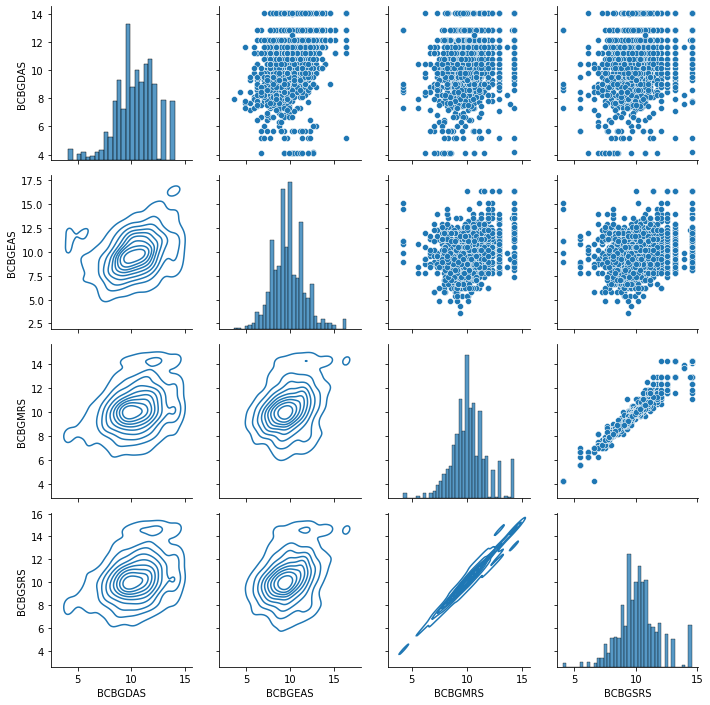

In [24]:
# plot the relationships between discipline, academics, and shortages
g = sns.PairGrid(school.loc[:,[col for col in school.columns if 'BCBG' in col]])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower maps show concentration of relational information
g.map_lower(sns.kdeplot)
# examine distribution of scores along the diagonal
g.map_diag(sns.histplot);

**Initial Observations about `school` dataset:**
* School discipline problems and focus on academic success do not seem correlated with each other or resource shortages
* Math and science resource shortages are strongly correlated; schools seem to be investing or struggling in both math and science equally
* There are many schools with hardly any struggles with discipline or resources, while most other schools are spread equally across the spectrum

**`school` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL to integers
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals
* rename all columns to be more descriptive
* merge with student performance by school

In [25]:
# investigate student assessment (stud_ach) dataframe
stud_ach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BNRGCAL1 BNRGCAL2  \
0    152.0  Booklet 03    5001.0  500101.0  50010101.0      NaN      NaN   
1    152.0  Booklet 04    5001.0  500101.0  50010102.0      NaN      NaN   
2    152.0  Booklet 05    5001.0  500101.0  50010103.0      NaN      NaN   
3    152.0  Booklet 06    5001.0  500101.0  50010104.0      NaN      NaN   
4    152.0  Booklet 07    5001.0  500101.0  50010105.0      NaN      NaN   

   IDPOP     IDGRADER  IDGRADE ITLANG_SA          LCID_SA   ITSEX  BSDAGE  \
0  Pop 2  Upper Grade  Grade 8   Spanish  Spanish (Chile)  Female   13.33   
1  Pop 2  Upper Grade  Grade 8   Spanish  Spanish (Chile)  Female   14.00   
2  Pop 2  Upper Grade  Grade 8   Spanish  Spanish (Chile)    Male   13.92   
3  Pop 2  Upper Grade  Grade 8   Spanish  Spanish (Chile)    Male   13.83   
4  Pop 2  Upper Grade  Grade 8   Spanish  Spanish (Chile)    Male   14.00   

                ITADMINI                                           ILRELIAB  \
0  National Center Staff  Students Booklet was used for Reliability Scoring   
1  National Center Staff  Students Booklet was used for Reliability Scoring   
2  National Center Staff  Students Booklet was used for Reliability Scoring   
3  National Center Staff  Students Booklet was used for Reliability Scoring   
4  National Center Staff  Students Booklet not used for Reliability Scoring   

   MP52024_val  MP52058_val  MP52125_val  MP52229_val  MP52063_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52072_val  MP52146_val  MP52092_val  MP52046_val  MP52083_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52082_val  MP52161_val  MP52418_val  MP72007_val  MP72025_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72017_val  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72098_val  MP72103_val  MP72121_val  MP72180_val  MP72198_val  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72227_val  MP72170_val  MP72209_val  MP62005_val  MP62139_val  \
0          NaN          NaN          NaN          0.0          0.0   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP62164_val  MP62142_val  MP62084_val  MP62351_val  MP62223_val  \
0          1

In [26]:
# create a list to drop all null columns and any columns that online contain one unique entry
stud_ach_drop_new = list(stud_ach.columns[stud_ach.isna().all()])+list(stud_ach.columns[stud_ach.nunique()==1])

In [27]:
# display descriptive statisticis for quantitative columns in the dataframe
stud_ach.describe()

IDCNTRY      IDSCHOOL        IDCLASS        IDSTUD        BSDAGE  \
count  37745.000000  37745.000000   37745.000000  3.774500e+04  37718.000000   
mean     453.714717   5095.756339  509578.627288  5.095788e+07     14.075185   
std      231.344104     59.982385    5998.155984  5.998154e+05      0.543180   
min      152.000000   5001.000000  500101.000000  5.001010e+07      9.250000   
25%      268.000000   5045.000000  504502.000000  5.045021e+07     13.670000   
50%      392.000000   5092.000000  509204.000000  5.092041e+07     14.000000   
75%      620.000000   5139.000000  513903.000000  5.139032e+07     14.330000   
max      926.000000   5266.000000  526601.000000  5.266011e+07     18.830000   

       MP52024_val  MP52058_val  MP52125_val  MP52229_val  MP52063_val  \
count  5309.000000  5077.000000  5302.000000  4956.000000  5259.000000   
mean      0.510077     0.273981     0.476990     0.459847     0.470241   
std       0.499946     0.446043     0.499517     0.498435     0.499161   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP52072_val  MP52146_val  MP52092_val  MP52046_val  MP52083_val  \
count  5315.000000  5021.000000  5224.000000  5224.000000  5073.000000   
mean      0.608843     0.211113     0.296133     0.280436     0.381628   
std       0.488055     0.408139     0.456594     0.449255     0.485834   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP52082_val  MP52161_val  MP52418_val  MP72007_val  MP72025_val  \
count  5269.000000  5237.000000  5218.000000  5293.000000  5241.000000   
mean      0.584741     0.698873     0.274435     0.165313     0.441137   
std       0.492813     0.458791     0.446272     0.371498     0.496570   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     1.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP72017_val  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
count  3873.000000  4969.000000  5252.000000  5176.000000  4505.000000   
mean      0.233153     0.597907     0.634996     0.420209     0.422863   
std       0.422893     0.490370     0.481477     0.493640     0.494069   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     1.000000     1.000000     0.000000     0.000000   
75%       0.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP72098_val  MP72103_val  MP72121_val  MP72180_val  MP72198_val  \
count  4461.000000  5122.000000  4877.000000  5163.000000  4518.000000   
mean      0.305089     0.467200     0.629485     0.528569     0.437804   
std       0.460497     0.498972     0.482992     0.499232     0.496172   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     1.000000     1.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000

In [28]:
# display the datatype for all columsn that are not averages or standard deviations of scores
stud_ach.loc[:,[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col]].dtypes

IDCNTRY      float64
IDBOOK        object
IDSCHOOL     float64
IDCLASS      float64
IDSTUD       float64
BNRGCAL1      object
BNRGCAL2      object
IDPOP         object
IDGRADER      object
IDGRADE       object
ITLANG_SA     object
LCID_SA       object
ITSEX         object
BSDAGE       float64
ITADMINI      object
ILRELIAB      object
dtype: object

In [29]:
# display the label information for every code that is not an assessment item
stud_ach_codes.loc[[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col],:]

Label
Variable                                                  
IDCNTRY                      Country ID - Numeric ISO Code
IDBOOK                                Student Test Booklet
IDSCHOOL                                         School ID
IDCLASS                                           Class ID
IDSTUD                                          Student ID
BNRGCAL1               CALCULATOR SURVEY\USE OF CALCULATOR
BNRGCAL2   CALCULATOR SURVEY\FREQUENCY OF USING CALCULATOR
IDPOP                                        Population ID
IDGRADER                             Standardized Grade ID
IDGRADE                                           Grade ID
ITLANG_SA             Language of Student Achievement Test
LCID_SA              Locale ID of Student Achievement Test
ITSEX                                      Sex of Students
BSDAGE                                        Students Age
ITADMINI                       Test Administrator Position
ILRELIAB                         Reliability Coding Status

In [30]:
# add additional nonrelevant information to be dropped
stud_ach_drop_new = stud_ach_drop_new+['BNRGCAL1','BNRGCAL2','ITADMINI','ILRELIAB']
stud_ach_drop_new

['MP62342_val',
 'MP72038_val',
 'MP62048_val',
 'SP62272_val',
 'SP52221_val',
 'SP72133_val',
 'SP72048_val',
 'SP62036_val',
 'SP72906_val',
 'SP72329_val',
 'SP62266_val',
 'IDPOP',
 'IDGRADER',
 'IDGRADE',
 'BNRGCAL1',
 'BNRGCAL2',
 'ITADMINI',
 'ILRELIAB']

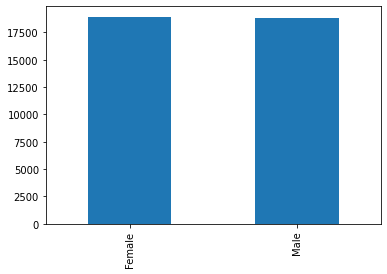

In [31]:
# graph the different counts of gender in the dataset
stud_ach['ITSEX'].value_counts().plot(kind='bar');

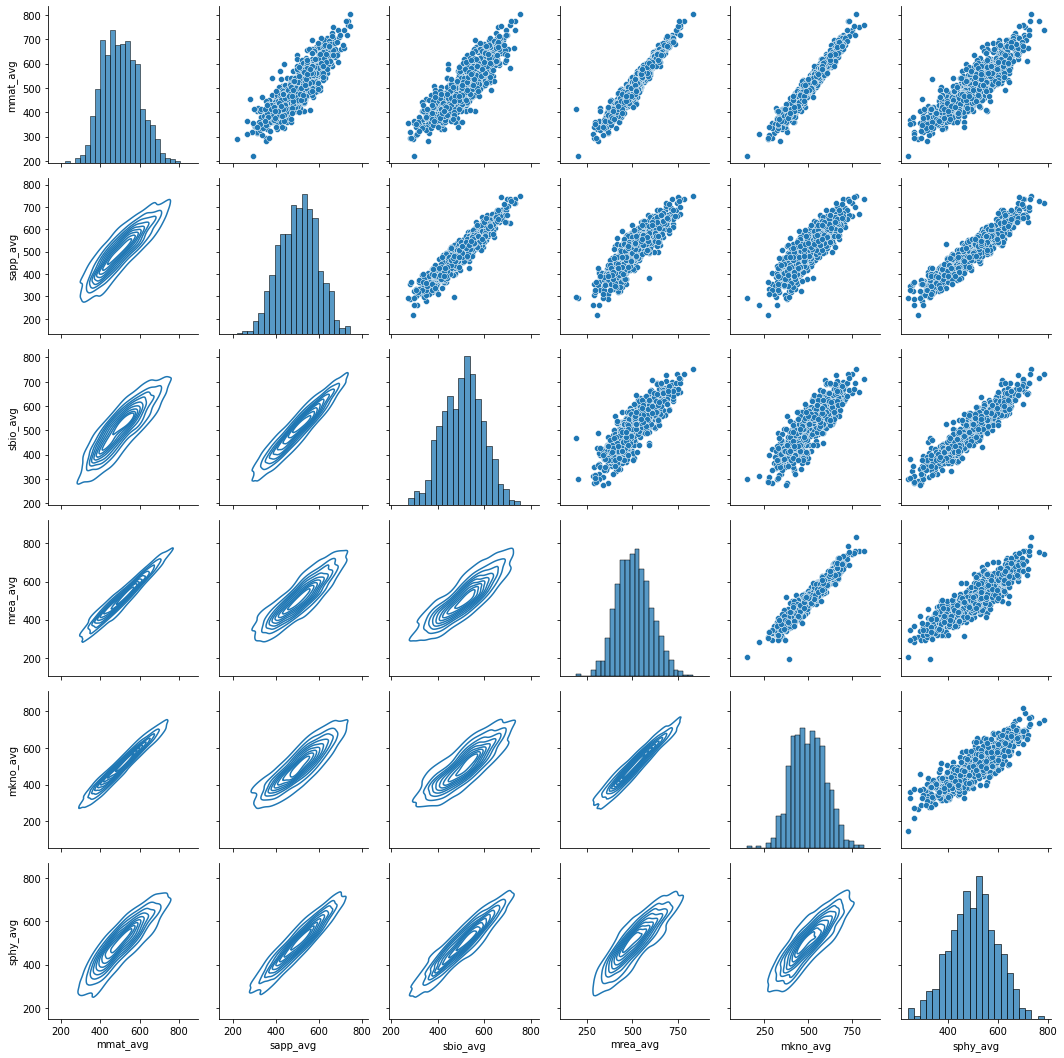

In [32]:
# plot distributions and relationships for a random sample of 1000 students and scores in 6 random categories
g = sns.PairGrid(stud_ach.sample(1000).loc[:,random.sample([col for col in stud_ach.columns if '_avg' in col],6)])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower graphs show concentration of the correlation data
g.map_lower(sns.kdeplot)
# the diagonal graphs show the distribution of the scores in the 6 categories
g.map_diag(sns.histplot);

**Initial Observations about `stud_ach` dataset:**
* All mathematical understanding is closely related (strong correlation)
* All science understanding is closely related (strong correlation)
* The relationship between science and math has more variance - is this due to subject differences or the difference in teaching?

**`stud_ach` Data Preparation**
* drop unnecessary (or null) columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK to integer
* rename all columns to be more descriptive

In [33]:
# explore the basic info for teh student dataframe
student.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01  BSBG03  \
0    152.0  Booklet 03    5001.0  500101.0  50010101.0   Girl  Always   
1    152.0  Booklet 04    5001.0  500101.0  50010102.0   Girl  Always   
2    152.0  Booklet 05    5001.0  500101.0  50010103.0    Boy  Always   
3    152.0  Booklet 06    5001.0  500101.0  50010104.0    Boy  Always   
4    152.0  Booklet 07    5001.0  500101.0  50010105.0    Boy  Always   

                                       BSBG04 BSBG05A BSBG05B BSBG05C BSBG05D  \
0  Enough to fill one bookcase (26–100 books)     Yes     Yes     Yes     Yes   
1  Enough to fill one bookcase (26–100 books)     Yes     Yes     Yes     Yes   
2  Enough to fill one bookcase (26–100 books)     Yes     Yes     Yes     Yes   
3      Enough to fill one shelf (11–25 books)     Yes     Yes     Yes     Yes   
4               None or very few (0–10 books)     Yes      No      No     Yes   

  BSBG05E BSBG05F BSBG05G BSBG05H BSBG05I  \
0     Yes      No     Yes      No     Yes   
1     Yes      No     Yes     Yes     Yes   
2     Yes      No     Yes     Yes     Yes   
3     NaN      No     Yes      No      No   
4     Yes      No     Yes      No      No   

                                          BSBG06A  \
0  <Bachelor’s or equivalent level—ISCED Level 6>   
1       <Upper secondary education—ISCED Level 3>   
2  <Short-cycle tertiary education—ISCED Level 5>   
3                                    I don’t know   
4       <Upper secondary education—ISCED Level 3>   

                                          BSBG06B  \
0  <Bachelor’s or equivalent level—ISCED Level 6>   
1  <Short-cycle tertiary education—ISCED Level 5>   
2  <Bachelor’s or equivalent level—ISCED Level 6>   
3                                    I don’t know   
4       <Upper secondary education—ISCED Level 3>   

                                              BSBG07 BSBG08A BSBG08B BSBG09A  \
0  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
1  Finish <Postgraduate degree: Master’s—ISCED Le...     Yes     Yes     Yes   
2  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
3  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
4   Finish <Upper secondary education—ISCED Level 3>     Yes     Yes     Yes   

  BSBG09B                 BSBG10           BSBG11A           BSBG11B BSBG12A  \
0     NaN  Never or almost never         Every day  Almost every day     Yes   
1     NaN  Never or almost never         Sometimes         Sometimes     Yes   
2     NaN  Never or almost never         Every day         Sometimes      No   
3     NaN  Never or almost never         Every day  Almost every day     Yes   
4     NaN  Never or almost never  Almost every day         Every day     Yes   

  BSBG12B BSBG12C BSBG12D BSBG12E BSBG12F  IDPOP ITLANG_SQ          LCID_SQ  \
0      No     Yes      No     Yes      No  Pop 2   Spanish  Spanish (Chile)   
1     Yes     Yes      No     Yes      No  Pop 2   Spanish  Spanish (Chile)   
2     Yes      No      No     Yes     Yes  Pop 2   Spanish  Spanish (Chile)   
3      No     Yes      No     Yes     Yes  Pop 2   Spanish  Spanish (Chile)   
4      No     Yes      No     Yes      No  Pop 2   Spanish  Spanish (Chile)   

  ITLANG_SA          LCID_SA   ITSEX  BSDAGE   BSBGHER         BSDGHER  \
0   Spanish  Spanish (Chile)  Female   13.33  11.48712  Some Resources   
1   Spanish  Spanish (Chile)  Female   14.00  10.84499  Some Resources   
2   Spanish  Spanish (Chile)    Male   13.92  11.48712  Some Resources   
3   Spanish  Spanish (Chile)    Male   13.83  10.26525  Some Resources   
4   Spanish  Spanish (Chile)    Male   14.00   8.35810   Few Resources   

    BSBGSSB                           BSDGSSB    BSBGSB  \
0   8.08091    Some Sense of School Belonging  11.18784   
1  10.00496    Some Sense of School Belonging   8.50552   
2   8.08091    Some Sense of School Belonging   7.06124   
3   7.08155  Little Sense of School Belonging   8.

In [34]:
# create a list to drop all empty or unnecessary columns (containing only one value)
student_drop_new = list(student.columns[student.isna().all()])+list(student.columns[student.nunique()==1])

In [35]:
# display the basic quality information for the student dataframe
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37745 entries, 0 to 37744
Data columns (total 92 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IDCNTRY    37745 non-null  float64
 1   IDBOOK     37745 non-null  object 
 2   IDSCHOOL   37745 non-null  float64
 3   IDCLASS    37745 non-null  float64
 4   IDSTUD     37745 non-null  float64
 5   BSBG01     37156 non-null  object 
 6   BSBG03     37092 non-null  object 
 7   BSBG04     37024 non-null  object 
 8   BSBG05A    37036 non-null  object 
 9   BSBG05B    37032 non-null  object 
 10  BSBG05C    33313 non-null  object 
 11  BSBG05D    36982 non-null  object 
 12  BSBG05E    36964 non-null  object 
 13  BSBG05F    33257 non-null  object 
 14  BSBG05G    29524 non-null  object 
 15  BSBG05H    29551 non-null  object 
 16  BSBG05I    19474 non-null  object 
 17  BSBG06A    36096 non-null  object 
 18  BSBG06B    35960 non-null  object 
 19  BSBG07     36325 non-null  object 
 20  BSBG08

In [36]:
# display descriptive statistics of the quantitative information of the student dataframe
student.describe()

IDCNTRY      IDSCHOOL        IDCLASS        IDSTUD        BSDAGE  \
count  37745.000000  37745.000000   37745.000000  3.774500e+04  37718.000000   
mean     453.714717   5095.756339  509578.627288  5.095788e+07     14.075185   
std      231.344104     59.982385    5998.155984  5.998154e+05      0.543180   
min      152.000000   5001.000000  500101.000000  5.001010e+07      9.250000   
25%      268.000000   5045.000000  504502.000000  5.045021e+07     13.670000   
50%      392.000000   5092.000000  509204.000000  5.092041e+07     14.000000   
75%      620.000000   5139.000000  513903.000000  5.139032e+07     14.330000   
max      926.000000   5266.000000  526601.000000  5.266011e+07     18.830000   

            BSBGHER       BSBGSSB        BSBGSB       BSBGSLM       BSBGICM  \
count  36098.000000  36961.000000  33283.000000  36929.000000  36936.000000   
mean      10.482520      9.688181     10.333587      9.641706      9.849874   
std        1.566109      1.834474      1.859782      1.821005      1.940698   
min        4.552080      3.924400      1.953440      5.094840      3.695680   
25%        9.647610      8.460960      9.050150      8.570950      8.518960   
50%       10.265250      9.408010      9.928090      9.680140      9.522190   
75%       11.487120     10.709560     12.937340     10.670040     11.651150   
max       13.515430     13.271990     12.937340     13.848490     13.018850   

            BSBGDML       BSBGSCM       BSBGSVM       BSBGSLS       BSBGICS  \
count  36906.000000  36886.000000  36842.000000  22904.000000  22884.000000   
mean      10.075661      9.855840      9.533508      9.662412      9.645186   
std        2.068527      2.158326      1.902043      1.956682      2.006134   
min        5.566330      3.277930      3.036820      3.846500      4.022730   
25%        8.705590      8.761680      8.346150      8.317790      8.250530   
50%        9.994450      9.672300      9.356760      9.340760      9.513030   
75%       11.103430     10.849510     10.773080     10.688780     11.431060   
max       14.673710     15.851880     13.482930     13.517780     12.633860   

            BSBGSCS       BSBGSVS       BSBGSLB       BSBGICB       BSBGSCB  \
count  22832.000000  36681.000000  13880.000000  13863.000000  13865.000000   
mean       9.848790      9.598507     10.025652      9.912725      9.854512   
std        2.056205      1.811125      1.949406      1.955663      1.953494   
min        3.249920      4.283400      3.770330      3.805730      3.049750   
25%        8.621220      8.411230      8.646750      8.476250      8.768360   
50%        9.615810      9.450510      9.829640      9.939960      9.628410   
75%       10.701970     10.656290     11.404230     11.547870     10.979050   
max       14.841820     12.936700     13.864760     12.776070     14.925630   

            BSBGSLE       BSBGICE       BSBGSCE       BSBGSLC       BSBGICC  \
count  13556.000000  13528.000000  13517.000000  13849.000000  13820.000000   
mean      10.114402      9.941383      9.833657      9.884385      9.814194   
std        1.909646      1.936625      1.965186      1.954712      2.003080   
min        4.020150      4.198000      3.210940      4.381810      4.449820   
25%        8.937070      8.604940      8.807510      8.574580      8.396110   
50%        9.854610      9.977935      9.500340      9.604000      9.753180   
75%       11.265810     11.608490     10.806850     11.138650     11.561420   
max       14.057380     12.753610     14.910220     13.776840     12.636810   

            BSBGSCC       BSBGSLP       BSBGICP       BSBGSCP       BSBGSEC  
count  13798.000000  13854.000000  13821.000000  13809.000000  32936.000000  
mean       9.809680      9.828447      9.750277      9.709115     10.264245  
std        1.997677      1.940489      1.996198      2.015350      1.895719  
min        3.896350      4.500520      4.575930      3.904790      3.210100  
25%        8.784090      8.547160      8.458410      

In [37]:
# display the contextual information for each column
student_codes.loc[student.columns,:]

Label
IDCNTRY                        Country ID - Numeric ISO Code
IDBOOK                                  Student Test Booklet
IDSCHOOL                                           School ID
IDCLASS                                             Class ID
IDSTUD                                            Student ID
BSBG01                                    GEN\SEX OF STUDENT
BSBG03                GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
BSBG04                      GEN\AMOUNT OF BOOKS IN YOUR HOME
BSBG05A                     GEN\HOME POSSESS\COMPUTER TABLET
BSBG05B                          GEN\HOME POSSESS\STUDY DESK
BSBG05C                            GEN\HOME POSSESS\OWN ROOM
BSBG05D                 GEN\HOME POSSESS\INTERNET CONNECTION
BSBG05E                    GEN\HOME POSSESS\OWN MOBILE PHONE
BSBG05F                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05G                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05H                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05I                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG06A        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
BSBG06B        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN B>
BSBG07                GEN\HOW FAR IN EDU DO YOU EXPECT TO GO
BSBG08A            GEN\<PARENT/GUARDIAN A> BORN IN <COUNTRY>
BSBG08B            GEN\<PARENT/GUARDIAN B> BORN IN <COUNTRY>
BSBG09A                                GEN\BORN IN <COUNTRY>
BSBG09B            GEN\BORN IN <COUNTRY>\AGE CAME TO COUNTRY
BSBG10                GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
BSBG11A                                  GEN\HOW OFTEN\TIRED
BSBG11B                                 GEN\HOW OFTEN\HUNGRY
BSBG12A                    GEN\INTERNET USE\ACCESS TEXTBOOKS
BSBG12B                  GEN\INTERNET USE\ACCESS ASSIGNMENTS
BSBG12C         GEN\INTERNET USE\COLLABORATE WITH CLASSMATES
BSBG12D            GEN\INTERNET USE\COMMUNICATE WITH TEACHER
BSBG12E     GEN\INTERNET USE\FIND INFO TO AID IN MATH OR SCI
BSBG12F               GEN\INTERNET USE\ACCESS LEARNING GAMES
IDPOP                                          Population ID
ITLANG_SQ          Language of Student Context Questionnaire
LCID_SQ           Locale ID of Student Context Questionnaire
ITLANG_SA               Language of Student Achievement Test
LCID_SA                Locale ID of Student Achievement Test
ITSEX                                        Sex of Students
BSDAGE                                          Students Age
BSBGHER                       Home Educational Resources/SCL
BSDGHER                       Home Educational Resources/IDX
BSBGSSB               Students Sense of School Belonging/SCL
BSDGSSB               Students Sense of School Belonging/IDX
BSBGSB                                  Student Bullying/SCL
BSDGSB                                  Student Bullying/IDX
BSBGSLM       Students Like Learning Mathematics Lessons/SCL
BSDGSLM       Students Like Learning Mathematics Lessons/IDX
BSBGICM     Instructional Clarity in Mathematics Lessons/SCL
BSDGICM     Instructional Clarity in Mathematics Lessons/IDX
BSBGDML          Disorderly Behavior during Math Lessons/SCL
BSDGDML          Disorderly Behavior during Math Lessons/IDX
BSBGSCM                 Student Confident in Mathematics/SCL
BSDGSCM                 Student Confident in Mathematics/IDX
BSBGSVM                       Students Value Mathematics/SCL
BSDGSVM                       Students Value Mathematics/IDX
BSBGSLS                   Students Like Learning Science/SCL
BSDGSLS                   Students Like Learning Science/IDX
BSBGICS         Instructional Clarity in Science Lessons/SCL
BSDGICS         Instructional Clarity in Science Lessons/IDX
BSBGSCS                     Student Confident in Science/SCL
BSDGSCS                     Student Confident in Science/IDX
BSBGSVS                           Students Value Science/SCL
BSDGSVS                           Students Value Science/IDX
BSBGSLB                   Students Like Learning Biology/SCL
BSDGSLB                   Stu

In [38]:
# investigate the unique entries on some of the qualitative data
student['BSDGSB'].unique()

array(['Never or Almost Never', 'About Monthly', 'About Weekly', nan],
      dtype=object)

In [39]:
# investigate some of the data that appears to have two different languages
student.query('ITLANG_SQ != ITLANG_SA and ITLANG_SQ == ITLANG_SQ')

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01  \
15607    376.0  Booklet 13    5041.0  504105.0  50410514.0   Girl   
26867    440.0  Booklet 08    5026.0  502601.0  50260110.0   Girl   
30114    440.0  Booklet 08    5255.0  525501.0  52550116.0    Boy   

              BSBG03                                      BSBG04 BSBG05A  \
15607      Sometimes      Enough to fill one shelf (11–25 books)     Yes   
26867  Almost always  Enough to fill one bookcase (26–100 books)     Yes   
30114         Always      Enough to fill one shelf (11–25 books)     Yes   

      BSBG05B BSBG05C BSBG05D BSBG05E BSBG05F BSBG05G BSBG05H BSBG05I  \
15607     Yes     NaN     Yes     Yes     NaN     NaN     NaN     NaN   
26867     Yes     Yes     Yes     Yes      No     Yes     Yes     NaN   
30114     Yes     Yes     Yes     Yes      No     Yes      No     NaN   

                                              BSBG06A  \
15607                                  Not applicable   
26867  <Short-cycle tertiary education—ISCED Level 5>   
30114                                    I don’t know   

                                              BSBG06B  \
15607                                  Not applicable   
26867  <Short-cycle tertiary education—ISCED Level 5>   
30114                                    I don’t know   

                                                  BSBG07 BSBG08A  \
15607  Finish <Postgraduate degree: Master’s—ISCED Le...     Yes   
26867  Finish <Bachelor’s or equivalent level—ISCED L...     Yes   
30114   Finish <Lower secondary education—ISCED Level 2>     Yes   

            BSBG08B BSBG09A BSBG09B                BSBG10           BSBG11A  \
15607           Yes     Yes     NaN  Once every two month  Almost every day   
26867           Yes     Yes     NaN  Once every two weeks  Almost every day   
30114  I don't know     Yes     NaN                   NaN         Sometimes   

         BSBG11B BSBG12A BSBG12B BSBG12C BSBG12D BSBG12E BSBG12F  IDPOP  \
15607  Every day     Yes      No     Yes     Yes     Yes      No  Pop 2   
26867  Sometimes      No     Yes     Yes      No     Yes     Yes  Pop 2   
30114      Never     Yes     Yes      No      No     Yes      No  Pop 2   

        ITLANG_SQ                 LCID_SQ   ITLANG_SA                 LCID_SA  \
15607      Hebrew         Hebrew (Israel)      Arabic         Arabic (Israel)   
26867  Lithuanian  Lithuanian (Lithuania)      Polish       Polish (Lithania)   
30114     Russian     Russian (Lithuania)  Lithuanian  Lithuanian (Lithuania)   

        ITSEX  BSDAGE   BSBGHER         BSDGHER   BSBGSSB  \
15607  Female   14.08       NaN             NaN  10.70956   
26867  Female   14.25  10.84499  Some Resources   8.08091   
30114    Male   15.08  10.26525  Some Resources   8.46096   

                              BSDGSSB    BSBGSB                 BSDGSB  \
15607  High Sense of School Belonging       NaN                    NaN   
26867  Some Sense of School Belonging   8.35784          About Monthly   
30114  Some Sense of School Belonging  10.91237  Never or Almost Never   

        BSBGSLM                             BSDGSLM   BSBGICM  \
15607  10.05658  Somewhat Like Learning Mathematics  10.92487   
26867   9.31385    Do Not Like Learning Mathematics   9.15605   
30114   8.94763    Do Not Like Learning Mathematics   8.18273   

                               BSDGICM   BSBGDML       BSDGDML   BSBGSCM  \
15607      High Clarity of Instruction   8.15891  Some Lessons   8.99736   
26867  Moderate Clarity of Instruction  10.67499  Some Lessons  10.12116   
30114  Moderate Clarity of Instruction  10.39898  Some Lessons   8.25602   

                                 BSDGSCM   BSBGSVM  \
15607       Not Confident in Mathematics  10.77308   
26867  Somewhat Confident in Mathematics   8.34615   
30114       Not Confident in Mathematics   7.91135   

                          BSDGSVM  BSBGSLS BSDGSLS   BSBGICS  \
15607  Strongly Value Mathematics      NaN     NaN  11.43106   
26867

In [40]:
# add additional nonrelevant data to be dropped from the dataframe
student_drop_new = student_drop_new + ['BSBG01','LCID_SQ','LCID_SA']

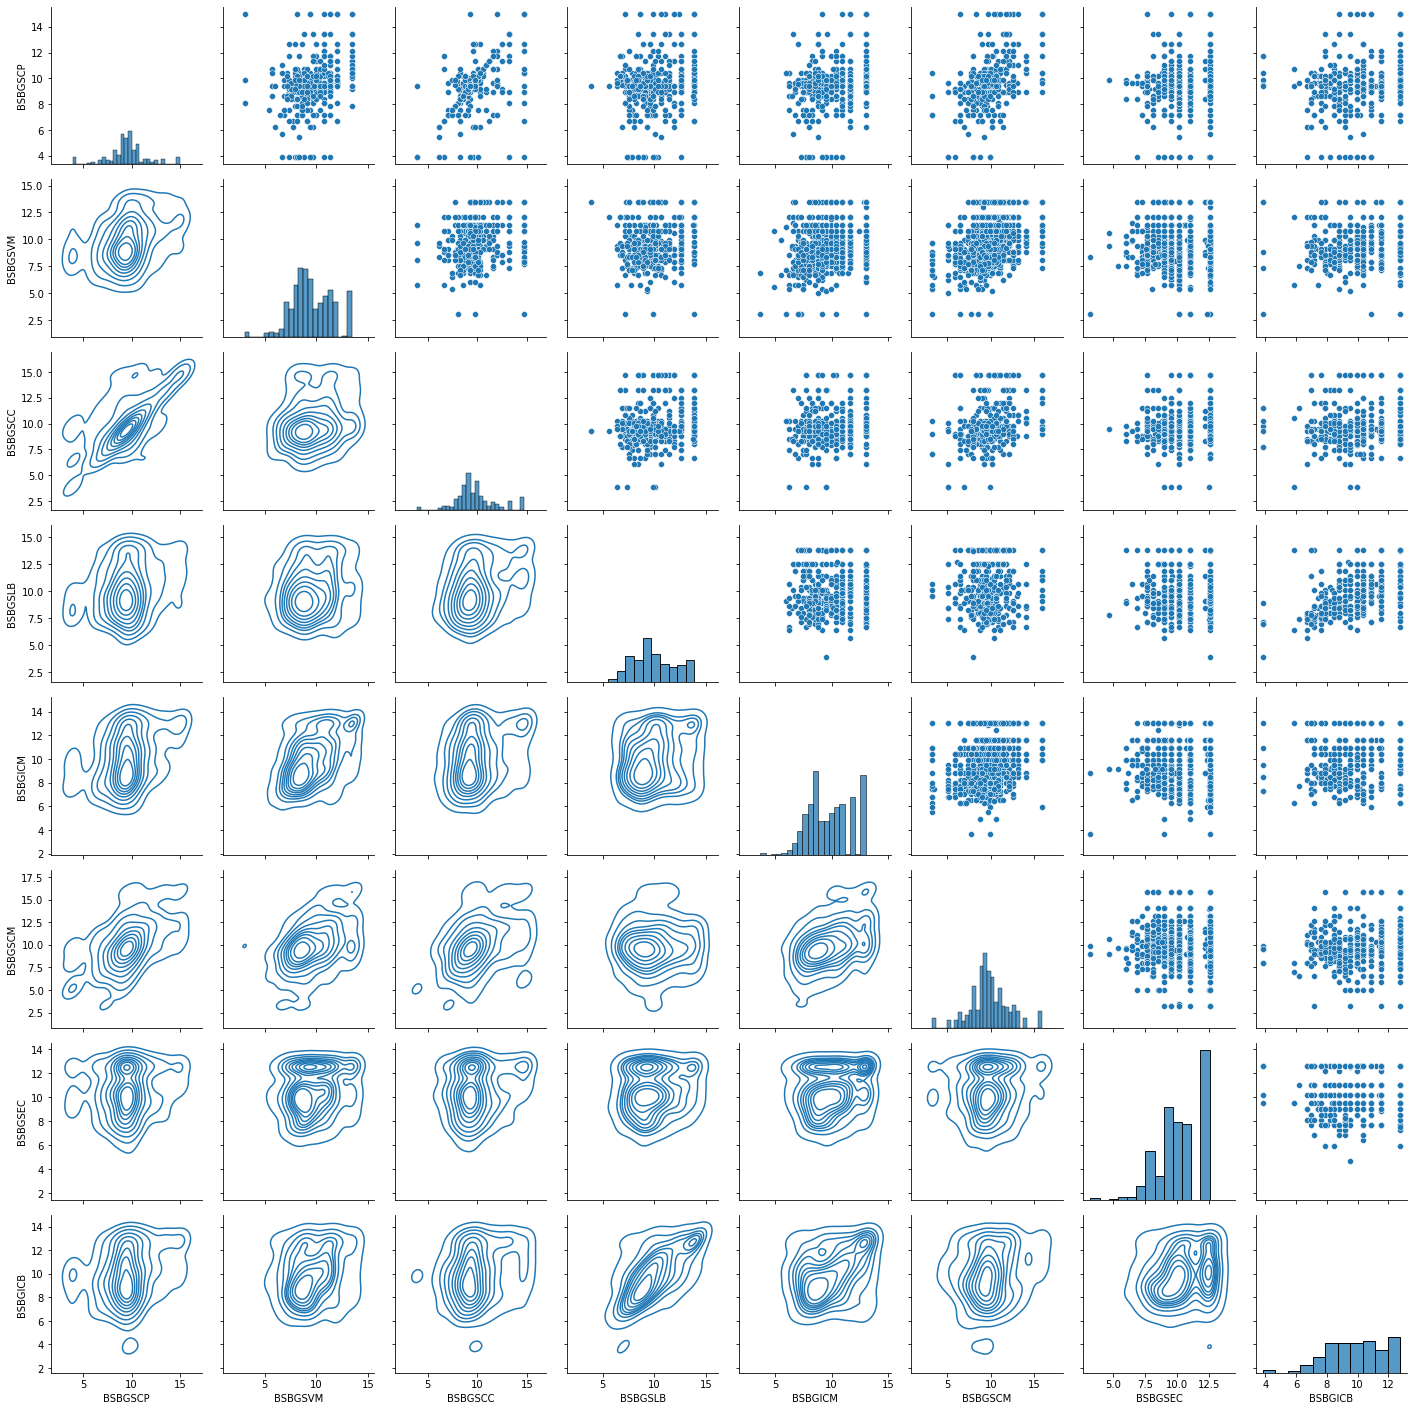

In [41]:
# visualize the relationships between a selection of the available scores for student demographics (1000 randomly sampled students, 8 random sampled variables)
g = sns.PairGrid(student.sample(1000).loc[:,random.sample([col for col in student.columns if 'BSBG' in col and student[col].dtype == 'float64'],8)])
# upper graphs will show correlation
g.map_upper(sns.scatterplot)
# lower graphs will show data concentration
g.map_lower(sns.kdeplot)
# diagonal graphs will show the distribution of each variable
g.map_diag(sns.histplot);

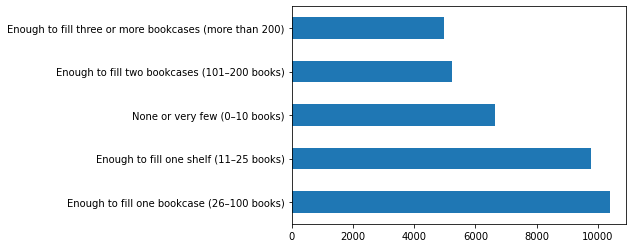

In [42]:
# visualize the number of books at home for each student
student['BSBG04'].value_counts().plot(kind='barh');

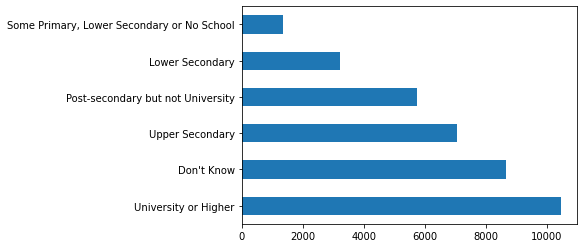

In [43]:
# visualize the highest level of education achieved by the parents of the student
student['BSDGEDUP'].value_counts().plot(kind='barh');

**Initial Observations about `student` dataset:**
* Apparent correlation between instructional clarity across all science classes (possible link to instructional quality at the school level)
* Wide variance in the number of books in the home
* Wide variance in highest parental education, but university is most common

**`student` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK to integers
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG09* columns to age_immigration column
* convert to integer and combine BSBG12* columns to internet_access column
* convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)
* convert BSBG08* to boolean
* rename all columns to be more descriptive
* merge with student performance

In [44]:
# explore basic structure of stud_teach dataset
stud_teach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD    IDTEALIN   IDTEACH  \
0    152.0  Booklet 03    5001.0  500101.0  50010101.0  50010202.0  500102.0   
1    152.0  Booklet 03    5001.0  500101.0  50010101.0  50010101.0  500101.0   
2    152.0  Booklet 04    5001.0  500101.0  50010102.0  50010101.0  500101.0   
3    152.0  Booklet 04    5001.0  500101.0  50010102.0  50010202.0  500102.0   
4    152.0  Booklet 05    5001.0  500101.0  50010103.0  50010202.0  500102.0   

   IDLINK  IDPOP       IDSUBJ            ITCOURSE  NMTEACH  NSTEACH  \
0     2.0  Pop 2      Science  Integrated science      1.0      1.0   
1     1.0  Pop 2  Mathematics         Mathematics      1.0      1.0   
2     1.0  Pop 2  Mathematics         Mathematics      1.0      1.0   
3     2.0  Pop 2      Science  Integrated science      1.0      1.0   
4     2.0  Pop 2      Science  Integrated science      1.0      1.0   

     mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg    mgeo_avg  \
0  510.039644  484.920930  537.405018  535.908242  485.313868  497.972680   
1  510.039644  484.920930  537.405018  535.908242  485.313868  497.972680   
2  367.035156  429.694244  384.601796  365.613198  343.750474  385.125398   
3  367.035156  429.694244  384.601796  365.613198  343.750474  385.125398   
4  473.458454  451.255038  417.999322  454.192632  479.973030  478.407436   

     mkno_avg    mnum_avg    mrea_avg    sapp_avg    sbio_avg    sche_avg  \
0  477.953044  510.706824  522.722704  463.918690  478.867222  504.582542   
1  477.953044  510.706824  522.722704  463.918690  478.867222  504.582542   
2  337.753284  387.514220  394.558680  403.428594  461.652974  479.271442   
3  337.753284  387.514220  394.558680  403.428594  461.652974  479.271442   
4  433.596562  435.568682  450.514346  450.254450  457.254430  410.660200   

     sear_avg    skno_avg    sphy_avg    srea_avg  
0  423.568466  450.648730  484.555370  469.590742  
1  423.568466  450.648730  484.555370  469.590742  
2  421.615742  483.247456  349.077246  423.393616  
3  421.615742  483.247456  349.077246  423.393616  
4  463.326072  418.531182  391.177204  422.373388

In [45]:
# create a list of columns to drop because they are null or have only one value
stud_teach_drop_new = list(stud_teach.columns[stud_teach.isna().all()])+list(stud_teach.columns[stud_teach.nunique()==1])

In [46]:
# also drop IDBOOK column
stud_teach_drop_new = stud_teach_drop_new + ['IDBOOK']

In [47]:
# investigate how many unique values each variable contains
stud_teach.nunique()

IDCNTRY        10
IDBOOK         14
IDSCHOOL      249
IDCLASS       995
IDSTUD      24871
IDTEALIN     1965
IDTEACH      1481
IDLINK         23
IDPOP           1
IDSUBJ          2
ITCOURSE        8
NMTEACH         4
NSTEACH         6
mmat_avg    37744
ssci_avg    37742
malg_avg    37741
mapp_avg    34430
mdat_avg    37742
mgeo_avg    37740
mkno_avg    34428
mnum_avg    37742
mrea_avg    34427
sapp_avg    37743
sbio_avg    37742
sche_avg    37741
sear_avg    37744
skno_avg    37741
sphy_avg    37741
srea_avg    37742
dtype: int64

In [48]:
# display summary information about stud_teach dataframe
stud_teach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109154 entries, 0 to 109153
Data columns (total 29 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   IDCNTRY   109154 non-null  float64
 1   IDBOOK    109154 non-null  object 
 2   IDSCHOOL  109154 non-null  float64
 3   IDCLASS   109154 non-null  float64
 4   IDSTUD    109154 non-null  float64
 5   IDTEALIN  109154 non-null  float64
 6   IDTEACH   109154 non-null  float64
 7   IDLINK    109154 non-null  float64
 8   IDPOP     109154 non-null  object 
 9   IDSUBJ    109154 non-null  object 
 10  ITCOURSE  109154 non-null  object 
 11  NMTEACH   109154 non-null  float64
 12  NSTEACH   109154 non-null  float64
 13  mmat_avg  109154 non-null  float64
 14  ssci_avg  109154 non-null  float64
 15  malg_avg  109154 non-null  float64
 16  mapp_avg  92499 non-null   float64
 17  mdat_avg  109154 non-null  float64
 18  mgeo_avg  109154 non-null  float64
 19  mkno_avg  92499 non-null   float64
 20  mnum

In [49]:
# display summary statistics about the quantitative variables of stud_teach
stud_teach.describe()

IDCNTRY       IDSCHOOL        IDCLASS        IDSTUD  \
count  109154.000000  109154.000000  109154.000000  1.091540e+05   
mean      427.446965    5098.000660  509802.869166  5.098030e+07   
std       208.779393      62.287356    6228.593273  6.228590e+05   
min       152.000000    5001.000000  500101.000000  5.001010e+07   
25%       268.000000    5045.000000  504505.000000  5.045051e+07   
50%       392.000000    5093.000000  509303.000000  5.093032e+07   
75%       440.000000    5143.000000  514302.000000  5.143020e+07   
max       926.000000    5266.000000  526601.000000  5.266011e+07   

           IDTEALIN        IDTEACH         IDLINK        NMTEACH  \
count  1.091540e+05  109154.000000  109154.000000  109154.000000   
mean   5.098027e+07  509802.699525       2.962081       1.076589   
std    6.228779e+05    6228.778281       3.208322       0.320893   
min    5.001010e+07  500101.000000       1.000000       1.000000   
25%    5.045030e+07  504503.000000       1.000000       1.000000   
50%    5.093030e+07  509303.000000       2.000000       1.000000   
75%    5.143010e+07  514301.000000       4.000000       1.000000   
max    5.266050e+07  526605.000000      53.000000       4.000000   

             NSTEACH       mmat_avg       ssci_avg       malg_avg  \
count  109154.000000  109154.000000  109154.000000  109154.000000   
mean        2.289756     503.486484     505.950481     503.278220   
std         1.307866      89.784144      85.519964      94.478576   
min         1.000000     152.013468     163.584684     108.780850   
25%         1.000000     440.445366     448.505144     437.095354   
50%         2.000000     501.118754     509.148965     499.352818   
75%         4.000000     564.704712     566.824406     565.887570   
max         6.000000     844.245024     794.461138     888.397876   

           mapp_avg       mdat_avg       mgeo_avg      mkno_avg  \
count  92499.000000  109154.000000  109154.000000  92499.000000   
mean     511.081252     499.748649     504.910458    506.955484   
std       89.160246      95.972653      96.240913     92.814216   
min      146.867254      25.659660      78.946176    109.509572   
25%      448.847772     435.309684     439.005912    442.345876   
50%      509.380982     501.625072     503.354936    504.532112   
75%      571.515850     565.568352     571.127000    569.235078   
max      874.593228     860.045736     869.864216    893.665148   

            mnum_avg      mrea_avg       sapp_avg       sbio_avg  \
count  109154.000000  92499.000000  109154.000000  109154.000000   
mean      500.189286    514.181498     503.153209     508.088850   
std        91.161657     89.741591      88.451005      86.344366   
min         7.549074    115.164582     145.152934     180.110328   
25%       435.343390    451.863435     442.701072     448.527475   
50%       497.126606    511.073182     505.809791     511.151716   
75%       561.581650    573.386182     565.669622     569.743754   
max       883.122124    873.466996     791.190464     799.885702   

            sche_avg       sear_avg       skno_avg       sphy_avg  \
count  109154.000000  109154.000000  109154.000000  109154.000000   
mean      499.877456     505.792941     505.395875     500.356306   
std        92.307735      93.362804      86.843941      93.284269   
min        68.200354      85.665846     130.878026       5.000000   
25%       438.580988     442.768873     446.179569     437.988606   
50%       502.825824     509.959273     507.804202     503.911038   
75%       564.452295     572.868090     566.582612     565.977588   
max       868.808802     883.370896     797.840558     821.946906   

            srea_avg  
count  109154.000000  
mean      507.109064  
std        89.608117  
min       105.313422  
25%       447.539754  
50%       512.010682  
75%       571.472504  
max       811.264354

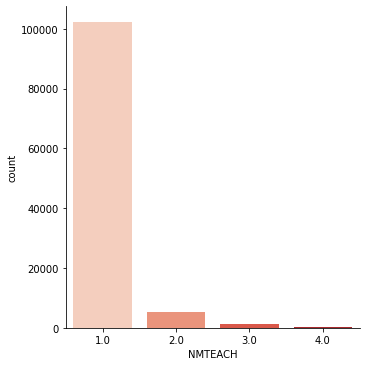

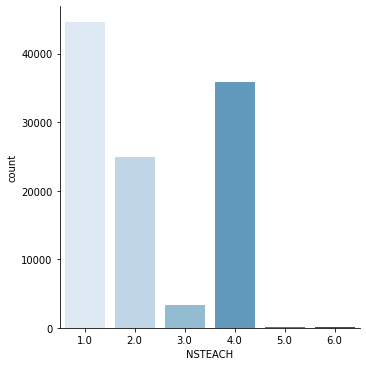

In [50]:
# plot the frequency of number of math and science teachers per individual student
sns.catplot(x='NMTEACH', kind='count', palette='Reds', data=stud_teach);
sns.catplot(x='NSTEACH', kind='count', palette='Blues', data=stud_teach);

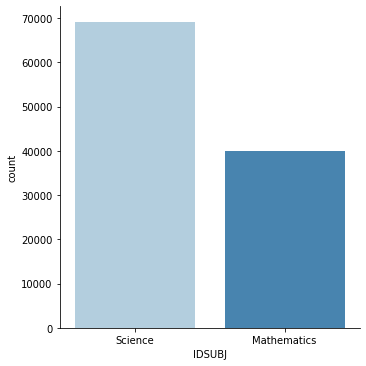

In [51]:
# plot the count of math and science teachers in the dataset
sns.catplot(x="IDSUBJ", kind="count", palette="Blues", data=stud_teach);

**Initial Observations about `stud_teach` dataset:**
* students are morel likey to have multiple science teachers than multiple math teachers
* there are more science teachers in the study than math teachers

**`stud_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers

In [52]:
# explore basic structure of the math_teach dataframe
math_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK     ITCOURSE  BTBG01  \
0    152.0    5001.0  50010101.0  500101.0     1.0  Mathematics     9.0   
1    152.0    5002.0  50020202.0  500202.0     2.0  Mathematics     4.0   
2    152.0    5004.0  50040101.0  500401.0     1.0  Mathematics     2.0   
3    152.0    5005.0  50050202.0  500502.0     2.0  Mathematics    34.0   
4    152.0    5007.0  50070202.0  500702.0     2.0  Mathematics     2.0   

   BTBG02 BTBG03                                          BTBG04 BTBG05A  \
0    Male  30–39    <Master’s or equivalent level—ISCED Level 7>     Yes   
1    Male  30–39  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
2    Male  25–29  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
3    Male  50–59    <Master’s or equivalent level—ISCED Level 7>     Yes   
4  Female  30–39  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   

  BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I    BTBG06A  \
0      No      No      No     Yes      No      No      No      No  Very high   
1      No     Yes      No      No     Yes      No      No     Yes     Medium   
2      No      No      No      No      No      No      No     Yes       High   
3      No      No      No      No     Yes      No     Yes     Yes     Medium   
4      No      No      No      No      No      No     Yes     Yes       High   

     BTBG06B    BTBG06C    BTBG06D    BTBG06E    BTBG06F    BTBG06G  \
0  Very high  Very high  Very high  Very high  Very high  Very high   
1     Medium     Medium       High       High       High       High   
2       High       High       High     Medium     Medium     Medium   
3     Medium     Medium       High        Low   Very low        Low   
4       High       High       High     Medium     Medium     Medium   

     BTBG06H    BTBG06I    BTBG06J    BTBG06K    BTBG06L         BTBG07A  \
0  Very high  Very high  Very high  Very high  Very high     Agree a lot   
1       High  Very high       High  Very high     Medium  Disagree a lot   
2        Low     Medium     Medium       High       High  Agree a little   
3   Very low     Medium     Medium       High     Medium     Agree a lot   
4     Medium       High       High     Medium     Medium  Agree a little   

          BTBG07B         BTBG07C         BTBG07D         BTBG07E  \
0     Agree a lot     Agree a lot     Agree a lot     Agree a lot   
1     Agree a lot  Agree a little  Agree a little     Agree a lot   
2     Agree a lot     Agree a lot  Agree a little  Agree a little   
3     Agree a lot     Agree a lot     Agree a lot     Agree a lot   
4  Agree a little  Agree a little  Agree a little  Agree a little   

          BTBG07F         BTBG07G         BTBG07H     BTBG08A     BTBG08B  \
0     Agree a lot     Agree a lot     Agree a lot  Very often  Very often   
1     Agree a lot  Agree a little  Agree a little       Often       Often   
2  Agree a little     Agree a lot     Agree a lot  Very often  Very often   
3  Agree a little  Agree a little  Agree a little  Very often  Very often   
4  Agree a little  Agree a little  Agree a little  Very often  Very often   

      BTBG08C     BTBG08D     BTBG08E            BTBG09A            BTBG09B  \
0  Very often  Very often  Very often        Agree a lot        Agree a lot   
1  Very often  Very often  Very often        Agree a lot     Agree a little   
2  Very often  Very often  Very often  Disagree a little  Disagree a little   
3  Very often  Very often  Very often     Disagree a lot     Disagree a lot   
4  Very often  Very often  Very often     Disagree a lot     Agree a little   

             BTBG09C         BTBG09D            BTBG09E            BTBG09F  \
0        Agree a lot     Agree a lot        Agree a lot        Agree a lot   
1        Agree a lot  Agree a little        Agree a lot  Disagree a little   
2  Disagree a little  Agree a little     Agree a little  Disagree a little   
3     Disagree a lot  Agree a little        Agree a lot  Disagree

In [53]:
# create list of math_teach columns to drop (null or single unique value)
math_teach_drop_new = list(math_teach.columns[math_teach.isna().all()])+list(math_teach.columns[math_teach.nunique()==1])

In [54]:
# add a redundant language column to be dropped
math_teach_drop_new = math_teach_drop_new + ['LCID_T']

In [55]:
# display the summary statistics for the quantitative values
math_teach.describe()

IDCNTRY     IDSCHOOL      IDTEALIN        IDTEACH       IDLINK  \
count  2179.000000  2179.000000  2.179000e+03    2179.000000  2179.000000   
mean    439.177604  5094.765948  5.094784e+07  509478.386875     1.837999   
std     205.376214    59.317006  5.931625e+05    5931.625762     2.052101   
min     152.000000  5001.000000  5.001010e+07  500101.000000     1.000000   
25%     268.000000  5044.000000  5.044020e+07  504402.000000     1.000000   
50%     380.000000  5092.000000  5.092010e+07  509201.000000     1.000000   
75%     440.000000  5136.000000  5.136010e+07  513601.000000     2.000000   
max     926.000000  5266.000000  5.266010e+07  526601.000000    51.000000   

            BTBG01       BTBG10       BTBG11       BTBM14      BTBGEAS  \
count  2036.000000  2020.000000  2000.000000  1989.000000  2042.000000   
mean     18.004912    24.979703     1.749000   219.722976     9.958642   
std      11.402270     8.561642     3.988854    71.233987     1.945611   
min       1.000000     1.000000     0.000000     0.000000     0.873410   
25%       8.000000    20.000000     0.000000   180.000000     8.846900   
50%      16.000000    25.000000     0.000000   225.000000     9.749340   
75%      26.000000    30.000000     2.000000   240.000000    10.952250   
max      54.000000    81.000000    35.000000   675.000000    17.780680   

           BTBGLSN      BTBGSOS      BTBGTJS      BTDMNUM      BTDMALG  \
count  2017.000000  2035.000000  2036.000000  2009.000000  2011.000000   
mean      9.727129    10.089234     9.771148    98.921520    64.635221   
std       2.224450     2.010582     1.780770     6.263408    25.868066   
min       3.623690     4.426320     5.281180    33.333330     0.000000   
25%       8.156030     8.783370     8.482860   100.000000    42.857140   
50%       9.619100    10.072630     9.769300   100.000000    71.428570   
75%      11.288280    11.149320    11.745590   100.000000    85.714290   
max      15.295110    13.870350    11.745590   100.000000   100.000000   

           BTDMGEO      BTDMDAT  VERSION  
count  2012.000000  2008.000000   2179.0  
mean     74.365473    59.907869      4.0  
std      20.358966    31.724478      0.0  
min       0.000000     0.000000      4.0  
25%      66.666670    33.333330      4.0  
50%      83.333330    66.666670      4.0  
75%      83.333330    83.333330      4.0  
max     100.000000   100.000000      4.0

In [56]:
# display contextual information for a subset of the math_teach columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG' not in col],:]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
ITCOURSE                         Subject Code in instrument
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM15A               MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B              MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C                    MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D               MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E                MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F               MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G              MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H               MATH\ASK STUDENTS\SAME ABILITY GROUPS
BTBM16                    MATH\PERMITTED TO USE CALCULATORS
BTBM17A       MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA    MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB        MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC       MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA       MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB    MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC   MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD     MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBM18AA                        MATH\TOPIC\NUMBER\COMPUTING
BTBM18AB             MATH\TOPIC\NUMBER\CONCEPT OF FRACTIONS
BTBM18AC         MATH\TOPIC\NUMBER\SOLVING PROB PROPORTIONS
BTBM18BA                     MATH\TOPIC\ALGEBRA\SIMPLIFYING
BTBM18BB                MATH\TOPIC\ALGEBRA\LINEAR EQUATIONS
BTBM18BC             MATH\TOPIC\ALGEBRA\LINEAR INEQUALITIES
BTBM18BD           MATH\TOPIC\ALGEBRA\SIMULTANEOUS EQUATION
BTBM18BE                       MATH\TOPIC\ALGEBRA\FUNCTIONS
BTBM18BF             MATH\TOPIC\ALGEBRA\PROPERTIES OF FUNCS
BTBM18BG                         MATH\TOPIC\ALGEBRA\NUMERIC
BTBM18CA           MATH\TOPIC\GEOMETRY\GEOMETRIC PROPERTIES
BTBM18CB        MATH\TOPIC\GEOMETRY\SOLVING PROB PERIMETERS
BTBM18CC       MATH\TOPIC\GEOMETRY\SOLVING PROB PYTHAGOREAN
BTBM18CD                    MATH\TOPIC\GEOMETRY\TRANSLATION
BTBM18CE              MATH\TOPIC\GEOMETRY\CONGRUENT FIGURES
BTBM18CF        MATH\TOPIC\GEOMETRY\THREE-DIMENSIONAL SHAPE
BTBM18DA      MATH\TOPIC\DATA\READING AND INTERPRETING DATA
BTBM18DB             MATH\TOPIC\DATA\IDENTIFYING PROCEDURES
BTBM18DC   MATH\TOPIC\DATA\ORGANIZING AND REPRESENTING DATA
BTBM18DD  MATH\TOPIC\DATA\CALCULATING AND INTERPRETING S...
BTBM18DE          MATH\TOPIC\DATA\PROBABILITY SIMPLE EVENTS
BTBM18DF        MATH\TOPIC\DATA\PROBABILITY COMPOUND EVENTS
BTBM19A               MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B                         MATH\TIME SPENT ON HOMEWORK
BTBM19CA                  MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB                 MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC                     MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD                 MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE                       MATH\HOMEWORK\USE FOR GRADES
BTBM20A       MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B          MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C        MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D             MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E       MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBM21                    MATH\TESTS ON COMPUTER OR TABLETS
BTBM22AA            MATH\PROF DEVELOPMENT PAST\MATH CONTENT
BTBM22BA          MATH\PROF DEVELOPMENT FUTURE\MATH CONTENT
BTBM22AB           MATH\PROF DEVELOPMENT PAST\MATH PEDAGOGY
BTBM22BB         MATH\PROF DEVELOPMENT FUTURE\MATH PEDAGOGY
BTBM22AC         MATH\PROF DEVELOPMENT PAST\MATH CURRICULUM
BTBM22BC       MATH\PROF DEVELOPMENT FUTURE\MATH CURRICULUM
BTBM22AD  MATH\PROF DEVELOPMENT PA

In [57]:
# investigate datatypes in the dataframe
math_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDMNUM     float64
BTDMALG     float64
BTDMGEO     float64
BTDMDAT     float64
VERSION     float64
Length: 157, dtype: object

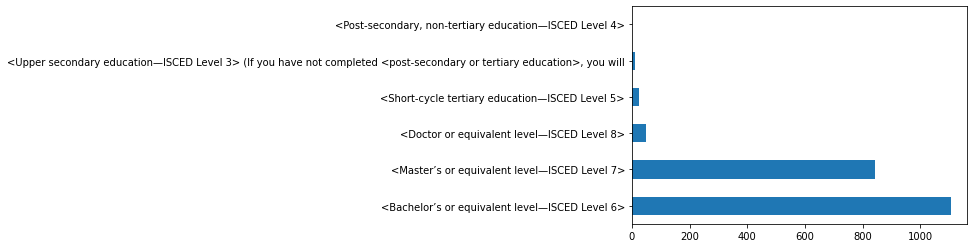

In [58]:
# graph frequency of educational achievement by the teachers in the dataframe
math_teach['BTBG04'].value_counts().plot(kind='barh');

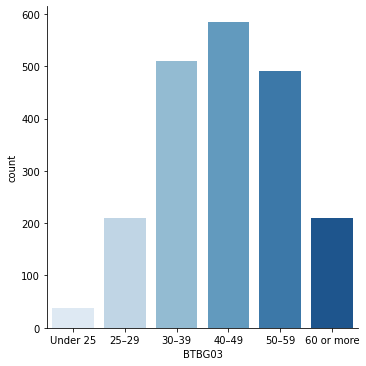

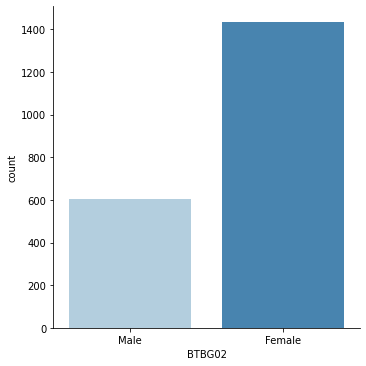

In [59]:
# create an ordinal categorical variable for the age of the teacher
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# impute the age as the ordinal type created above
math_teach['BTBG03'] = math_teach['BTBG03'].astype(cat_type)

# graph the age distribution of math teachers in the data
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=math_teach);
# graph the gender distribution of math teachers in the data
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=math_teach);

**Initial Observations about `math_teach` dataset:**
* Approximately Normal distribution of teacher ages
* Teach education is highly concentrated in the Bachelor's and Master's level
* Significantly more female teacher than males

**`math_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
* drop BTBM22* columns because alreadys summarized in BTBM23
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

In [60]:
# explore basic structure of science teacher data
sci_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK            ITCOURSE  \
0    152.0    5001.0  50010202.0  500102.0     2.0  Integrated science   
1    152.0    5002.0  50020101.0  500201.0     1.0  Integrated science   
2    152.0    5004.0  50040202.0  500402.0     2.0  Integrated science   
3    152.0    5005.0  50050101.0  500501.0     1.0  Integrated science   
4    152.0    5007.0  50070101.0  500701.0     1.0  Integrated science   

   BTBG01  BTBG02 BTBG03                                          BTBG04  \
0    12.0  Female  30–39    <Master’s or equivalent level—ISCED Level 7>   
1     6.0  Female  30–39  <Bachelor’s or equivalent level—ISCED Level 6>   
2     1.0    Male  25–29  <Bachelor’s or equivalent level—ISCED Level 6>   
3    14.0    Male  50–59  <Bachelor’s or equivalent level—ISCED Level 6>   
4    12.0  Female  30–39    <Master’s or equivalent level—ISCED Level 7>   

  BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I  \
0      No     Yes     Yes     Yes     Yes      No     Yes      No      No   
1      No     Yes      No      No      No      No     Yes      No      No   
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN      No   
3      No      No      No      No      No      No      No     Yes     Yes   
4      No     Yes     Yes     Yes      No      No     Yes      No      No   

     BTBG06A    BTBG06B    BTBG06C    BTBG06D    BTBG06E    BTBG06F  \
0  Very high  Very high  Very high  Very high  Very high  Very high   
1  Very high       High       High       High       High       High   
2  Very high       High  Very high  Very high       High     Medium   
3  Very high       High  Very high  Very high     Medium     Medium   
4     Medium     Medium  Very high       High       High     Medium   

     BTBG06G    BTBG06H    BTBG06I    BTBG06J    BTBG06K    BTBG06L  \
0  Very high  Very high  Very high  Very high  Very high  Very high   
1       High       High       High     Medium       High       High   
2       High       High     Medium     Medium       High  Very high   
3     Medium        Low       High     Medium       High  Very high   
4     Medium     Medium       High     Medium     Medium       High   

             BTBG07A         BTBG07B         BTBG07C            BTBG07D  \
0        Agree a lot     Agree a lot     Agree a lot        Agree a lot   
1  Disagree a little  Agree a little  Agree a little        Agree a lot   
2        Agree a lot     Agree a lot  Agree a little     Agree a little   
3        Agree a lot     Agree a lot     Agree a lot        Agree a lot   
4     Agree a little  Agree a little  Agree a little  Disagree a little   

             BTBG07E         BTBG07F         BTBG07G            BTBG07H  \
0        Agree a lot     Agree a lot     Agree a lot        Agree a lot   
1     Agree a little  Agree a little  Agree a little  Disagree a little   
2        Agree a lot  Agree a little     Agree a lot        Agree a lot   
3        Agree a lot     Agree a lot  Agree a little        Agree a lot   
4  Disagree a little  Agree a little  Agree a little     Agree a little   

      BTBG08A     BTBG08B     BTBG08C     BTBG08D     BTBG08E         BTBG09A  \
0  Very often  Very often  Very often  Very often  Very often     Agree a lot   
1       Often  Very often       Often       Often  Very often     Agree a lot   
2  Very often  Very often  Very often  Very often  Very often  Disagree a lot   
3  Very often  Very often  Very often  Very often  Very often  Agree a little   
4  Very often  Very often  Very often  Very often  Very often  Disagree a lot   

          BTBG09B            BTBG09C         BTBG09D         BTBG09E  \
0     Agree a lot        Agree a lot     Agree a lot     Agree a lot   
1     Agree a lot     Agree a little     Agree a lot     Agree a lot   
2  Disagree a lot     Disagree a lot     Agree a lot  Agree a little   
3  Agree a little     Agree a little     Agree a lot  Agree a little   
4     Agree a lot  Disagree a littl

In [61]:
# create a list of columns to drop (null or single unique value)
sci_teach_drop_new = list(sci_teach.columns[sci_teach.isna().all()])+list(sci_teach.columns[sci_teach.nunique()==1])

In [62]:
# add redundant languge column to be dropped
sci_teach_drop_new = sci_teach_drop_new + ['LCID_T']

In [63]:
# display contextual information for some of the data
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG' not in col],:].iloc[5:,:]

Label
Variable                                                   
ITCOURSE                         Subject Code in instrument
BTBS14                     SCI\TIME SPENT SCI INSTR MINUTES
BTBS15A                SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B                  SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C             SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D                   SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E                SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F                       SCI\ASK STUDENTS\PRESENT DATA
BTBS15G                     SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H            SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I                     SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J                     SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K                       SCI\ASK STUDENTS\USE FORMULAS
BTBS15L                      SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M               SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N                SCI\ASK STUDENTS\SAME ABILITY GROUPS
BTBS16A         SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA     SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB         SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC        SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA        SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB     SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC    SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD      SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBS17AA         SCI\TOPIC\BIO\DIFFERENCES TAXONOMIC GROUPS
BTBS17AB                         SCI\TOPIC\BIO\MAJOR ORGANS
BTBS17AC             SCI\TOPIC\BIO\CELLS AND THEIR FUNCTION
BTBS17AD                         SCI\TOPIC\BIO\REPRODUCTION
BTBS17AE                    SCI\TOPIC\BIO\ROLE OF VARIATION
BTBS17AF        SCI\TOPIC\BIO\INTERDEPENDENCE OF POPULATION
BTBS17AG                         SCI\TOPIC\BIO\HUMAN HEALTH
BTBS17BA               SCI\TOPIC\CHEM\PARTICULATE STRUCTURE
BTBS17BB                      SCI\TOPIC\CHEM\PERIODIC TABLE
BTBS17BC            SCI\TOPIC\CHEM\PHY CHEM PROPERTY MATTER
BTBS17BD              SCI\TOPIC\CHEM\MIXTURES AND SOLUTIONS
BTBS17BE                     SCI\TOPIC\CHEM\ACIDS AND BASES
BTBS17BF                  SCI\TOPIC\CHEM\CHEMICAL REACTIONS
BTBS17BG                   SCI\TOPIC\CHEM\MATTER AND ENERGY
BTBS17BH                   SCI\TOPIC\CHEM\ROLE OF ELECTRONS
BTBS17CA                      SCI\TOPIC\PHY\PHYSICAL STATES
BTBS17CB                SCI\TOPIC\PHY\ENERGY TRANSFORMATION
BTBS17CC            SCI\TOPIC\PHY\BASIC PROPERTIES OF LIGHT
BTBS17CD            SCI\TOPIC\PHY\BASIC PROPERTIES OF SOUND
BTBS17CE                    SCI\TOPIC\PHY\ELECTRIC CIRCUITS
BTBS17CF                   SCI\TOPIC\PHY\PROPERTIES MAGNETS
BTBS17CG                    SCI\TOPIC\PHY\MOTION AND FORCES
BTBS17DA                   SCI\TOPIC\EARTH\EARTHS STRUCTURE
BTBS17DB                   SCI\TOPIC\EARTH\EARTHS PROCESSES
BTBS17DC                   SCI\TOPIC\EARTH\EARTHS RESOURCES
BTBS17DD              SCI\TOPIC\EARTH\EARTH IN SOLAR SYSTEM
BTBS18A                 SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B                          SCI\TIME SPENT ON HOMEWORK
BTBS18CA                   SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB                  SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC                      SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD                  SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE                        SCI\HOMEWORK\USE FOR GRADES
BTBS19A        SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B           SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C         SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D              SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E        SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBS20                     SCI\TESTS ON COMPUTER OR TABLETS
BTBS21AA          SCI\PROF DEVELOPMENT PAST\SCIENCE CONTENT
BTBS21BA        SCI\PROF DEVELOPMENT FUTURE\SCIENCE CONTENT
BTBS21AB         SCI\PROF DEVELOPM

In [64]:
# display descriptive statistics for quantitative variables in the dataset
sci_teach.describe()

IDCNTRY     IDSCHOOL      IDTEALIN        IDTEACH       IDLINK  \
count  3568.000000  3568.000000  3.568000e+03    3568.000000  3568.000000   
mean    414.963565  5102.778868  5.102812e+07  510281.198711     3.984865   
std     183.391385    64.442659  6.444232e+05    6444.230188     4.586862   
min     152.000000  5001.000000  5.001020e+07  500102.000000     1.000000   
25%     268.000000  5048.000000  5.048020e+07  504802.000000     2.000000   
50%     392.000000  5098.000000  5.098020e+07  509802.000000     3.000000   
75%     440.000000  5149.000000  5.149020e+07  514902.000000     5.000000   
max     926.000000  5266.000000  5.266050e+07  526605.000000    53.000000   

            BTBG01       BTBG10       BTBG11       BTBS14      BTBGEAS  \
count  3299.000000  3251.000000  3221.000000  3235.000000  3330.000000   
mean     20.762958    23.999692     1.794163   121.550850    10.071689   
std      11.628036     8.414913     4.729205    62.916354     1.868978   
min       0.000000     1.000000     0.000000     0.000000     0.873410   
25%      11.000000    19.000000     0.000000    90.000000     8.846900   
50%      20.000000    25.000000     0.000000    90.000000    10.051020   
75%      30.000000    29.000000     1.000000   150.000000    11.250980   
max      55.000000   108.000000    40.000000   675.000000    17.780680   

           BTBGLSN      BTBGSOS      BTBGTJS      BTBSESI      BTDSBIO  \
count  3280.000000  3305.000000  3322.000000  3304.000000  1729.000000   
mean      9.860502    10.343722     9.563353     9.232251    71.237710   
std       2.011356     1.959938     1.845509     2.058914    21.676075   
min       3.623690     4.426320     5.281180     6.513090     0.000000   
25%       8.632380     8.783370     8.482860     8.038700    57.142860   
50%       9.619100    10.072630     9.769300     8.934510    71.428570   
75%      11.288280    11.789980    11.745590    10.613770    85.714290   
max      15.295110    13.870350    11.745590    16.032560   100.000000   

           BTDSCHE      BTDSPHY      BTDSEAR  VERSION  
count  1737.000000  1738.000000  1691.000000   3568.0  
mean     73.017586    62.715492    71.929825      4.0  
std      21.961058    24.710004    33.795777      0.0  
min       0.000000     0.000000     0.000000      4.0  
25%      62.500000    42.857140    50.000000      4.0  
50%      75.000000    57.142860    75.000000      4.0  
75%      87.500000    85.714290   100.000000      4.0  
max     100.000000   100.000000   100.000000      4.0

In [65]:
# display datatypes
sci_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDSBIO     float64
BTDSCHE     float64
BTDSPHY     float64
BTDSEAR     float64
VERSION     float64
Length: 168, dtype: object

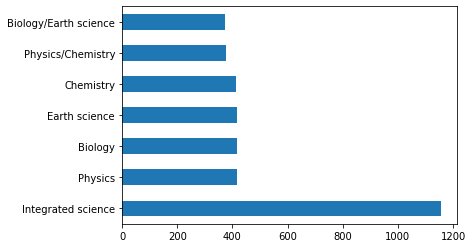

In [66]:
# graph the frequency of each science course taught
sci_teach['ITCOURSE'].value_counts().plot(kind='barh');

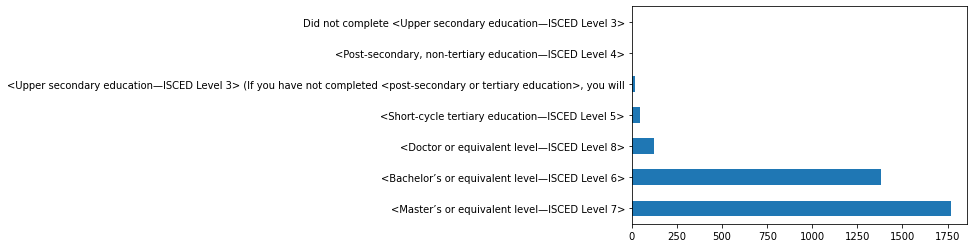

In [67]:
# visualize the frequency of educational achievement for science teachers
sci_teach['BTBG04'].value_counts().plot(kind='barh');

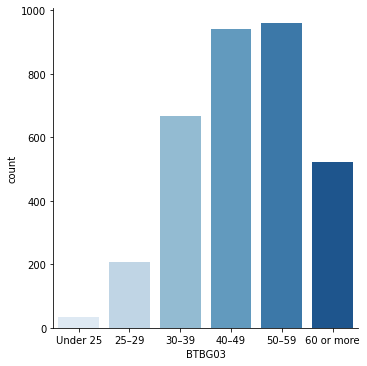

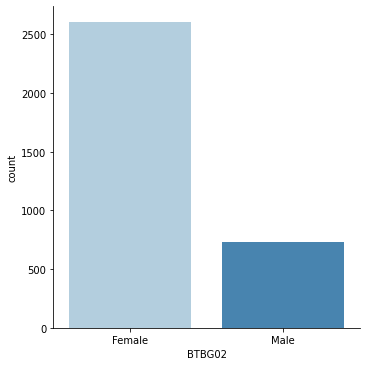

In [68]:
# create an ordinal categorical varialge for age groups
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# apply ordinal categorical to age data
sci_teach['BTBG03'] = sci_teach['BTBG03'].astype(cat_type)

# graph the age distribution for science teachers
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=sci_teach);
# graph the gender distribution for science teachers
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=sci_teach);

**Initial Observations about `sci_teach` dataset:**
* Approximately Normal distribution of teacher ages (slightly older than math teachers)
* Teach education is highly concentrated in the Bachelor's and Master's level (slightly more educated that math teachers)
* Significantly more female teacher than males (more significant difference than math teachers)
* Most schools offer Integrated Science as compared to specific disciplines

**`sci_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
* drop BTBS21* columns because alreadys summarized in BTBM22
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

[Return to Top](#top)

<div id='data_preparation'></div>

# Data Preparation

Jump to:
1. [`stud_ach Preparation`](#prep1)
1. [`school Preparation`](#prep2)
1. [`student Preparation`](#prep3)
1. [`stud_teach Preparation`](#prep4)
1. [`math_teach Preparation`](#prep5)
1. [`sci_teach Preparation`](#prep6)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep1'></div>

**`stud_ach` Data Preparation**
* ~~drop unnecessary (or null) columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK to integer~~
* ~~rename all columns to be more descriptive~~

#### Define
* drop unnecessary (or null) columns

#### Code

In [69]:
# drop the null and single-value columns
stud_ach.drop(columns=stud_ach_drop_new, inplace=True)
# drop the redundant language column
stud_ach.drop(columns=['LCID_SA'], inplace=True)

#### Test

In [70]:
# check for no overlap between the dropped columns and the remaining columns
set(stud_ach_drop_new) & set(stud_ach.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers

#### Code

In [71]:
# convert each of the columns into integer type
stud_ach['IDCNTRY'] = stud_ach['IDCNTRY'].astype(int)
stud_ach['IDSCHOOL'] = stud_ach['IDSCHOOL'].astype(int)
stud_ach['IDCLASS'] = stud_ach['IDCLASS'].astype(int)
stud_ach['IDSTUD'] = stud_ach['IDSTUD'].astype(int)

#### Test

In [72]:
# confirm change in datatype
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK          object
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
MP52058_val    float64
dtype: object

#### Define
* trim and convert IDBOOK to integer

#### Code

In [73]:
# take only the digits from the strings and convert to integer
stud_ach['IDBOOK'] = stud_ach['IDBOOK'].apply(lambda x: x[-2:]).astype(int)

#### Test

In [74]:
# confirm change in datatype 
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK           int32
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
MP52058_val    float64
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [75]:
# create dictionary for renaming the columns
stud_ach_col_dict = {'ITLANG_SA':'language','ITSEX':'sex','BSDAGE':'age','IDBOOK':'test_book'}
# rename the columns
stud_ach.rename(columns=stud_ach_col_dict, inplace=True)

#### Test

In [76]:
# check all columns that are not assessment item scores, category averages or standard deviations
[col for col in stud_ach.columns if '_avg' not in col and '_val' not in col and '_sd' not in col]

['IDCNTRY',
 'test_book',
 'IDSCHOOL',
 'IDCLASS',
 'IDSTUD',
 'language',
 'sex',
 'age']

[Return to Top of Data Preparation](#data_preparation)

<div id='prep2'></div>

**`school` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL to integers~~
* ~~convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance by school~~

#### Define
* Drop repetitive columns from the dataset

#### Code

In [77]:
# drop the null or single-value columns
school.drop(columns=school_drop_new,inplace=True)
# drop the redundant language column
school.drop(columns=['LCID_C'], inplace=True)

#### Test

In [78]:
# verify dropped columns
set(school_drop_new) & set(school.columns)

set()

#### Define
* Convert IDCNTRY, IDSCHOOL to integers

#### Code

In [79]:
school['IDCNTRY'] = school['IDCNTRY'].astype(int)
school['IDSCHOOL'] = school['IDSCHOOL'].astype(int)

#### Test

In [80]:
# confirm change in datatype
school.dtypes[:5]

IDCNTRY       int32
IDSCHOOL      int32
ITLANG_C     object
BCBGDAS     float64
BCBGEAS     float64
dtype: object

#### Define
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals

#### Code

In [81]:
# create a list of all indices measuring school traits
school_indices = ['BCDGDAS', 'BCDGEAS', 'BCDGMRS', 'BCDGSRS', 'BCDGSBC']
# go through each of the indices
for col in school_indices:
    # print the contextual information for the index
    print(school_codes.loc[col,:])
    # print the unique values for the index
    print(school[col].unique())

Label    School Discipline Problems-Prncpl/IDX
Name: BCDGDAS, dtype: object
['Hardly Any Problems' 'Minor Problems' 'Moderate to Severe Problems' nan]
Label    School Emph on Acad Success-Prncpl/IDX
Name: BCDGEAS, dtype: object
['Very High Emphasis' 'High Emphasis' 'Medium Emphasis' nan]
Label    Instr Aff by Mat Res Shortage-Prncpl/IDX
Name: BCDGMRS, dtype: object
['Affected A Lot' 'Affected' 'Not Affected' nan]
Label    Instr Aff by Sci Res Shortage-Prncpl/IDX
Name: BCDGSRS, dtype: object
['Affected A Lot' 'Affected' 'Not Affected' nan]
Label    School Composition by Socioeconomic Background
Name: BCDGSBC, dtype: object
['Neither More Affluent nor More Disadvantaged' 'More Disadvantaged'
 'More Affluent' nan]


In [82]:
# create an ordinal categorical variable for discipline problems
disc_prob_type = CategoricalDtype(categories=['Hardly Any Problems','Minor Problems','Moderate to Severe Problems'], ordered=True)
# create new column with ordinal type
school['disc_prob'] = school['BCDGDAS'].astype(disc_prob_type)
# create an ordinal categorical variable for academic emphasis
acad_emph_type = CategoricalDtype(categories=['Medium Emphasis', 'High Emphasis', 'Very High Emphasis'], ordered=True)
# create new column with ordinal type
school['acad_emph'] = school['BCDGEAS'].astype(acad_emph_type)
# create an ordinal categorical variable for affect of shortages
shortage_affect_type = CategoricalDtype(categories=['Not Affected', 'Affected', 'Affected A Lot'], ordered=True)
# create new columns with ordinal type
school['math_shortage'] = school['BCDGMRS'].astype(shortage_affect_type)
school['sci_shortage'] = school['BCDGSRS'].astype(shortage_affect_type)
# create an ordinal categorical variable for socioeconomic background
school_socio_type = CategoricalDtype(categories=['More Disadvantaged', 'Neither More Affluent nor More Disadvantaged', 'More Affluent'], ordered=True)
# create new column with ordinal type
school['socio_background'] = school['BCDGSBC'].astype(school_socio_type)
# drop the previous columns, leaving the ordinal columns
school.drop(columns=school_indices, inplace=True)

#### Test

In [83]:
# confirm datatypes
school.dtypes

IDCNTRY                int32
IDSCHOOL               int32
ITLANG_C              object
BCBGDAS              float64
BCBGEAS              float64
BCBGMRS              float64
BCBGSRS              float64
BCDGTIHY             float64
disc_prob           category
acad_emph           category
math_shortage       category
sci_shortage        category
socio_background    category
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [84]:
# create a dictionary for renaming columns
school_col_dict = {'BCBGDAS':'disc_prob_score','BCBGEAS':'acad_emph_score','BCBGMRS':'math_shortage_score','BCBGSRS':'sci_shortage_score','BCDGTIHY':'acad_hours','ITLANG_C':'language'}
# rename columns
school.rename(columns=school_col_dict,inplace=True)

#### Test

In [85]:
# confirm rename of columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'language', 'disc_prob_score', 'acad_emph_score',
       'math_shortage_score', 'sci_shortage_score', 'acad_hours', 'disc_prob',
       'acad_emph', 'math_shortage', 'sci_shortage', 'socio_background'],
      dtype='object')

#### Define
* merge with student performance by school

#### Code

In [86]:
# confirm student achievement data grouped by IDCNTRY and IDSCHOOL
stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg  \
IDCNTRY IDSCHOOL                                                               
152     5001      426.441591  446.392404  417.506010  425.519398  419.118714   
        5002      436.846126  453.555063  439.048408  439.795888  424.946043   
        5004      398.016610  407.081952  405.896133  402.180076  388.795771   
        5005      426.481222  465.304080  412.871146  426.424084  424.760037   
        5007      414.925172  416.008109  402.566181  413.478944  412.300382   
...                      ...         ...         ...         ...         ...   
926     5183      466.957372  476.967664  452.769782  468.937011  473.377250   
        5185      365.435784  371.044598  338.786517  370.456768  348.088408   
        5186      616.514895  618.214405  619.588005  625.891440  633.987500   
        5188      496.836016  515.692344  486.162437  497.704356  505.769562   
        5189      526.207270  536.803338  513.386954  520.617335  528.815793   

                    mgeo_avg    mkno_avg    mnum_avg    mrea_avg    sapp_avg  \
IDCNTRY IDSCHOOL                                                               
152     5001      413.059155  417.417333  427.467119  431.304325  438.833419   
        5002      428.587071  426.176835  433.983994  447.265049  448.311564   
        5004      424.725321  387.599395  413.001968  414.400539  390.449147   
        5005      422.834065  420.405662  426.261941  442.930409  456.292967   
        5007      409.357849  399.140005  418.068506  427.207955  415.883089   
...                      ...         ...         ...         ...         ...   
926     5183      468.292657  466.484542  473.139358  459.090532  475.552460   
        5185      350.552840  381.317040  375.374481  370.394465  357.076594   
        5186      617.478470  609.913583  613.485984  618.833868  620.193140   
        5188      496.101479  492.946888  501.964702  495.030819  519.030543   
        5189      518.125006  513.771460  525.154029  523.165579  537.108744   

                    sbio_avg    sche_avg    sear_avg    skno_avg    sphy_avg  \
IDCNTRY IDSCHOOL                                                               
152     5001      453.619788  435.537517  450.707537  440.276278  437.137171   
        5002      458.796298  434.032458  445.759443  451.499583  443.327393   
        5004      417.323166  409.586052  431.345721  406.009046  416.844807   
        5005      456.916556  445.293755  483.450831  442.904243  456.122388   
        5007      434.003772  387.287203  427.027091  430.217503  419.162954   
...                      ...         ...         ...         ...         ...   
926     5183      478.699837  471.569822  474.080005  475.910826  478.340698   
        5185      370.812283  338.711852  355.732031  359.443878  357.576048   
        5186      616.888514  624.245875  599.493436  621.085714  618.206429   
        5188      520.562055  506.914465  525.165300  526.623127  516.977343   
        5189      530.329469  537.346412  544.947730  537.834620  542.986514   

                    srea_avg  
IDCNTRY IDSCHOOL              
152     5001      436.300047  
        5002      451.420687  
        5004      419.538398  
        5005      451.841808  
        5007      416.324993  
...                      ...  
926     5183      474.215065  
        5185      356.191691  
        5186      610.239035  
        5188      520.289095  
        5189      539.928691  

[1583 rows x 16 columns]

In [87]:
# confirm school data indexed by IDCNTRY and IDSCHOOL
school.set_index(['IDCNTRY','IDSCHOOL'])

language  disc_prob_score  acad_emph_score  \
IDCNTRY IDSCHOOL                                              
152     5001      Spanish         12.80218         15.09677   
        5002      Spanish         12.80218         10.76309   
        5004      Spanish         14.02858          9.85898   
        5005      Spanish         12.80218          7.73586   
        5007      Spanish         10.80136          9.26475   
...                   ...              ...              ...   
792     5204      Turkish         10.80136         10.15969   
        5205      Turkish         14.02858          9.26475   
        5207      Turkish          7.66553          7.73586   
        5208      Turkish         12.13532         11.95038   
        5209      Turkish         11.62884          9.56054   

                  math_shortage_score  sci_shortage_score  acad_hours  \
IDCNTRY IDSCHOOL                                                        
152     5001                  4.23486             4.07624      1600.0   
        5002                  9.84801             9.69082      1770.0   
        5004                  9.41874             9.36128      1200.0   
        5005                  8.44578             8.01668      1068.0   
        5007                  8.18097             8.44672      1638.0   
...                               ...                 ...         ...   
792     5204                  7.87145             7.84903         NaN   
        5205                  6.21558             6.13851       840.0   
        5207                  8.44578             8.31328      1590.0   
        5208                  7.87145             7.84903       840.0   
        5209                  8.18097             8.17049       840.0   

                                    disc_prob           acad_emph  \
IDCNTRY IDSCHOOL                                                    
152     5001              Hardly Any Problems  Very High Emphasis   
        5002              Hardly Any Problems       High Emphasis   
        5004              Hardly Any Problems       High Emphasis   
        5005              Hardly Any Problems     Medium Emphasis   
        5007              Hardly Any Problems     Medium Emphasis   
...                                       ...                 ...   
792     5204              Hardly Any Problems       High Emphasis   
        5205              Hardly Any Problems     Medium Emphasis   
        5207      Moderate to Severe Problems     Medium Emphasis   
        5208              Hardly Any Problems       High Emphasis   
        5209              Hardly Any Problems     Medium Emphasis   

                   math_shortage    sci_shortage  \
IDCNTRY IDSCHOOL                                   
152     5001      Affected A Lot  Affected A Lot   
        5002            Affected        Affected   
        5004            Affected        Affected   
        5005            Affected        Affected   
        5007            Affected        Affected   
...                          ...             ...   
792     5204            Affected        Affected   
        5205      Affected A Lot  Affected A Lot   
        5207            Affected        Affected   
        5208            Affected        Affected   
        5209            Affected        Affected   

                                              socio_background  
IDCNTRY IDSCHOOL                                                
152     5001      Neither More Affluent nor More Disadvantaged  
        5002      Neither More Affluent nor More Disadvantaged  
        5004                                More Disadvantaged  
        5005      Neither More Affluent nor More Disadvantaged  
        5007                                More Disadvantaged  
...                                                        ...  
792     5204                                     More Affluent  
        5205                                More Disadvantaged  
        5207          

In [88]:
# combine the student achievement data to the school dataframe
school = school.set_index(['IDCNTRY','IDSCHOOL']).join(stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [89]:
# confirm that school dataframe now has assessment columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'language', 'disc_prob_score', 'acad_emph_score',
       'math_shortage_score', 'sci_shortage_score', 'acad_hours', 'disc_prob',
       'acad_emph', 'math_shortage', 'sci_shortage', 'socio_background',
       'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg', 'mdat_avg', 'mgeo_avg',
       'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg', 'sbio_avg', 'sche_avg',
       'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

[Return to Top of Data Preparation](#data_preparation)

<div id='prep3'></div>

**`student` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK to integers~~
* ~~convert to integer and combine BSBG05* columns to home_possession column~~
* ~~convert to string and combine BSBG09* columns to ordered categorical age_immigration column~~
* ~~convert to integer and combine BSBG12* columns to internet_access column~~
* ~~convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals~~
* ~~trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)~~
* ~~convert BSBG08* to boolean~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance~~

#### Define
* drop unnecessary columns

#### Code

In [90]:
student_drop_new = student_drop_new + ['LCID_SQ','ITLANG_SA','LCID_SA']
student.drop(columns=student_drop_new, inplace=True)

#### Test

In [91]:
# confirm columns dropped
set(student_drop_new) & set(student.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK to integers

#### Code

In [92]:
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']] = student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']].astype(int)
# take the digits from IDBOOK
student['IDBOOK'] = student['IDBOOK'].apply(lambda x: x[-2:]).astype(int)

#### Test

In [93]:
# confirm change in datatypes
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD','IDBOOK']].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDCLASS     int32
IDSTUD      int32
IDBOOK      int32
dtype: object

#### Define
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG12* columns to internet_access column

#### Code

In [94]:
# dictionary for creating the new combined columns
conv_col = {'BSBG05':'home_possession','BSBG12':'internet_access'}
# go through each set of columns
for base_col in conv_col.keys():
    # gather the list of all columns matching the prefix
    all_cols = [col for col in student.columns if base_col in col]
    # go through each matching column
    for i, single_col in enumerate(all_cols):
        # if it is is the first column
        if i == 0:
            # create the new column with 1 for Yes, 0 for No, or NaN for null
            student[conv_col[base_col]] = student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
        # otherwise, add any subsequent values to the previous sum
        else:
            # add any subsequent values to the previous sum (1 for Yes, 0 for No, or NaN for null)
            student[conv_col[base_col]] = student[conv_col[base_col]] + student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
    # drop all matching columns for the new combined columns
    student.drop(columns=all_cols, inplace=True)

#### Test

In [95]:
# confirm new columns
student.columns

Index(['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'BSBG03',
       'BSBG04', 'BSBG06A', 'BSBG06B', 'BSBG07', 'BSBG08A', 'BSBG08B',
       'BSBG09A', 'BSBG09B', 'BSBG10', 'BSBG11A', 'BSBG11B', 'ITLANG_SQ',
       'ITSEX', 'BSDAGE', 'BSBGHER', 'BSDGHER', 'BSBGSSB', 'BSDGSSB', 'BSBGSB',
       'BSDGSB', 'BSBGSLM', 'BSDGSLM', 'BSBGICM', 'BSDGICM', 'BSBGDML',
       'BSDGDML', 'BSBGSCM', 'BSDGSCM', 'BSBGSVM', 'BSDGSVM', 'BSBGSLS',
       'BSDGSLS', 'BSBGICS', 'BSDGICS', 'BSBGSCS', 'BSDGSCS', 'BSBGSVS',
       'BSDGSVS', 'BSBGSLB', 'BSDGSLB', 'BSBGICB', 'BSDGICB', 'BSBGSCB',
       'BSDGSCB', 'BSBGSLE', 'BSDGSLE', 'BSBGICE', 'BSDGICE', 'BSBGSCE',
       'BSDGSCE', 'BSBGSLC', 'BSDGSLC', 'BSBGICC', 'BSDGICC', 'BSBGSCC',
       'BSDGSCC', 'BSBGSLP', 'BSDGSLP', 'BSBGICP', 'BSDGICP', 'BSBGSCP',
       'BSDGSCP', 'BSBGSEC', 'BSDGSEC', 'BSDG05S', 'BSDGEDUP',
       'home_possession', 'internet_access'],
      dtype='object')

In [96]:
# confirm datatypes
student[['home_possession','internet_access']].dtypes

home_possession    float64
internet_access    float64
dtype: object

#### Define
* convert to string and combine BSBG09* columns to ordered categorical age_immigration column

#### Code

In [97]:
# print the different values for each BSBG09 column
for col in [col for col in student.columns if 'BSBG09' in col]:
    print(student[col].unique())

['Yes' 'No' nan]
[nan 'Younger than 5 years old' '5 to 10 years old'
 'Older than 10 years old']


In [98]:
def age_immigration_col(x):
    '''
    combines both immigration columns into a single values
    
    INPUT:
    x - (list with two values)   Yes/No for born in country
                                 Age range when immigrated in country
    
    OUTPUT:
    a value representing age range when immigrated ('Birth' for born in country)
    '''
    # if born in country, return 'Birth'
    if x[0] == 'Yes':
        return('Birth')
    # otherwise, return age range of immigration
    else:
        return(x[1])

In [99]:
# use the age_immigration_col function to combine the two immigration columns
student['age_immigration'] = student[['BSBG09A','BSBG09B']].apply(age_immigration_col, axis = 1)
# delete the previous immigration columns
student.drop(columns=['BSBG09A','BSBG09B'], inplace=True)

In [100]:
# create ordinal categorical type for immigration age
immigration_type = CategoricalDtype(categories=['Birth','Younger than 5 years old','5 to 10 years old', 'Older than 10 years old'], ordered=True)
student['age_immigration'] = student['age_immigration'].astype(immigration_type)

#### Test

In [101]:
# confirm change in datatype
student[[col for col in student.columns if 'BSBG09' in col or 'immigration' in col]].dtypes

age_immigration    category
dtype: object

#### Define
* convert BSBG03, BSBG04, BSBG10, BSBG11, BSDG columns to ordered categoricals

#### Code

In [102]:
# print the context label and unique values for each column matching the column prefixes
new_cat_cols = ['BSBG03', 'BSBG04', 'BSBG10', 'BSBG11', 'BSDG']
for col_root in new_cat_cols:
    for col in student.columns:
        if col_root in col:
            print(student[col].unique())
            print(student_codes.loc[col,:])

['Always' 'Almost always' 'Sometimes' nan 'Never']
Label    GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
Name: BSBG03, dtype: object
['Enough to fill one bookcase (26–100 books)'
 'Enough to fill one shelf (11–25 books)' 'None or very few (0–10 books)'
 'Enough to fill two bookcases (101–200 books)'
 'Enough to fill three or more bookcases (more than 200)' nan]
Label    GEN\AMOUNT OF BOOKS IN YOUR HOME
Name: BSBG04, dtype: object
['Never or almost never' 'Once a week' 'Once every two weeks'
 'Once a month' 'Once every two month' nan]
Label    GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
Name: BSBG10, dtype: object
['Every day' 'Sometimes' 'Almost every day' nan 'Never']
Label    GEN\HOW OFTEN\TIRED
Name: BSBG11A, dtype: object
['Almost every day' 'Sometimes' 'Every day' nan 'Never']
Label    GEN\HOW OFTEN\HUNGRY
Name: BSBG11B, dtype: object
['Some Resources' 'Few Resources' 'Many Resources' nan]
Label    Home Educational Resources/IDX
Name: BSDGHER, dtype: object
['Some Sense of School Belonging' 

In [103]:
# create a blank dictionary to store all of the changes to the columns summarized above
info = {}
# each entry in the dictionary contains the column prefix as the key, then a new name for the column, then the ordinal values of the categories
info['BSBG03'] = {'new_name':'acad_lang_home','ordered_cols':['Never','Sometimes','Almost always','Always']}
info['BSBG04'] = {'new_name':'books','ordered_cols':['None or very few (0–10 books)','Enough to fill one shelf (11–25 books)',
                                                     'Enough to fill one bookcase (26–100 books)','Enough to fill two bookcases (101–200 books)',
                                                     'Enough to fill three or more bookcases (more than 200)']}
info['BSBG10'] = {'new_name':'absent_freq','ordered_cols':['Never or almost never','Once every two month','Once a month','Once every two weeks','Once a week']}
info['BSBG11A'] = {'new_name':'tired_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSBG11B'] = {'new_name':'hungry_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSDGHER'] = {'new_name':'home_res','ordered_cols':['Few Resources','Some Resources','Many Resources']}
info['BSDGSSB'] = {'new_name':'belonging','ordered_cols':['Little Sense of School Belonging','Some Sense of School Belonging','High Sense of School Belonging']}
info['BSDGSB'] = {'new_name':'bullying','ordered_cols':['Never or Almost Never','About Monthly','About Weekly']}
info['BSDGSLM'] = {'new_name':'like_math','ordered_cols':['Do Not Like Learning Mathematics','Somewhat Like Learning Mathematics','Very Much Like Learning Mathematics']}
info['BSDGICM'] = {'new_name':'clear_math','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGDML'] = {'new_name':'disorder_math','ordered_cols':['Few or No Lessons','Some Lessons','Most Lessons']}
info['BSDGSCM'] = {'new_name':'confident_math','ordered_cols':['Not Confident in Mathematics','Somewhat Confident in Mathematics','Very Confident in Mathematics']}
info['BSDGSVM'] = {'new_name':'value_math','ordered_cols':['Do Not Value Mathematics','Somewhat Value Mathematics','Strongly Value Mathematics']}
info['BSDGSLS'] = {'new_name':'like_science','ordered_cols':['Do Not Like Learning Science','Somewhat Like Learning Science','Very Much Like Learning Science']}
info['BSDGICS'] = {'new_name':'clear_science','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCS'] = {'new_name':'confident_science','ordered_cols':['Not Confident in Science','Somewhat Confident in Science','Very Confident in Science']}
info['BSDGSVS'] = {'new_name':'value_science','ordered_cols':['Do Not Value Science','Somewhat Value Science','Strongly Value Science']}
info['BSDGSLB'] = {'new_name':'like_bio','ordered_cols':['Do Not Like Learning Biology','Somewhat Like Learning Biology','Very Much Like Learning Biology']}
info['BSDGICB'] = {'new_name':'clear_bio','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCB'] = {'new_name':'confident_bio','ordered_cols':['Not Confident in Biology','Somewhat Confident in Biology','Very Confident in Biology']}
info['BSDGSLE'] = {'new_name':'like_earth','ordered_cols':['Do Not Like Learning Earth Science','Somewhat Like Learning Earth Science','Very Much Like Learning Earth Science']}
info['BSDGICE'] = {'new_name':'clear_earth','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCE'] = {'new_name':'confident_earth','ordered_cols':['Not Confident in Earth Science','Somewhat Confident in Earth Science','Very Confident in Earth Science']}
info['BSDGSLC'] = {'new_name':'like_chem','ordered_cols':['Do Not Like Learning Chemistry','Somewhat Like Learning Chemistry','Very Much Like Learning Chemistry']}
info['BSDGICC'] = {'new_name':'clear_chem','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCC'] = {'new_name':'confident_chem','ordered_cols':['Not Confident in Chemistry','Somewhat Confident in Chemistry','Very Confident in Chemistry']}
info['BSDGSLP'] = {'new_name':'like_phys','ordered_cols':['Do Not Like Learning Physics','Somewhat Like Learning Physics','Very Much Like Learning Physics']}
info['BSDGICP'] = {'new_name':'clear_phys','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCP'] = {'new_name':'confident_phys','ordered_cols':['Not Confident in Physics','Somewhat Confident in Physics','Very Confident in Physics']}
info['BSDGSEC'] = {'new_name':'confident_computer','ordered_cols':['Low Self-Efficacy','Medium Self-Efficacy','High Self-Efficacy']}
info['BSDG05S'] = {'new_name':'study_support','ordered_cols':['Neither Own Room nor Internet Connection','Either Own Room or Internet Connection','Both Own Room and Internet Connection']}
info['BSDGEDUP'] = {'new_name':'','ordered_cols':['Some Primary, Lower Secondary or No School',
                                                 'Lower Secondary','Upper Secondary','Post-secondary but not University',
                                                 'University or Higher']}

In [104]:
# go through each item in the dictionary above
for item in info.keys():
    # create the ordinal categorical type with the respective values
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # apply the new type to the column
    student[item] = student[item].astype(cat_type)
    # rename the column to new name
    student.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [105]:
# investigate the datatypes of the new columns (by sampling 10 lowercase columns)
student.loc[:,[col for col in student.columns if col.islower()]].dtypes.sample(10)

value_science         category
like_bio              category
clear_chem            category
tired_freq            category
acad_lang_home        category
confident_computer    category
clear_earth           category
confident_math        category
internet_access        float64
clear_bio             category
dtype: object

In [106]:
# verify the ordinal categorical of a randomly selected column
student[random.choice([col for col in student.columns if col.islower()])].unique()

array([ 3.,  4.,  2.,  0.,  5.,  1.,  6., nan])

#### Define
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)

#### Code

In [107]:
# check the context info for the column
student_codes.loc['BSBG06A']

Label    GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
Name: BSBG06A, dtype: object

In [108]:
def edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # if the string contains a digit
        level = re.search('[0-9]',val).group(0)
        # return the respective ISCED Level
        return 'ISCED Level '+level
    except:
        # otherwise, return NaN
        return np.NaN

In [109]:
# create three new educational columns by applying edu_level function
student['parent_edu_1'] = student['BSBG06A'].apply(edu_level)
student['parent_edu_2'] = student['BSBG06B'].apply(edu_level)
student['desired_edu'] = student['BSBG07'].apply(edu_level)
# drop the previous columns
student.drop(columns=['BSBG06A', 'BSBG06B', 'BSBG07'],inplace=True)

In [110]:
# use the unique entries of education to create a list
edu_list = list(filter(lambda x: str(x) != 'nan',student['parent_edu_1'].unique()))
# sort the list
edu_list.sort()
# use the sorted list to create an ordinal category
edu_type = CategoricalDtype(categories=edu_list, ordered=True)
# apply the ordinal category to the three educational variables
student['parent_edu_1'] = student['parent_edu_1'].astype(edu_type)
student['parent_edu_2'] = student['parent_edu_2'].astype(edu_type)
student['desired_edu'] = student['desired_edu'].astype(edu_type)

#### Test

In [111]:
# test that all educaitonal columns are now ordinal
for col in [col for col in student.columns if '_edu' in col]:
    print(student.loc[:,col].unique())

['ISCED Level 6', 'ISCED Level 3', 'ISCED Level 5', NaN, 'ISCED Level 2', 'ISCED Level 7', 'ISCED Level 1', 'ISCED Level 4']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 6', 'ISCED Level 5', NaN, 'ISCED Level 3', 'ISCED Level 2', 'ISCED Level 7', 'ISCED Level 1', 'ISCED Level 4']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 6', 'ISCED Level 7', 'ISCED Level 3', 'ISCED Level 5', NaN, 'ISCED Level 2', 'ISCED Level 4']
Categories (6, object): ['ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']


#### Define
* convert BSBG08* to float

#### Code

In [112]:
def immig_status(val):
    '''
    makes immigration status into binary value
    
    INPUT:
    val - (str)   Yes/No/NaN
    
    OUTPUT:
    a binary integer value representing immigration status
    '''
    if val == "Yes":
        return 1
    elif val == "No":
        return 0
    else:
        return np.nan

In [113]:
# create an immigration status column for each parent by apply immig_status function
student['parent_immig_1'] = student['BSBG08A'].apply(immig_status)
student['parent_immig_2'] = student['BSBG08B'].apply(immig_status)
# delete previous two columns
student.drop(columns=['BSBG08A','BSBG08B'],inplace=True)

#### Test

In [114]:
# verify valid values in the immigration status
student['parent_immig_1'].unique()

array([ 1., nan,  0.])

#### Define
* rename all columns to be more descriptive

#### Code

In [115]:
# generate a list of columns that are not yet lowercase (have not yet been renamed)
str(list([col for col in student.columns if not col.islower()]))

"['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSBGSSB', 'BSBGSB', 'BSBGSLM', 'BSBGICM', 'BSBGDML', 'BSBGSCM', 'BSBGSVM', 'BSBGSLS', 'BSBGICS', 'BSBGSCS', 'BSBGSVS', 'BSBGSLB', 'BSBGICB', 'BSBGSCB', 'BSBGSLE', 'BSBGICE', 'BSBGSCE', 'BSBGSLC', 'BSBGICC', 'BSBGSCC', 'BSBGSLP', 'BSBGICP', 'BSBGSCP', 'BSBGSEC', '']"

In [116]:
# create a dictionary to rename columns with more descriptive names
student_col_dict = {'ITLANG_SQ':'language',
                     'ITSEX':'sex',
                     'BSDAGE':'age',
                     'IDBOOK':'test_book',
                    'BSBGHER':'home_res_score',
                    'BSBGSSB':'belonging_score',
                    'BSBGSB':'bullying_score',
                    'BSBGSLM':'like_math_score',
                    'BSBGICM':'clear_math_score',
                    'BSBGDML':'disorder_math_score',
                    'BSBGSCM':'confident_math_score',
                    'BSBGSVM':'value_math_score',
                    'BSBGSLS':'like_science_score',
                    'BSBGICS':'clear_science_score',
                    'BSBGSCS':'confident_science_score',
                    'BSBGSVS':'value_science_score',
                    'BSBGSLB':'like_bio_score', 
                    'BSBGICB':'clear_bio_score',
                    'BSBGSCB':'confident_bio_score',
                    'BSBGSLE':'like_earth_score',
                    'BSBGICE':'clear_earth_score',
                    'BSBGSCE':'confident_earth_score',
                    'BSBGSLC':'like_chem_score',
                    'BSBGICC':'clear_chem_score',
                    'BSBGSCC':'confident_chem_score',
                    'BSBGSLP':'like_phys_score',
                    'BSBGICP':'clear_phys_score',
                    'BSBGSCP':'confident_phys_score',
                    'BSBGSEC':'confident_computer_score',
                    '':'parent_edu_max'}
# rename the columns
student.rename(columns=student_col_dict, inplace=True)

#### Test

In [117]:
# verify renamed columns
student.columns

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_score',
  

#### Define
* merge with student performance

#### Code

In [118]:
# check first 8 columns in student dataframe
student.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq'],
      dtype='object')

In [119]:
# check first 8 columns in stud_ach dataframe
stud_ach.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'language',
       'sex', 'age'],
      dtype='object')

In [120]:
# combine the assessment data to the student dataframe
student = student.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).join(stud_ach.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [121]:
# verify that the student dataframe now contains assessment data
student.head()

IDCNTRY  IDSCHOOL  IDCLASS    IDSTUD  test_book acad_lang_home  \
0      152      5001   500101  50010101          3         Always   
1      152      5001   500101  50010102          4         Always   
2      152      5001   500101  50010103          5         Always   
3      152      5001   500101  50010104          6         Always   
4      152      5001   500101  50010105          7         Always   

                                        books            absent_freq  \
0  Enough to fill one bookcase (26–100 books)  Never or almost never   
1  Enough to fill one bookcase (26–100 books)  Never or almost never   
2  Enough to fill one bookcase (26–100 books)  Never or almost never   
3      Enough to fill one shelf (11–25 books)  Never or almost never   
4               None or very few (0–10 books)  Never or almost never   

         tired_freq       hungry_freq language     sex    age  home_res_score  \
0         Every day  Almost every day  Spanish  Female  13.33        11.48712   
1         Sometimes         Sometimes  Spanish  Female  14.00        10.84499   
2         Every day         Sometimes  Spanish    Male  13.92        11.48712   
3         Every day  Almost every day  Spanish    Male  13.83        10.26525   
4  Almost every day         Every day  Spanish    Male  14.00         8.35810   

         home_res  belonging_score                         belonging  \
0  Some Resources          8.08091    Some Sense of School Belonging   
1  Some Resources         10.00496    Some Sense of School Belonging   
2  Some Resources          8.08091    Some Sense of School Belonging   
3  Some Resources          7.08155  Little Sense of School Belonging   
4   Few Resources          8.46096    Some Sense of School Belonging   

   bullying_score               bullying  like_math_score  \
0        11.18784  Never or Almost Never         10.89898   
1         8.50552          About Monthly          6.74882   
2         7.06124           About Weekly         10.89898   
3         8.35784          About Monthly         11.14859   
4        12.93734  Never or Almost Never          7.71308   

                            like_math  clear_math_score  \
0  Somewhat Like Learning Mathematics           8.51896   
1    Do Not Like Learning Mathematics           9.52219   
2  Somewhat Like Learning Mathematics          10.92487   
3  Somewhat Like Learning Mathematics           8.51896   
4    Do Not Like Learning Mathematics           7.50516   

                        clear_math  disorder_math_score disorder_math  \
0  Moderate Clarity of Instruction              8.95449  Some Lessons   
1  Moderate Clarity of Instruction              9.19981  Some Lessons   
2      High Clarity of Instruction              6.82234  Most Lessons   
3  Moderate Clarity of Instruction              8.70559  Some Lessons   
4       Low Clarity of Instruction              9.99445  Some Lessons   

   confident_math_score                     confident_math  value_math_score  \
0               9.89515  Somewhat Confident in Mathematics           9.08085   
1               7.34181       Not Confident in Mathematics           8.34615   
2              11.75008  Somewhat Confident in Mathematics          13.48293   
3              10.35323  Somewhat Confident in Mathematics           8.34615   
4               7.97991       Not Confident in Mathematics           6.90631   

                   value_math  like_science_score  \
0  Somewhat Value Mathematics             8.69661   
1  Somewhat Value Mathematics            11.53300   
2  Strongly Value Mathematics             7.71018   
3  Somewhat Value Mathematics             8.09896   
4    Do Not Value Mathematics             8.90441   

                      like_science  clear_science_score  \
0   Somewhat Like Learning Science              7.75780   
1  Very Much Like Learning Science             12.63386   
2     Do Not Like Learning Science              7.09012   
3     Do Not Like Learning Science    

[Return to Top of Data Preparation](#data_preparation)

<div id='prep4'></div>

**`stud_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers~~

#### Define
* drop unnecessary columns

#### Code

In [122]:
stud_teach.drop(columns=stud_teach_drop_new, inplace=True)

#### Test

In [123]:
set(stud_teach_drop_new) & set(stud_teach.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers

#### Code

In [124]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'NMTEACH', 'NSTEACH']
# go through each column
for col in int_cols:
    # replace any missing values with a 0 (only applies to number of teachers - NMTEACH/NSTEACH)
    stud_teach[col] = stud_teach[col].apply(lambda x: int(x) if x==x else 0)

#### Test

In [125]:
# confirm converted datatypes
stud_teach.loc[:,int_cols].dtypes

IDCNTRY     int64
IDSCHOOL    int64
IDCLASS     int64
IDSTUD      int64
IDTEALIN    int64
IDTEACH     int64
IDLINK      int64
NMTEACH     int64
NSTEACH     int64
dtype: object

[Return to Top of Data Preparation](#data_preparation)

<div id='prep5'></div>

**`math_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBM17* columns for tracking effectiveness of computer access~~
* ~~drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT~~
* ~~convert to integer scale BTBM19* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBM22* columns because alreadys summarized in BTBM23~~
* ~~convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with average student performance by teacher~~

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* drop BTBM22* columns because alreadys summarized in BTBM23

#### Code

In [126]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBM18','BTBM22']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    math_teach_drop_new += [col for col in math_teach.columns if head in col]

In [127]:
# drop all unnecessary columns
math_teach.drop(columns=math_teach_drop_new, inplace=True)

#### Test

In [128]:
# confirm columns were dropped
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBM14',
       'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D', 'BTBM15E', 'BTBM15F',
       'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A', 'BTBM17BA', 'BTBM17BB',
       'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC', 'BTBM17CD', 'BTBM19A',
       'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC', 'BTBM19CD', 'BTBM19CE',
       'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D', 'BTBM20E', 'BTBM21',
       'BTBM23', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS', 'BTBGTJS',
       'BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS', 'BTDMMME', 'BTDMNUM',
       'BTDMALG', 'BTDMGEO', 'BTDMDAT'],
      

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers

#### Code

In [129]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    math_teach[col] = math_teach[col].astype(int)

#### Test

In [130]:
# confirm converted columns
math_teach.loc[:,int_cols].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [131]:
def teacher_edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # find a digit in the string
        level = re.search('[0-9]',val).group(0)
        # if the string says level 3 was incomplete
        if level == '3' and 'Did not complete' in val:
            # assign level 2
            return 'ISCED Level 2'
        # return the respective educational level
        return 'ISCED Level '+level
    except:
        return np.NaN

In [132]:
# create new educational level column for math teacher by applying teacher_edu_level function
math_teach['edu_level'] = math_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
math_teach.drop(columns=['BTBG04'],inplace=True)

#### Test

In [133]:
# confirm appropriate conversion of values
math_teach['edu_level'].value_counts()

ISCED Level 6    1106
ISCED Level 7     844
ISCED Level 8      48
ISCED Level 5      25
ISCED Level 3      10
ISCED Level 4       1
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [134]:
# examine format of all BTBG05 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0        Yes      No      No      No     Yes      No      No
1        Yes      No     Yes      No      No     Yes      No
2        Yes      No      No      No      No      No      No
3        Yes      No      No      No      No     Yes      No
4        Yes      No      No      No      No      No      No
...      ...     ...     ...     ...     ...     ...     ...
2174     Yes      No      No      No      No     Yes      No
2175      No      No      No      No      No      No      No
2176     Yes      No      No      No      No     Yes      No
2177     Yes      No      No      No      No      No      No
2178     Yes      No      No      No      No      No      No

[2179 rows x 7 columns]

In [135]:
# examine context of the columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [136]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
math_teach['study_stem'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [137]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
math_teach['study_edu'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [138]:
# drop all previous columns in favor of new education columns
math_teach.drop(columns=[col for col in math_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [139]:
# confirm column updates
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D',
       'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11',
       'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F',
       'BTBG12G', 'BTBM14', 'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D',
       'BTBM15E', 'BTBM15F', 'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A',
       'BTBM17BA', 'BTBM17BB', 'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC',
       'BTBM17CD', 'BTBM19A', 'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC',
       'BTBM19CD', 'BTBM19CE', 'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D',
       'BTBM20E', 'BTBM21', 'BTBM23', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN',
       'BTBGSOS', 'BTBGTJS', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS',
       'BTDMMME', 'BTDMNUM', 'BTDMALG', 'BTDMGEO', 'BTDMDAT', 'edu_level',
       'study_stem', 'study_edu'],
      dtype='object')

In [140]:
# confirm datatype
math_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [141]:
# examine format of BTBG09 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG09' in col]]

BTBG09A            BTBG09B            BTBG09C  \
0           Agree a lot        Agree a lot        Agree a lot   
1           Agree a lot     Agree a little        Agree a lot   
2     Disagree a little  Disagree a little  Disagree a little   
3        Disagree a lot     Disagree a lot     Disagree a lot   
4        Disagree a lot     Agree a little  Disagree a little   
...                 ...                ...                ...   
2174  Disagree a little     Agree a little     Agree a little   
2175     Agree a little  Disagree a little  Disagree a little   
2176  Disagree a little        Agree a lot        Agree a lot   
2177     Disagree a lot     Disagree a lot     Disagree a lot   
2178     Disagree a lot  Disagree a little  Disagree a little   

                BTBG09D            BTBG09E            BTBG09F  \
0           Agree a lot        Agree a lot        Agree a lot   
1        Agree a little        Agree a lot  Disagree a little   
2        Agree a little     Agree a little  Disagree a little   
3        Agree a little        Agree a lot  Disagree a little   
4        Agree a little  Disagree a little  Disagree a little   
...                 ...                ...                ...   
2174        Agree a lot        Agree a lot        Agree a lot   
2175  Disagree a little        Agree a lot  Disagree a little   
2176        Agree a lot        Agree a lot  Disagree a little   
2177  Disagree a little  Disagree a little  Disagree a little   
2178     Agree a little        Agree a lot        Agree a lot   

                BTBG09G            BTBG09H  
0           Agree a lot        Agree a lot  
1        Agree a little        Agree a lot  
2        Agree a little     Agree a little  
3        Agree a little        Agree a lot  
4     Disagree a little  Disagree a little  
...                 ...                ...  
2174  Disagree a little  Disagree a little  
2175  Disagree a little  Disagree a little  
2176  Disagree a little     Disagree a lot  
2177  Disagree a little  Disagree a little  
2178  Disagree a little     Disagree a lot  

[2179 rows x 8 columns]

In [142]:
# examine values of BTBG09 columns
math_teach['BTBG09A'].unique()

array(['Agree a lot', 'Disagree a little', 'Disagree a lot',
       'Agree a little', nan], dtype=object)

In [143]:
# examine context information of BTBG09 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [144]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [145]:
def agreement_int(val):
    '''
    converts agreement into a numerical value
    
    INPUT:
    val - (str)   level of agreement with survey statement
    
    OUTPUT:
    an integer value representing agreement level
    '''
    try:
        # find the level of agreement as an integer (index value in list)
        return ['Disagree a lot','Disagree a little','Agree a little','Agree a lot'].index(val)
    except:
        # if no agreement value denoted, leave as null
        return np.nan

In [146]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    math_teach[col] = math_teach[col].apply(agreement_int)
# rename the columns
math_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [147]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [148]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              3.0                 3.0             3.0             3.0   
1              3.0                 2.0             3.0             2.0   
2              1.0                 1.0             1.0             2.0   
3              0.0                 0.0             0.0             2.0   
4              0.0                 2.0             1.0             2.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   3.0                 3.0                   3.0   
1                   3.0                 1.0                   2.0   
2                   2.0                 1.0                   2.0   
3                   3.0                 1.0                   2.0   
4                   1.0                 1.0                   1.0   

   prob_admin_tasks  
0               3.0  
1               3.0  
2               2.0  
3               3.0  
4               1.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [149]:
# examine format of all BTBG12 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG12' in col]]

BTBG12A                       BTBG12B  \
0     Every or almost every lesson  Every or almost every lesson   
1           About half the lessons        About half the lessons   
2     Every or almost every lesson        About half the lessons   
3           About half the lessons  Every or almost every lesson   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
2174  Every or almost every lesson  Every or almost every lesson   
2175  Every or almost every lesson  Every or almost every lesson   
2176  Every or almost every lesson  Every or almost every lesson   
2177                  Some lessons        About half the lessons   
2178        About half the lessons  Every or almost every lesson   

                           BTBG12C                       BTBG12D  \
0     Every or almost every lesson  Every or almost every lesson   
1     Every or almost every lesson        About half the lessons   
2     Every or almost every lesson        About half the lessons   
3           About half the lessons        About half the lessons   
4           About half the lessons        About half the lessons   
...                            ...                           ...   
2174  Every or almost every lesson  Every or almost every lesson   
2175                  Some lessons                  Some lessons   
2176                  Some lessons                  Some lessons   
2177        About half the lessons        About half the lessons   
2178                  Some lessons                  Some lessons   

                           BTBG12E                       BTBG12F  \
0     Every or almost every lesson  Every or almost every lesson   
1           About half the lessons        About half the lessons   
2     Every or almost every lesson  Every or almost every lesson   
3     Every or almost every lesson  Every or almost every lesson   
4     Every or almost every lesson        About half the lessons   
...                            ...                           ...   
2174  Every or almost every lesson  Every or almost every lesson   
2175  Every or almost every lesson        About half the lessons   
2176        About half the lessons                  Some lessons   
2177                  Some lessons                  Some lessons   
2178  Every or almost every lesson  Every or almost every lesson   

                           BTBG12G  
0     Every or almost every lesson  
1           About half the lessons  
2           About half the lessons  
3     Every or almost every lesson  
4     Every or almost every lesson  
...                            ...  
2174  Every or almost every lesson  
2175  Every or almost every lesson  
2176                  Some lessons  
2177                  Some lessons  
2178  Every or almost every lesson  

[2179 rows x 7 columns]

In [150]:
# examine values of all BTBG12 columns
math_teach['BTBG12A'].unique()

array(['Every or almost every lesson', 'About half the lessons', nan,
       'Some lessons', 'Never'], dtype=object)

In [151]:
# examine context information of all BTBG12 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [152]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [153]:
def implement_int(val):
    '''
    converts implementation into a numerical value
    
    INPUT:
    val - (str)   level of implementation of survey statement
    
    OUTPUT:
    an integer value representing implementation level
    '''
    try:
        # find the level of implementation as an integer (index value in list)
        return ['Never','Some lessons','About half the lessons','Every or almost every lesson'].index(val)
    except:
        # if no implementation value denoted, leave as null
        return np.nan

In [154]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [155]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [156]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                3.0                 3.0              3.0               3.0   
1                2.0                 2.0              3.0               2.0   
2                3.0                 2.0              3.0               2.0   
3                2.0                 3.0              2.0               2.0   
4                3.0                 3.0              2.0               2.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  3.0               3.0                  3.0  
1                  2.0               2.0                  2.0  
2                  3.0               3.0                  2.0  
3                  3.0               3.0                  3.0  
4                  3.0               2.0                  3.0

#### Define
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices

#### Code

In [157]:
# examine format for all BTBM15 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM15' in col]]

BTBM15A                       BTBM15B  \
0     Every or almost every lesson  Every or almost every lesson   
1     Every or almost every lesson  Every or almost every lesson   
2     Every or almost every lesson  Every or almost every lesson   
3           About half the lessons        About half the lessons   
4           About half the lessons        About half the lessons   
...                            ...                           ...   
2174  Every or almost every lesson  Every or almost every lesson   
2175  Every or almost every lesson  Every or almost every lesson   
2176  Every or almost every lesson  Every or almost every lesson   
2177  Every or almost every lesson  Every or almost every lesson   
2178  Every or almost every lesson  Every or almost every lesson   

                           BTBM15C                       BTBM15D  \
0     Every or almost every lesson  Every or almost every lesson   
1           About half the lessons        About half the lessons   
2     Every or almost every lesson        About half the lessons   
3                     Some lessons                  Some lessons   
4                     Some lessons        About half the lessons   
...                            ...                           ...   
2174                         Never  Every or almost every lesson   
2175                  Some lessons  Every or almost every lesson   
2176                  Some lessons                  Some lessons   
2177  Every or almost every lesson  Every or almost every lesson   
2178        About half the lessons  Every or almost every lesson   

                           BTBM15E                       BTBM15F  \
0     Every or almost every lesson  Every or almost every lesson   
1           About half the lessons        About half the lessons   
2     Every or almost every lesson  Every or almost every lesson   
3                     Some lessons        About half the lessons   
4           About half the lessons  Every or almost every lesson   
...                            ...                           ...   
2174  Every or almost every lesson        About half the lessons   
2175  Every or almost every lesson  Every or almost every lesson   
2176                  Some lessons  Every or almost every lesson   
2177  Every or almost every lesson  Every or almost every lesson   
2178        About half the lessons        About half the lessons   

                           BTBM15G                       BTBM15H  
0     Every or almost every lesson  Every or almost every lesson  
1           About half the lessons        About half the lessons  
2           About half the lessons  Every or almost every lesson  
3           About half the lessons        About half the lessons  
4     Every or almost every lesson                  Some lessons  
...                            ...                           ...  
2174        About half the lessons        About half the lessons  
2175                  Some lessons  Every or almost every lesson  
2176                         Never                         Never  
2177  Every or almost every lesson  Every or almost every lesson  
2178        About half the lessons        About half the lessons  

[2179 rows x 8 columns]

In [158]:
# examine values for all BTBM15 columns
math_teach['BTBM15A'].unique()

array(['Every or almost every lesson', 'About half the lessons', nan,
       'Some lessons', 'Never'], dtype=object)

In [159]:
# examine context information for all BTBM15 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM15' in col]]

Label
Variable                                        
BTBM15A    MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B   MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C         MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D    MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E     MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F    MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G   MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H    MATH\ASK STUDENTS\SAME ABILITY GROUPS

In [160]:
# create dict to rename all BTBM15 columns
teach_stud_map = {'BTBM15A':'stud_explain_new',
                 'BTBM15B':'stud_explain_solve',
                 'BTBM15C':'stud_memorize',
                 'BTBM15D':'stud_practice',
                 'BTBM15E':'stud_apply',
                 'BTBM15F':'stud_class_work',
                 'BTBM15G':'stud_heterogeneous',
                 'BTBM15H':'stud_homogenous'}

In [161]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [162]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].dtypes

stud_explain_new      float64
stud_explain_solve    float64
stud_memorize         float64
stud_practice         float64
stud_apply            float64
stud_class_work       float64
stud_heterogeneous    float64
stud_homogenous       float64
dtype: object

In [163]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_explain_solve  stud_memorize  stud_practice  \
0               3.0                 3.0            3.0            3.0   
1               3.0                 3.0            2.0            2.0   
2               3.0                 3.0            3.0            2.0   
3               2.0                 2.0            1.0            1.0   
4               2.0                 2.0            1.0            2.0   

   stud_apply  stud_class_work  stud_heterogeneous  stud_homogenous  
0         3.0              3.0                 3.0              3.0  
1         2.0              2.0                 2.0              2.0  
2         3.0              3.0                 2.0              3.0  
3         1.0              2.0                 2.0              2.0  
4         2.0              3.0                 3.0              1.0

#### Define
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access

#### Code

In [164]:
# examine format of all BTBM17 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM17' in col]]

BTBM17A BTBM17BA BTBM17BB BTBM17BC               BTBM17CA  \
0        Yes       No      Yes      Yes  Never or almost never   
1        Yes       No      Yes      Yes  Never or almost never   
2         No      NaN      NaN      NaN                    NaN   
3        Yes      Yes      Yes      Yes  Once or twice a month   
4         No      NaN      NaN      NaN                    NaN   
...      ...      ...      ...      ...                    ...   
2174      No      NaN      NaN      NaN                    NaN   
2175      No      NaN      NaN      NaN                    NaN   
2176      No      NaN      NaN      NaN                    NaN   
2177      No      NaN      NaN      NaN                    NaN   
2178      No      NaN      NaN      NaN                    NaN   

                   BTBM17CB               BTBM17CC               BTBM17CD  
0     Never or almost never  Never or almost never  Never or almost never  
1     Once or twice a month  Never or almost never  Once or twice a month  
2                       NaN                    NaN                    NaN  
3      Once or twice a week   Once or twice a week   Once or twice a week  
4                       NaN                    NaN                    NaN  
...                     ...                    ...                    ...  
2174                    NaN                    NaN                    NaN  
2175                    NaN                    NaN                    NaN  
2176                    NaN                    NaN                    NaN  
2177                    NaN                    NaN                    NaN  
2178                    NaN                    NaN                    NaN  

[2179 rows x 8 columns]

In [165]:
# examine values of all BTBM17C columns
math_teach['BTBM17CA'].unique()

array(['Never or almost never', nan, 'Once or twice a month',
       'Once or twice a week', 'Every or almost every day'], dtype=object)

In [166]:
# examine context information of all BTBM17 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM17' in col]]

Label
Variable                                                  
BTBM17A      MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA   MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB       MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC      MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA      MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB   MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC  MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD    MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [167]:
# create dict to rename all BTBM17 columns
teach_comp_map = {'BTBM17A':'computer_math',
                 'BTBM17BA':'computer_stud',
                 'BTBM17BB':'computer_class',
                 'BTBM17BC':'computer_school',
                 'BTBM17CA':'computer_class_freq',
                 'BTBM17CB':'computer_low_freq',
                 'BTBM17CC':'computer_high_freq',
                 'BTBM17CD':'computer_spec_freq'}

In [168]:
def computer_int(val):
    '''
    converts computer access into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about computer access
    
    OUTPUT:
    an integer value representing access level
    '''
    try:
        # if response is longer than "Yes"
        if len(val) > 3:
            # convert to integer for frequency of access (index of the response in the list)
            return ['Never or almost never','Once or twice a month','Once or twice a week','Every or almost every day'].index(val)
        # convert to integer for access (index of the response in the list)
        return ['No','Yes'].index(val)
    except:
        # no responses display as NaN
        return np.nan

In [169]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    math_teach[col] = math_teach[col].apply(computer_int)
# rename the columns
math_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [170]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].dtypes

computer_math          float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [171]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].head()

computer_math  computer_stud  computer_class  computer_school  \
0            1.0            0.0             1.0              1.0   
1            1.0            0.0             1.0              1.0   
2            0.0            NaN             NaN              NaN   
3            1.0            1.0             1.0              1.0   
4            0.0            NaN             NaN              NaN   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  0.0                0.0                 0.0   
1                  0.0                1.0                 0.0   
2                  NaN                NaN                 NaN   
3                  1.0                2.0                 2.0   
4                  NaN                NaN                 NaN   

   computer_spec_freq  
0                 0.0  
1                 1.0  
2                 NaN  
3                 2.0  
4                 NaN

#### Define
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices

#### Code

In [172]:
# examine the format of all BTBM19 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM19' in col]]

BTBM19A               BTBM19B  \
0     I do not assign mathematics homework                   NaN   
1     I do not assign mathematics homework                   NaN   
2                    Less than once a week         16–30 minutes   
3                    Less than once a week         16–30 minutes   
4                    Less than once a week    15 minutes or less   
...                                    ...                   ...   
2174                   3 or 4 times a week  More than 90 minutes   
2175                   1 or 2 times a week         31–60 minutes   
2176                   1 or 2 times a week  More than 90 minutes   
2177                   1 or 2 times a week         16–30 minutes   
2178                   1 or 2 times a week         61–90 minutes   

                     BTBM19CA                 BTBM19CB  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2     Always or almost always                Sometimes   
3     Always or almost always  Always or almost always   
4     Always or almost always  Always or almost always   
...                       ...                      ...   
2174  Always or almost always  Always or almost always   
2175  Always or almost always                Sometimes   
2176  Always or almost always  Always or almost always   
2177  Always or almost always  Always or almost always   
2178  Always or almost always                Sometimes   

                     BTBM19CC                 BTBM19CD  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2     Always or almost always  Always or almost always   
3     Always or almost always  Always or almost always   
4     Always or almost always  Always or almost always   
...                       ...                      ...   
2174  Always or almost always  Always or almost always   
2175                Sometimes  Always or almost always   
2176  Always or almost always  Always or almost always   
2177                Sometimes  Always or almost always   
2178  Always or almost always  Always or almost always   

                     BTBM19CE  
0                         NaN  
1                         NaN  
2     Always or almost always  
3                   Sometimes  
4                   Sometimes  
...                       ...  
2174                Sometimes  
2175  Always or almost always  
2176  Always or almost always  
2177                Sometimes  
2178  Always or almost always  

[2179 rows x 7 columns]

In [173]:
# examine values of BTBM19A column
math_teach['BTBM19A'].unique()

array(['I do not assign mathematics homework', 'Less than once a week',
       nan, '3 or 4 times a week', '1 or 2 times a week', 'Every day'],
      dtype=object)

In [174]:
# examine values of BTBM19B column
math_teach['BTBM19B'].unique()

array([nan, '16–30 minutes', '15 minutes or less', '31–60 minutes',
       '61–90 minutes', 'More than 90 minutes'], dtype=object)

In [175]:
# examine values of all BTBM19C columns
math_teach['BTBM19CA'].unique()

array([nan, 'Always or almost always', 'Sometimes',
       'Never or almost never'], dtype=object)

In [176]:
# examine context information of all BTBM19 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM19' in col]]

Label
Variable                                       
BTBM19A   MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B             MATH\TIME SPENT ON HOMEWORK
BTBM19CA      MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB     MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC         MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD     MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE           MATH\HOMEWORK\USE FOR GRADES

In [177]:
# create dict to rename BTBM19 columns
teach_hw_map = {'BTBM19A':'hw_freq',
                 'BTBM19B':'hw_time',
                 'BTBM19CA':'hw_correct',
                 'BTBM19CB':'hw_self_correct',
                 'BTBM19CC':'hw_discuss',
                 'BTBM19CD':'hw_complete',
                 'BTBM19CE':'hw_graded'}

In [178]:
def hw_int(val):
    '''
    converts homework information into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about homework
    
    OUTPUT:
    an integer value representing an aspect of homework
    '''
    try:
        # if string contains minutes, grab the highest numerical value
        index = val.find('minutes')
        return int(val[index-3:index-1])
    except:
        try:
            # if response is about homework frequency, convert to numerical value for frequency (roughly times per week)
            return ['I do not assign mathematics homework','Less than once a week','1 or 2 times a week','3 or 4 times a week','Every day'].index(val)
        except:
            try:
                # if response is about homework strategy, convert to numerical value for frequency
                return ['Never or almost never','Sometimes','Always or almost always'].index(val)
            except:
                return np.nan

In [179]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(hw_int)
# rename the columns
math_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [180]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [181]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      0.0      NaN         NaN              NaN         NaN          NaN   
1      0.0      NaN         NaN              NaN         NaN          NaN   
2      1.0     30.0         2.0              1.0         2.0          2.0   
3      1.0     30.0         2.0              2.0         2.0          2.0   
4      1.0     15.0         2.0              2.0         2.0          2.0   

   hw_graded  
0        NaN  
1        NaN  
2        2.0  
3        1.0  
4        1.0

#### Define
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
#### Code

In [182]:
# examine format of all BTBM20 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM20' in col]]

BTBM20A BTBM20B BTBM20C BTBM20D BTBM20E
0      A lot   A lot   A lot    Some   A lot
1      A lot   A lot    Some   A lot    Some
2      A lot   A lot   A lot   A lot    Some
3      A lot   A lot    Some    Some   A lot
4      A lot   A lot    Some    Some    Some
...      ...     ...     ...     ...     ...
2174   A lot   A lot    Some   A lot   A lot
2175   A lot   A lot    Some   A lot   A lot
2176    Some   A lot    Some   A lot    None
2177   A lot   A lot    Some    Some    Some
2178   A lot   A lot    Some   A lot   A lot

[2179 rows x 5 columns]

In [183]:
# examine values of all BTBM20 columns
math_teach['BTBM20A'].unique()

array(['A lot', 'Some', nan, 'None'], dtype=object)

In [184]:
# examine context information of all BTBM20 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM20' in col]]

Label
Variable                                               
BTBM20A   MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B      MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C    MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D         MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E   MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [185]:
# create dict to rename all BTBM20 columns
teach_assess_map = {'BTBM20A':'assess_observe',
                 'BTBM20B':'assess_ask',
                 'BTBM20C':'assess_short',
                 'BTBM20D':'assess_long',
                 'BTBM20E':'assess_projects'}

In [186]:
def assess_int(val):
    '''
    converts assessment response into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about assessment
    
    OUTPUT:
    an integer value representing assessment style frequency
    '''
    try:
        # find the frequency of assessment style as an integer (index value in list)
        return ['None','Some','A lot'].index(val)
    except:
        # if no assessment frequency value denoted, leave as null
        return np.nan

In [187]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(assess_int)
# rename the columns
math_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [188]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [189]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             2.0         2.0           2.0          1.0              2.0
1             2.0         2.0           1.0          2.0              1.0
2             2.0         2.0           2.0          2.0              1.0
3             2.0         2.0           1.0          1.0              2.0
4             2.0         2.0           1.0          1.0              1.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals

#### Code

In [190]:
# create a list of all indices measuring teacher impression of school traits
ordered_math_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS']

In [191]:
# examine format of all index columns
math_teach.loc[:,ordered_math_cols]

BTDGEAS           BTDGLSN                BTDGSOS  \
0     Very High Emphasis      Very Limited  Very Safe and Orderly   
1          High Emphasis  Somewhat Limited       Safe and Orderly   
2        Medium Emphasis  Somewhat Limited  Very Safe and Orderly   
3        Medium Emphasis       Not Limited  Very Safe and Orderly   
4        Medium Emphasis  Somewhat Limited       Safe and Orderly   
...                  ...               ...                    ...   
2174       High Emphasis       Not Limited  Very Safe and Orderly   
2175       High Emphasis      Very Limited       Safe and Orderly   
2176     Medium Emphasis      Very Limited       Safe and Orderly   
2177     Medium Emphasis      Very Limited  Very Safe and Orderly   
2178       High Emphasis  Somewhat Limited       Safe and Orderly   

                  BTDGTJS  
0          Very Satisfied  
1          Very Satisfied  
2          Very Satisfied  
3          Very Satisfied  
4          Very Satisfied  
...                   ...  
2174       Very Satisfied  
2175       Very Satisfied  
2176  Less than Satisfied  
2177       Very Satisfied  
2178       Very Satisfied  

[2179 rows x 4 columns]

In [192]:
# go through each of the indices
for col in ordered_math_cols:
    # print the unique values for the index
    print(math_teach[col].unique())

['Very High Emphasis' 'High Emphasis' 'Medium Emphasis' nan]
['Very Limited' 'Somewhat Limited' 'Not Limited' nan]
['Very Safe and Orderly' 'Safe and Orderly' nan
 'Less than Safe and Orderly']
['Very Satisfied' 'Satisfied' nan 'Less than Satisfied']


In [193]:
# print the contextual information for the index
math_teach_codes.loc[ordered_math_cols]

Label
Variable                                       
BTDGEAS    School Emph on Acad Success-Tchr/IDX
BTDGLSN   Teaching Limited by Student Needs/IDX
BTDGSOS       Safe and Orderly Schools-Tchr/IDX
BTDGTJS           Teachers Job Satisfaction/IDX

In [194]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}

In [195]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    math_teach[item] = math_teach[item].astype(cat_type)
    # rename the column
    math_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [196]:
# for each of the columns dealt with in this block
for col in math_teach.columns[-12:-8]:
    # confirm ordinal categories
    print(col," ==> ",math_teach[col].unique())

school_acad_focus  ==>  ['Very High Emphasis', 'High Emphasis', 'Medium Emphasis', NaN]
Categories (3, object): ['Medium Emphasis' < 'High Emphasis' < 'Very High Emphasis']
limited_by_needs  ==>  ['Very Limited', 'Somewhat Limited', 'Not Limited', NaN]
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Very Safe and Orderly', 'Safe and Orderly', NaN, 'Less than Safe and Orderly']
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Very Satisfied', 'Satisfied', NaN, 'Less than Satisfied']
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [197]:
# drop remaining columns that are not relevant to analysis
math_teach.drop(columns=['BTBM16','BTBM21','BTDMMME'],inplace=True)

In [198]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
math_teach['BTBM23'] = math_teach['BTBM23'].astype(cat_type)

In [199]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in math_teach.columns if not col.islower()]

In [200]:
# display contextual information for all remaining columns
math_teach_codes.loc[remaining_cols]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
BTBG01                              GEN\YEARS BEEN TEACHING
BTBG02                                   GEN\SEX OF TEACHER
BTBG03                                   GEN\AGE OF TEACHER
BTBG10                  GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11                 GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM23                        MATH\<PROF DEVELOPMENT> HOURS
ITLANG_T                  Language of Teacher Questionnaire
BTBGEAS                School Emph on Acad Success-Tchr/SCL
BTBGLSN               Teaching Limited by Student Needs/SCL
BTBGSOS                   Safe and Orderly Schools-Tchr/SCL
BTBGTJS                       Teachers Job Satisfaction/SCL
BTDMNUM            Percent of Students Taught Number Topics
BTDMALG           Percent of Students Taught Algebra Topics
BTDMGEO          Percent of Students Taught Geometry Topics
BTDMDAT   Percent of Students Taught Data/Probability To...

In [201]:
# display datatypes of all remaining columns
math_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBM14       float64
BTBM23      category
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTDMNUM      float64
BTDMALG      float64
BTDMGEO      float64
BTDMDAT      float64
dtype: object

In [202]:
# create dict to rename all remaining columns
math_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBM14':'class_time',
                          'BTBM23':'pd_hours',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTDMNUM':'num_coverage',
                          'BTDMALG':'alg_coverage',
                          'BTDMGEO':'geo_coverage',
                          'BTDMDAT':'data_coverage'}

In [203]:
# rename all remaining columns in need of more descriptive names
math_teach.rename(columns=math_teach_rename_dict, inplace=True)

#### Test

In [204]:
# verify renamed columns
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

#### Define
* merge with average student performance by teacher

#### Code

In [205]:
# verify format of data when indexed by country, school, teacher id link, teacher id, and link
math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK'])

experience     sex       age  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                 
152     5001     50010101 500101  1              9.0    Male     30–39   
        5002     50020202 500202  2              4.0    Male     30–39   
        5004     50040101 500401  1              2.0    Male     25–29   
        5005     50050202 500502  2             34.0    Male     50–59   
        5007     50070202 500702  2              2.0  Female     30–39   
...                                              ...     ...       ...   
792     5204     52040103 520401  3             11.0    Male     30–39   
        5205     52050103 520501  3              7.0    Male     40–49   
        5207     52070101 520701  1              2.0  Female  Under 25   
        5208     52080101 520801  1             22.0  Female     40–49   
        5209     52090101 520901  1             29.0    Male     50–59   

                                          prob_class_size  prob_much_material  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                        
152     5001     50010101 500101  1                   3.0                 3.0   
        5002     50020202 500202  2                   3.0                 2.0   
        5004     50040101 500401  1                   1.0                 1.0   
        5005     50050202 500502  2                   0.0                 0.0   
        5007     50070202 500702  2                   0.0                 2.0   
...                                                   ...                 ...   
792     5204     52040103 520401  3                   1.0                 2.0   
        5205     52050103 520501  3                   2.0                 1.0   
        5207     52070101 520701  1                   1.0                 3.0   
        5208     52080101 520801  1                   0.0                 0.0   
        5209     52090101 520901  1                   0.0                 1.0   

                                          prob_much_time  prob_need_prep  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                   
152     5001     50010101 500101  1                  3.0             3.0   
        5002     50020202 500202  2                  3.0             2.0   
        5004     50040101 500401  1                  1.0             2.0   
        5005     50050202 500502  2                  0.0             2.0   
        5007     50070202 500702  2                  1.0             2.0   
...                                                  ...             ...   
792     5204     52040103 520401  3                  2.0             3.0   
        5205     52050103 520501  3                  1.0             1.0   
        5207     52070101 520701  1                  3.0             3.0   
        5208     52080101 520801  1                  0.0             1.0   
        5209     52090101 520901  1                  1.0             2.0   

                                          prob_need_class_time  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                         
152     5001     50010101 500101  1                        3.0   
        5002     50020202 500202  2                        3.0   
        5004     50040101 500401  1                        2.0   
        5005     50050202 500502  2                        3.0   
        5007     50070202 500702  2                        1.0   
...                                                        ...   
792     5204     52040103 520401  3                        3.0   
        5205     52050103 520501  3                        3.0   
        5207     52070101 520701  1                        3.0   
        5208     52080101 520801  1                        1.0   
        5209     52090101 520901  1                        3.0   

                                          prob_much_pressure  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                       
152     5001     50010101 500101  1              

In [206]:
# verify format of data when grouped by country, school, teacher id link, teacher id, and link
stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
152     5001     50010101 500101  1       426.441591  446.392404  417.506010   
                 50010202 500102  2       426.441591  446.392404  417.506010   
        5002     50020101 500201  1       436.846126  453.555063  439.048408   
                 50020202 500202  2       436.846126  453.555063  439.048408   
        5004     50040101 500401  1       398.016610  407.081952  405.896133   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       616.514895  618.214405  619.588005   
        5188     51880101 518801  1       496.836016  515.692344  486.162437   
                 51880202 518802  2       496.836016  515.692344  486.162437   
        5189     51890101 518901  1       526.207270  536.803338  513.386954   
                 51890202 518902  2       526.207270  536.803338  513.386954   

                                            mapp_avg    mdat_avg    mgeo_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
152     5001     50010101 500101  1       425.519398  419.118714  413.059155   
                 50010202 500102  2       425.519398  419.118714  413.059155   
        5002     50020101 500201  1       439.795888  424.946043  428.587071   
                 50020202 500202  2       439.795888  424.946043  428.587071   
        5004     50040101 500401  1       402.180076  388.795771  424.725321   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       625.891440  633.987500  617.478470   
        5188     51880101 518801  1       497.704356  505.769562  496.101479   
                 51880202 518802  2       497.704356  505.769562  496.101479   
        5189     51890101 518901  1       520.617335  528.815793  518.125006   
                 51890202 518902  2       520.617335  528.815793  518.125006   

                                            mkno_avg    mnum_avg    mrea_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
152     5001     50010101 500101  1       417.417333  427.467119  431.304325   
                 50010202 500102  2       417.417333  427.467119  431.304325   
        5002     50020101 500201  1       426.176835  433.983994  447.265049   
                 50020202 500202  2       426.176835  433.983994  447.265049   
        5004     50040101 500401  1       387.599395  413.001968  414.400539   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       609.913583  613.485984  618.833868   
        5188     51880101 518801  1       492.946888  501.964702  495.030819   
                 51880202 518802  2       492.946888  501.964702  495.030819   
        5189     51890101 518901  1       513.771460  525.154029  523.165579   
                 51890202 518902  2       513.771460  525.154029  523.165579   

                                            sapp_avg    sbio_avg    sche_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
152     5001     50010101 500101  1       438.833419  453.619788  435.537517   
                 50010202 500102  2       438.833419  453.619788  435.537517   
        5002     50020101 500201  1       448.311564  458.796298  434.032458   
                 50020202 500202  2       448.311564  458.796298  434.032458   
        5004     50040101 500401  1       390.449147  417.323166  409.586052   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       620.193140  616.888514  624.245875   
        5188     51880101 518801  1       519.030543  520.562055  506.914465   
                 51880202 518802  2       519.030543  520.562055  506.914465   
        5189     51890101 518901  1      

In [207]:
# join the average achievement data to the math teacher dataframe
math_teach = math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [208]:
# verify that dataframe now contains average achievement data
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [209]:
# verify additional columns without loss of rows
math_teach.shape

(2179, 87)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep6'></div>

**`sci_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBS16* columns for tracking effectiveness of computer access~~
* ~~drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR~~
* ~~convert to integer scale BTBS18* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBS21* columns because alreadys summarized in BTBM22~~
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* drop BTBS21* columns because alreadys summarized in BTBM22

#### Code

In [210]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBS17','BTBS21']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    sci_teach_drop_new += [col for col in sci_teach.columns if head in col]

In [211]:
# drop all unnecessary columns
sci_teach.drop(columns=sci_teach_drop_new, inplace=True)

#### Test

In [212]:
# confirm columns were dropped
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBS14',
       'BTBS15A', 'BTBS15B', 'BTBS15C', 'BTBS15D', 'BTBS15E', 'BTBS15F',
       'BTBS15G', 'BTBS15H', 'BTBS15I', 'BTBS15J', 'BTBS15K', 'BTBS15L',
       'BTBS15M', 'BTBS15N', 'BTBS16A', 'BTBS16BA', 'BTBS16BB', 'BTBS16BC',
       'BTBS16CA', 'BTBS16CB', 'BTBS16CC', 'BTBS16CD', 'BTBS18A', 'BTBS18B',
       'BTBS18CA', 'BTBS18CB', 'BTBS18CC', 'BTBS18CD', 'BTBS18CE', 'BTBS19A',
       'BTBS19B', 'BTBS19C', 'BTBS19D', 'BTBS19E', 'BTBS20', 'BTBS22',
       'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS', 'BTBGTJS', 'BTBSESI',
       'BTDGEAS', 'BTDGLSN', 'BTDG

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers

#### Code

In [213]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    sci_teach[col] = sci_teach[col].astype(int)

#### Test

In [214]:
# confirm converted columns
sci_teach.loc[:,int_cols].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [215]:
# create new educational level column for math teacher by applying teacher_edu_level function
sci_teach['edu_level'] = sci_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
sci_teach.drop(columns=['BTBG04'], inplace=True)

#### Test

In [216]:
# confirm appropriate conversion of values
sci_teach['edu_level'].value_counts()

ISCED Level 7    1768
ISCED Level 6    1379
ISCED Level 8     123
ISCED Level 5      42
ISCED Level 3      16
ISCED Level 2       1
ISCED Level 4       1
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [217]:
# examine format of all BTBG05 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0         No     Yes     Yes     Yes     Yes      No     Yes
1         No     Yes      No      No      No      No     Yes
2        NaN     NaN     NaN     NaN     NaN     NaN     NaN
3         No      No      No      No      No      No      No
4         No     Yes     Yes     Yes      No      No     Yes
...      ...     ...     ...     ...     ...     ...     ...
3563      No      No      No      No      No      No     Yes
3564      No      No      No      No      No      No     Yes
3565      No      No      No      No      No      No     Yes
3566      No      No      No      No      No     Yes     Yes
3567     Yes     Yes     Yes     Yes      No     Yes     Yes

[3568 rows x 7 columns]

In [218]:
# examine context of the columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [219]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
sci_teach['study_stem'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [220]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
sci_teach['study_edu'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [221]:
# drop all previous columns in favor of new education columns
sci_teach.drop(columns=[col for col in sci_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [222]:
# confirm column updates
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C',
       'BTBG09D', 'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10',
       'BTBG11', 'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E',
       'BTBG12F', 'BTBG12G', 'BTBS14', 'BTBS15A', 'BTBS15B', 'BTBS15C',
       'BTBS15D', 'BTBS15E', 'BTBS15F', 'BTBS15G', 'BTBS15H', 'BTBS15I',
       'BTBS15J', 'BTBS15K', 'BTBS15L', 'BTBS15M', 'BTBS15N', 'BTBS16A',
       'BTBS16BA', 'BTBS16BB', 'BTBS16BC', 'BTBS16CA', 'BTBS16CB', 'BTBS16CC',
       'BTBS16CD', 'BTBS18A', 'BTBS18B', 'BTBS18CA', 'BTBS18CB', 'BTBS18CC',
       'BTBS18CD', 'BTBS18CE', 'BTBS19A', 'BTBS19B', 'BTBS19C', 'BTBS19D',
       'BTBS19E', 'BTBS20', 'BTBS22', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN',
       'BTBGSOS', 'BTBGTJS', 'BTBSESI', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS',
       'BTDGTJS', 'BTDSESI', 'BTDSMSE', 'BTDSBIO', 'BTDSCHE', 'BTDSPHY',
       'BTDSEAR', 'edu_level', 'study_stem',

In [223]:
# confirm datatype
sci_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [224]:
# examine format of BTBG09 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG09' in col]]

BTBG09A            BTBG09B            BTBG09C  \
0           Agree a lot        Agree a lot        Agree a lot   
1           Agree a lot        Agree a lot     Agree a little   
2        Disagree a lot     Disagree a lot     Disagree a lot   
3        Agree a little     Agree a little     Agree a little   
4        Disagree a lot        Agree a lot  Disagree a little   
...                 ...                ...                ...   
3563  Disagree a little     Disagree a lot     Disagree a lot   
3564     Disagree a lot     Disagree a lot  Disagree a little   
3565     Agree a little  Disagree a little     Agree a little   
3566     Disagree a lot  Disagree a little     Disagree a lot   
3567     Agree a little     Agree a little     Agree a little   

                BTBG09D            BTBG09E            BTBG09F  \
0           Agree a lot        Agree a lot        Agree a lot   
1           Agree a lot        Agree a lot     Agree a little   
2           Agree a lot     Agree a little  Disagree a little   
3           Agree a lot     Agree a little  Disagree a little   
4        Agree a little     Agree a little  Disagree a little   
...                 ...                ...                ...   
3563        Agree a lot     Agree a little  Disagree a little   
3564     Agree a little     Agree a little     Agree a little   
3565     Agree a little        Agree a lot     Agree a little   
3566  Disagree a little     Agree a little     Disagree a lot   
3567     Agree a little  Disagree a little     Disagree a lot   

                BTBG09G            BTBG09H  
0           Agree a lot        Agree a lot  
1     Disagree a little     Agree a little  
2     Disagree a little     Disagree a lot  
3        Agree a little     Agree a little  
4        Disagree a lot  Disagree a little  
...                 ...                ...  
3563     Disagree a lot     Agree a little  
3564     Disagree a lot     Disagree a lot  
3565     Disagree a lot  Disagree a little  
3566     Disagree a lot  Disagree a little  
3567     Disagree a lot     Disagree a lot  

[3568 rows x 8 columns]

In [225]:
# examine values of BTBG09 columns
sci_teach['BTBG09A'].unique()

array(['Agree a lot', 'Disagree a lot', 'Agree a little',
       'Disagree a little', nan], dtype=object)

In [226]:
# examine context information of BTBG09 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [227]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [228]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    sci_teach[col] = sci_teach[col].apply(agreement_int)
# rename the columns
sci_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [229]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [230]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              3.0                 3.0             3.0             3.0   
1              3.0                 3.0             2.0             3.0   
2              0.0                 0.0             0.0             3.0   
3              2.0                 2.0             2.0             3.0   
4              0.0                 3.0             1.0             2.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   3.0                 3.0                   3.0   
1                   3.0                 2.0                   1.0   
2                   2.0                 1.0                   1.0   
3                   2.0                 1.0                   2.0   
4                   2.0                 1.0                   0.0   

   prob_admin_tasks  
0               3.0  
1               2.0  
2               0.0  
3               2.0  
4               1.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [231]:
# examine format of all BTBG12 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG12' in col]]

BTBG12A                       BTBG12B  \
0     Every or almost every lesson  Every or almost every lesson   
1           About half the lessons        About half the lessons   
2     Every or almost every lesson  Every or almost every lesson   
3     Every or almost every lesson  Every or almost every lesson   
4     Every or almost every lesson        About half the lessons   
...                            ...                           ...   
3563  Every or almost every lesson  Every or almost every lesson   
3564  Every or almost every lesson  Every or almost every lesson   
3565  Every or almost every lesson  Every or almost every lesson   
3566  Every or almost every lesson  Every or almost every lesson   
3567                  Some lessons                  Some lessons   

                           BTBG12C                       BTBG12D  \
0     Every or almost every lesson  Every or almost every lesson   
1                     Some lessons        About half the lessons   
2           About half the lessons        About half the lessons   
3     Every or almost every lesson  Every or almost every lesson   
4           About half the lessons        About half the lessons   
...                            ...                           ...   
3563                  Some lessons                  Some lessons   
3564                  Some lessons  Every or almost every lesson   
3565        About half the lessons        About half the lessons   
3566        About half the lessons                  Some lessons   
3567                  Some lessons                  Some lessons   

                           BTBG12E                       BTBG12F  \
0     Every or almost every lesson  Every or almost every lesson   
1     Every or almost every lesson                  Some lessons   
2     Every or almost every lesson                  Some lessons   
3     Every or almost every lesson  Every or almost every lesson   
4     Every or almost every lesson        About half the lessons   
...                            ...                           ...   
3563  Every or almost every lesson  Every or almost every lesson   
3564  Every or almost every lesson  Every or almost every lesson   
3565  Every or almost every lesson  Every or almost every lesson   
3566  Every or almost every lesson        About half the lessons   
3567                  Some lessons                  Some lessons   

                           BTBG12G  
0     Every or almost every lesson  
1           About half the lessons  
2           About half the lessons  
3     Every or almost every lesson  
4     Every or almost every lesson  
...                            ...  
3563  Every or almost every lesson  
3564  Every or almost every lesson  
3565  Every or almost every lesson  
3566  Every or almost every lesson  
3567                  Some lessons  

[3568 rows x 7 columns]

In [232]:
# examine values of all BTBG12 columns
sci_teach['BTBG12A'].unique()

array(['Every or almost every lesson', 'About half the lessons',
       'Some lessons', nan, 'Never'], dtype=object)

In [233]:
# examine context information of all BTBG12 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [234]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [235]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [236]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [237]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                3.0                 3.0              3.0               3.0   
1                2.0                 2.0              1.0               2.0   
2                3.0                 3.0              2.0               2.0   
3                3.0                 3.0              3.0               3.0   
4                3.0                 2.0              2.0               2.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  3.0               3.0                  3.0  
1                  3.0               1.0                  2.0  
2                  3.0               1.0                  2.0  
3                  3.0               3.0                  3.0  
4                  3.0               2.0                  3.0

#### Define
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices

#### Code

In [238]:
# examine format for all BTBS15 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS15' in col]]

BTBS15A                       BTBS15B  \
0     Every or almost every lesson  Every or almost every lesson   
1                     Some lessons                         Never   
2     Every or almost every lesson        About half the lessons   
3     Every or almost every lesson        About half the lessons   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
3563  Every or almost every lesson                  Some lessons   
3564  Every or almost every lesson  Every or almost every lesson   
3565  Every or almost every lesson        About half the lessons   
3566  Every or almost every lesson        About half the lessons   
3567  Every or almost every lesson                  Some lessons   

                           BTBS15C                       BTBS15D  \
0     Every or almost every lesson  Every or almost every lesson   
1                     Some lessons                  Some lessons   
2     Every or almost every lesson        About half the lessons   
3     Every or almost every lesson        About half the lessons   
4           About half the lessons                  Some lessons   
...                            ...                           ...   
3563        About half the lessons        About half the lessons   
3564  Every or almost every lesson                  Some lessons   
3565  Every or almost every lesson        About half the lessons   
3566  Every or almost every lesson  Every or almost every lesson   
3567                  Some lessons                  Some lessons   

                           BTBS15E                       BTBS15F  \
0     Every or almost every lesson  Every or almost every lesson   
1                     Some lessons                  Some lessons   
2           About half the lessons        About half the lessons   
3           About half the lessons        About half the lessons   
4                     Some lessons                  Some lessons   
...                            ...                           ...   
3563  Every or almost every lesson  Every or almost every lesson   
3564                  Some lessons                  Some lessons   
3565        About half the lessons        About half the lessons   
3566  Every or almost every lesson  Every or almost every lesson   
3567                  Some lessons                  Some lessons   

                           BTBS15G                       BTBS15H  \
0     Every or almost every lesson  Every or almost every lesson   
1                     Some lessons                  Some lessons   
2           About half the lessons        About half the lessons   
3           About half the lessons                  Some lessons   
4                     Some lessons                  Some lessons   
...                            ...                           ...   
3563        About half the lessons        About half the lessons   
3564                  Some lessons                  Some lessons   
3565        About half the lessons  Every or almost every lesson   
3566  Every or almost every lesson        About half the lessons   
3567                  Some lessons                  Some lessons   

                           BTBS15I                       BTBS15J  \
0     Every or almost every lesson  Every or almost every lesson   
1           About half the lessons                  Some lessons   
2     Every or almost every lesson  Every or almost every lesson   
3                     Some lessons                  Some lessons   
4     Every or almost every lesson        About half the lessons   
...                            ...                           ...   
3563                  Some lessons                  Some lessons   
3564  Every or almost every lesson                         Never   
3565        About half the lessons                  Some lessons   
3566                  Some lessons        About half the lessons   
3567       

In [239]:
# examine values for all BTBS15 columns
sci_teach['BTBS15A'].unique()

array(['Every or almost every lesson', 'Some lessons',
       'About half the lessons', nan, 'Never'], dtype=object)

In [240]:
# examine context information for all BTBS15 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS15' in col]]

Label
Variable                                          
BTBS15A       SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B         SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C    SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D          SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E       SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F              SCI\ASK STUDENTS\PRESENT DATA
BTBS15G            SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H   SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I            SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J            SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K              SCI\ASK STUDENTS\USE FORMULAS
BTBS15L             SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M      SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N       SCI\ASK STUDENTS\SAME ABILITY GROUPS

In [241]:
# create dict to rename all BTBS15 columns
teach_stud_map = {'BTBS15A':'stud_explain_new',
                 'BTBS15B':'stud_observe_phenom',
                 'BTBS15C':'stud_demo_exp',
                 'BTBS15D':'stud_plan_exp',
                 'BTBS15E':'stud_conduct_exp',
                 'BTBS15F':'stud_present',
                 'BTBS15G':'stud_interpret',
                 'BTBS15H':'stud_use_evid',
                 'BTBS15I':'stud_read_text', 
                 'BTBS15J':'stud_memorize',
                 'BTBS15K':'stud_formulas',
                 'BTBS15L':'stud_field',
                 'BTBS15M':'stud_heterogeneous',
                 'BTBS15N':'stud_homogenous'}

In [242]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [243]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].dtypes

stud_explain_new       float64
stud_observe_phenom    float64
stud_demo_exp          float64
stud_plan_exp          float64
stud_conduct_exp       float64
stud_present           float64
stud_interpret         float64
stud_use_evid          float64
stud_read_text         float64
stud_memorize          float64
stud_formulas          float64
stud_field             float64
stud_heterogeneous     float64
stud_homogenous        float64
dtype: object

In [244]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_observe_phenom  stud_demo_exp  stud_plan_exp  \
0               3.0                  3.0            3.0            3.0   
1               1.0                  0.0            1.0            1.0   
2               3.0                  2.0            3.0            2.0   
3               3.0                  2.0            3.0            2.0   
4               3.0                  3.0            2.0            1.0   

   stud_conduct_exp  stud_present  stud_interpret  stud_use_evid  \
0               3.0           3.0             3.0            3.0   
1               1.0           1.0             1.0            1.0   
2               2.0           2.0             2.0            2.0   
3               2.0           2.0             2.0            1.0   
4               1.0           1.0             1.0            1.0   

   stud_read_text  stud_memorize  stud_formulas  stud_field  \
0             3.0            3.0            3.0         3.0   
1             2.0            1.0            2.0         0.0   
2             3.0            3.0            1.0         1.0   
3             1.0            1.0            2.0         2.0   
4             3.0            2.0            1.0         1.0   

   stud_heterogeneous  stud_homogenous  
0                 3.0              3.0  
1                 2.0              1.0  
2                 1.0              1.0  
3                 1.0              2.0  
4                 2.0              2.0

#### Define
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access

#### Code

In [245]:
# examine format of all BTBS16 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS16' in col]]

BTBS16A BTBS16BA BTBS16BB BTBS16BC               BTBS16CA  \
0        Yes       No      Yes      Yes  Once or twice a month   
1        Yes       No       No      Yes  Never or almost never   
2         No      NaN      NaN      NaN                    NaN   
3        Yes       No      Yes      Yes  Once or twice a month   
4         No      NaN      NaN      NaN                    NaN   
...      ...      ...      ...      ...                    ...   
3563      No      NaN      NaN      NaN                    NaN   
3564      No      NaN      NaN      NaN                    NaN   
3565      No      NaN      NaN      NaN                    NaN   
3566      No      NaN      NaN      NaN                    NaN   
3567     Yes       No       No       No  Once or twice a month   

                   BTBS16CB               BTBS16CC               BTBS16CD  
0     Once or twice a month  Once or twice a month  Once or twice a month  
1     Never or almost never  Never or almost never  Never or almost never  
2                       NaN                    NaN                    NaN  
3      Once or twice a week  Once or twice a month   Once or twice a week  
4                       NaN                    NaN                    NaN  
...                     ...                    ...                    ...  
3563                    NaN                    NaN                    NaN  
3564                    NaN                    NaN                    NaN  
3565                    NaN                    NaN                    NaN  
3566                    NaN                    NaN                    NaN  
3567  Once or twice a month  Once or twice a month  Once or twice a month  

[3568 rows x 8 columns]

In [246]:
# examine values of all BTBS16C columns
sci_teach['BTBS16CA'].unique()

array(['Once or twice a month', 'Never or almost never', nan,
       'Once or twice a week', 'Every or almost every day'], dtype=object)

In [247]:
# examine context information of all BTBS16 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS16' in col]]

Label
Variable                                                 
BTBS16A       SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA   SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB       SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC      SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA      SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB   SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC  SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD    SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [248]:
# create dict to rename all BTBS16 columns
teach_comp_map = {'BTBS16A':'computer_sci',
                 'BTBS16BA':'computer_stud',
                 'BTBS16BB':'computer_class',
                 'BTBS16BC':'computer_school',
                 'BTBS16CA':'computer_class_freq',
                 'BTBS16CB':'computer_low_freq',
                 'BTBS16CC':'computer_high_freq',
                 'BTBS16CD':'computer_spec_freq'}

In [249]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    sci_teach[col] = sci_teach[col].apply(computer_int)
# rename the columns
sci_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [250]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].dtypes

computer_sci           float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [251]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].head()

computer_sci  computer_stud  computer_class  computer_school  \
0           1.0            0.0             1.0              1.0   
1           1.0            0.0             0.0              1.0   
2           0.0            NaN             NaN              NaN   
3           1.0            0.0             1.0              1.0   
4           0.0            NaN             NaN              NaN   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  1.0                1.0                 1.0   
1                  0.0                0.0                 0.0   
2                  NaN                NaN                 NaN   
3                  1.0                2.0                 1.0   
4                  NaN                NaN                 NaN   

   computer_spec_freq  
0                 1.0  
1                 0.0  
2                 NaN  
3                 2.0  
4                 NaN

#### Define
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices

#### Code

In [252]:
# examine the format of all BTBS18 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS18' in col]]

BTBS18A             BTBS18B  \
0     I do not assign science homework                 NaN   
1                Less than once a week       16–30 minutes   
2                Less than once a week       16–30 minutes   
3     I do not assign science homework                 NaN   
4     I do not assign science homework                 NaN   
...                                ...                 ...   
3563               1 or 2 times a week       31–60 minutes   
3564               1 or 2 times a week       16–30 minutes   
3565             Less than once a week       16–30 minutes   
3566             Less than once a week  15 minutes or less   
3567             Less than once a week  15 minutes or less   

                     BTBS18CA                 BTBS18CB  \
0                         NaN                      NaN   
1                   Sometimes  Always or almost always   
2     Always or almost always  Always or almost always   
3                         NaN                      NaN   
4                         NaN                      NaN   
...                       ...                      ...   
3563  Always or almost always  Always or almost always   
3564  Always or almost always    Never or almost never   
3565  Always or almost always                Sometimes   
3566  Always or almost always  Always or almost always   
3567                Sometimes                Sometimes   

                     BTBS18CC                 BTBS18CD  \
0                         NaN                      NaN   
1                   Sometimes  Always or almost always   
2     Always or almost always  Always or almost always   
3                         NaN                      NaN   
4                         NaN                      NaN   
...                       ...                      ...   
3563                Sometimes  Always or almost always   
3564                Sometimes                Sometimes   
3565                Sometimes  Always or almost always   
3566  Always or almost always                Sometimes   
3567                Sometimes                Sometimes   

                     BTBS18CE  
0                         NaN  
1     Always or almost always  
2                   Sometimes  
3                         NaN  
4                         NaN  
...                       ...  
3563  Always or almost always  
3564                Sometimes  
3565                Sometimes  
3566                Sometimes  
3567                Sometimes  

[3568 rows x 7 columns]

In [253]:
# examine values of BTBS18A column
sci_teach['BTBS18A'].unique()

array(['I do not assign science homework', 'Less than once a week',
       '1 or 2 times a week', nan, 'Every day', '3 or 4 times a week'],
      dtype=object)

In [254]:
# examine values of BTBS18B column
sci_teach['BTBS18B'].unique()

array([nan, '16–30 minutes', '31–60 minutes', 'More than 90 minutes',
       '15 minutes or less', '61–90 minutes'], dtype=object)

In [255]:
# examine values of all BTBS18C columns
sci_teach['BTBS18CA'].unique()

array([nan, 'Sometimes', 'Always or almost always',
       'Never or almost never'], dtype=object)

In [256]:
# examine context information of all BTBS18 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS18' in col]]

Label
Variable                                     
BTBS18A   SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B            SCI\TIME SPENT ON HOMEWORK
BTBS18CA     SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB    SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC        SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD    SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE          SCI\HOMEWORK\USE FOR GRADES

In [257]:
# create dict to rename BTBS18 columns
teach_hw_map = {'BTBS18A':'hw_freq',
                 'BTBS18B':'hw_time',
                 'BTBS18CA':'hw_correct',
                 'BTBS18CB':'hw_self_correct',
                 'BTBS18CC':'hw_discuss',
                 'BTBS18CD':'hw_complete',
                 'BTBS18CE':'hw_graded'}

In [258]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(hw_int)
# rename the columns
sci_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [259]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [260]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      NaN      NaN         NaN              NaN         NaN          NaN   
1      1.0     30.0         1.0              2.0         1.0          2.0   
2      1.0     30.0         2.0              2.0         2.0          2.0   
3      NaN      NaN         NaN              NaN         NaN          NaN   
4      NaN      NaN         NaN              NaN         NaN          NaN   

   hw_graded  
0        NaN  
1        2.0  
2        1.0  
3        NaN  
4        NaN

#### Define
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
#### Code

In [261]:
# examine format of all BTBS19 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS19' in col]]

BTBS19A BTBS19B BTBS19C BTBS19D BTBS19E
0      A lot   A lot   A lot    Some   A lot
1      A lot   A lot    Some   A lot    None
2      A lot   A lot    Some    Some    None
3      A lot   A lot   A lot    Some    Some
4      A lot   A lot    None   A lot    Some
...      ...     ...     ...     ...     ...
3563   A lot   A lot    Some    Some   A lot
3564   A lot   A lot    Some   A lot   A lot
3565   A lot   A lot   A lot   A lot   A lot
3566   A lot   A lot    Some    Some    Some
3567    Some    Some    Some    Some    Some

[3568 rows x 5 columns]

In [262]:
# examine values of all BTBS19 columns
sci_teach['BTBS19A'].unique()

array(['A lot', 'Some', nan, 'None'], dtype=object)

In [263]:
# examine context information of all BTBS19 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS19' in col]]

Label
Variable                                              
BTBS19A   SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B      SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C    SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D         SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E   SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [264]:
# create dict to rename all BTBS19 columns
teach_assess_map = {'BTBS19A':'assess_observe',
                 'BTBS19B':'assess_ask',
                 'BTBS19C':'assess_short',
                 'BTBS19D':'assess_long',
                 'BTBS19E':'assess_projects'}

In [265]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(assess_int)
# rename the columns
sci_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [266]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [267]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             2.0         2.0           2.0          1.0              2.0
1             2.0         2.0           1.0          2.0              0.0
2             2.0         2.0           1.0          1.0              0.0
3             2.0         2.0           2.0          1.0              1.0
4             2.0         2.0           0.0          2.0              1.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals

#### Code

In [268]:
# create a list of all indices measuring teacher impression of school traits
ordered_sci_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS','BTDSESI']

In [269]:
# examine format of all index columns
sci_teach.loc[:,ordered_sci_cols]

BTDGEAS           BTDGLSN                BTDGSOS  \
0     Very High Emphasis      Very Limited  Very Safe and Orderly   
1          High Emphasis  Somewhat Limited       Safe and Orderly   
2          High Emphasis      Very Limited  Very Safe and Orderly   
3          High Emphasis  Somewhat Limited  Very Safe and Orderly   
4        Medium Emphasis      Very Limited       Safe and Orderly   
...                  ...               ...                    ...   
3563       High Emphasis       Not Limited  Very Safe and Orderly   
3564       High Emphasis  Somewhat Limited  Very Safe and Orderly   
3565       High Emphasis  Somewhat Limited  Very Safe and Orderly   
3566       High Emphasis      Very Limited       Safe and Orderly   
3567     Medium Emphasis  Somewhat Limited  Very Safe and Orderly   

             BTDGTJS                         BTDSESI  
0     Very Satisfied  About Half the Lessons or More  
1          Satisfied      Less than Half the Lessons  
2     Very Satisfied  About Half the Lessons or More  
3     Very Satisfied  About Half the Lessons or More  
4     Very Satisfied      Less than Half the Lessons  
...              ...                             ...  
3563  Very Satisfied  About Half the Lessons or More  
3564       Satisfied      Less than Half the Lessons  
3565  Very Satisfied  About Half the Lessons or More  
3566  Very Satisfied  About Half the Lessons or More  
3567       Satisfied      Less than Half the Lessons  

[3568 rows x 5 columns]

In [270]:
# go through each of the indices
for col in ordered_sci_cols:
    # print the unique values for the index
    print(sci_teach[col].unique())

['Very High Emphasis' 'High Emphasis' 'Medium Emphasis' nan]
['Very Limited' 'Somewhat Limited' 'Not Limited' nan]
['Very Safe and Orderly' 'Safe and Orderly' 'Less than Safe and Orderly'
 nan]
['Very Satisfied' 'Satisfied' nan 'Less than Satisfied']
['About Half the Lessons or More' 'Less than Half the Lessons' nan]


In [271]:
# print the contextual information for the index
sci_teach_codes.loc[ordered_sci_cols]

Label
Variable                                         
BTDGEAS      School Emph on Acad Success-Tchr/IDX
BTDGLSN     Teaching Limited by Student Needs/IDX
BTDGSOS         Safe and Orderly Schools-Tchr/IDX
BTDGTJS             Teachers Job Satisfaction/IDX
BTDSESI   Teachers Emph Science Investigation/IDX

In [272]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}
info['BTDSESI'] = {'new_name':'emph_investigation','ordered_cols':['Less than Half the Lessons','About Half the Lessons or More']}

In [273]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    sci_teach[item] = sci_teach[item].astype(cat_type)
    # rename the column
    sci_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [274]:
# for each of the columns dealt with in this block
for col in sci_teach.columns[-12:-7]:
    # confirm ordinal categories
    print(col," ==> ",sci_teach[col].unique())

limited_by_needs  ==>  ['Very Limited', 'Somewhat Limited', 'Not Limited', NaN]
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Very Safe and Orderly', 'Safe and Orderly', 'Less than Safe and Orderly', NaN]
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Very Satisfied', 'Satisfied', NaN, 'Less than Satisfied']
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']
emph_investigation  ==>  ['About Half the Lessons or More', 'Less than Half the Lessons', NaN]
Categories (2, object): ['Less than Half the Lessons' < 'About Half the Lessons or More']
BTDSMSE  ==>  ['Major in Science and Science Education' 'All Other Majors'
 'Major in Science Education but not in Science'
 'Major in Science but not in Science Education' nan
 'No Formal Education Beyond Upper Secondary']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [275]:
# drop remaining columns that are not relevant to analysis
sci_teach.drop(columns=['BTBS20','BTDSMSE'],inplace=True)

In [276]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
sci_teach['BTBS22'] = sci_teach['BTBS22'].astype(cat_type)

In [277]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in sci_teach.columns if not col.islower()]

In [278]:
# display contextual information for all remaining columns
sci_teach_codes.loc[remaining_cols]

Label
Variable                                                 
IDCNTRY                     Country ID - Numeric ISO Code
IDSCHOOL                                        School ID
IDTEALIN                              Teacher ID and Link
IDTEACH                                        Teacher ID
IDLINK                                Teacher Link Number
ITCOURSE                       Subject Code in instrument
BTBG01                            GEN\YEARS BEEN TEACHING
BTBG02                                 GEN\SEX OF TEACHER
BTBG03                                 GEN\AGE OF TEACHER
BTBG10                GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11               GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBS14                   SCI\TIME SPENT SCI INSTR MINUTES
BTBS22                       SCI\<PROF DEVELOPMENT> HOURS
ITLANG_T                Language of Teacher Questionnaire
BTBGEAS              School Emph on Acad Success-Tchr/SCL
BTBGLSN             Teaching Limited by Student Needs/SCL
BTBGSOS                 Safe and Orderly Schools-Tchr/SCL
BTBGTJS                     Teachers Job Satisfaction/SCL
BTBSESI           Teachers Emph Science Investigation/SCL
BTDSBIO         Percent of Students Taught Biology Topics
BTDSCHE       Percent of Students Taught Chemistry Topics
BTDSPHY         Percent of Students Taught Physics Topics
BTDSEAR   Percent of Students Taught Earth Science Topics

In [279]:
# display datatypes of all remaining columns
sci_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
ITCOURSE      object
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBS14       float64
BTBS22      category
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTBSESI      float64
BTDSBIO      float64
BTDSCHE      float64
BTDSPHY      float64
BTDSEAR      float64
dtype: object

In [280]:
# create dict to rename all remaining columns
sci_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBS14':'class_time',
                          'BTBS22':'pd_hours',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTBSESI':'emph_investigation_score',
                          'BTDSBIO':'bio_coverage',
                          'BTDSCHE':'chem_coverage',
                          'BTDSPHY':'phys_coverage',
                          'BTDSEAR':'earth_coverage'}

In [281]:
# rename all remaining columns in need of more descriptive names
sci_teach.rename(columns=sci_teach_rename_dict, inplace=True)

#### Test

In [282]:
# verify renamed columns
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

#### Define
* merge with average student performance by teacher

#### Code

In [283]:
# join the average achievement data to the science teacher dataframe
sci_teach = sci_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [284]:
# verify that dataframe now contains average achievement data
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [285]:
# verify additional columns without loss of rows
sci_teach.shape

(3568, 96)

### Store Processed Data

In [286]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

### Read Processed Data

In [287]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (38,40,42,44,46,48,50,52,54,56,58,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[Return to Top](#top)

<div id='data_modeling'></div>

# Data Modeling
- [Regression Models](#regression_models)
- [Classification Models](#classification_models)
- [Recommendation Engine](#recommendation_engine)

<div id='regression_models'></div>

## Regression Models

### Student Score Regression Models

In [288]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37745 entries, 0 to 37744
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   IDCNTRY                   37745 non-null  int64  
 1   IDSCHOOL                  37745 non-null  int64  
 2   IDCLASS                   37745 non-null  int64  
 3   IDSTUD                    37745 non-null  int64  
 4   test_book                 37745 non-null  int64  
 5   acad_lang_home            37092 non-null  object 
 6   books                     37024 non-null  object 
 7   absent_freq               36776 non-null  object 
 8   tired_freq                36825 non-null  object 
 9   hungry_freq               36274 non-null  object 
 10  language                  37169 non-null  object 
 11  sex                       37721 non-null  object 
 12  age                       37718 non-null  float64
 13  home_res_score            36098 non-null  float64
 14  home_r

In [289]:
# investigate possible sources of regression inputs in the student dataset
student.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_score',
  

In [290]:
# convert IDCNTRY to string so that it is not treated as "ordered" data
student['IDCNTRY'] = student['IDCNTRY'].astype(str)

In [291]:
# select the subset of characteristics for the regression
student_sub_set = student[['IDCNTRY','acad_lang_home', 'absent_freq','tired_freq',
                           'bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1', 'mmat_avg', 'ssci_avg']].dropna()

In [292]:
# separate the inputs in the X matrix
X_stud = student_sub_set[['IDCNTRY','acad_lang_home', 'absent_freq','tired_freq',
                           'bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1']]

In [293]:
# create the X matrix with dummy numerical variables for string objects
X_stud = pd.get_dummies(data=X_stud, drop_first=True)
X_stud.head()

internet_access  parent_immig_1  IDCNTRY_380  IDCNTRY_392  IDCNTRY_792  \
0              3.0             1.0            0            0            0   
1              4.0             1.0            0            0            0   
2              3.0             1.0            0            0            0   
4              3.0             1.0            0            0            0   
5              2.0             1.0            0            0            0   

   IDCNTRY_926  acad_lang_home_Always  acad_lang_home_Never  \
0            0                      1                     0   
1            0                      1                     0   
2            0                      1                     0   
4            0                      1                     0   
5            0                      1                     0   

   acad_lang_home_Sometimes  absent_freq_Once a month  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
4                         0                         0   
5                         0                         0   

   absent_freq_Once a week  absent_freq_Once every two month  \
0                        0                                 0   
1                        0                                 0   
2                        0                                 0   
4                        0                                 0   
5                        0                                 0   

   absent_freq_Once every two weeks  tired_freq_Every day  tired_freq_Never  \
0                                 0                     1                 0   
1                                 0                     0                 0   
2                                 0                     1                 0   
4                                 0                     0                 0   
5                                 0                     0                 0   

   tired_freq_Sometimes  bullying_About Weekly  \
0                     0                      0   
1                     1                      0   
2                     0                      1   
4                     0                      0   
5                     1                      0   

   bullying_Never or Almost Never  \
0                               1   
1                               0   
2                               0   
4                               1   
5                               1   

   like_math_Somewhat Like Learning Mathematics  \
0                                             1   
1                                             0   
2                                             1   
4                                             0   
5                                             1   

   like_math_Very Much Like Learning Mathematics  \
0                                              0   
1                                              0   
2                                              0   
4                                              0   
5                                              0   

   clear_math_Low Clarity of Instruction  \
0                                      0   
1                                      0   
2                                      0   
4                                      1   
5                                      0   

   clear_math_Moderate Clarity of Instruction  disorder_math_Most Lessons  \
0                                           1                           0   
1                                           1                           0   
2                                           0                           1   
4                                           0                           0   
5                                           0                           0   

   disorder_math_Some Lessons  \
0                           1   
1                   

In [294]:
# create the output matrix for the math scores
Y_stud_math = student_sub_set['mmat_avg']
# create the output matrix for the science scores
Y_stud_sci = student_sub_set['ssci_avg']

In [295]:
# split the input and output matrices into training and testing sets
X_train_stud_math, X_test_stud_math, y_train_stud_math, y_test_stud_math = train_test_split(X_stud, Y_stud_math, test_size=0.4, random_state=101)
X_train_stud_sci, X_test_stud_sci, y_train_stud_sci, y_test_stud_sci = train_test_split(X_stud, Y_stud_sci, test_size=0.4, random_state=101)

# print out the sizes of the respective sets for comparison
print(X_train_stud_math.shape)
print(X_test_stud_math.shape)
print(y_train_stud_sci.shape)
print(y_test_stud_sci.shape)

(8359, 50)
(5574, 50)
(8359,)
(5574,)


In [296]:
# add constants so that the input matrices work with the statsmodels linear regression
X_train_stud_math = sm.add_constant(X_train_stud_math)
X_train_stud_sci = sm.add_constant(X_train_stud_sci)

# fit the trianing data with a statsmodel linear regression
ls_stud_math = sm.OLS(y_train_stud_math, X_train_stud_math).fit()
ls_stud_sci = sm.OLS(y_train_stud_sci, X_train_stud_sci).fit()

# display the summaries of the respective models
print(ls_stud_math.summary())
print(ls_stud_sci.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     242.5
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:22:22   Log-Likelihood:                -46453.
No. Observations:                8359   AIC:                         9.301e+04
Df Residuals:                    8308   BIC:                         9.337e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [297]:
## MATH
# add a constant term to the test matrix to make it compliant with the model
x_matrix_stud_math = sm.add_constant(X_test_stud_math)
# use the model to make predictions for all data in the test inputs
pred_stud_math = ls_stud_math.predict(x_matrix_stud_math)
# use get_prediction method to gather more data about predictions
pred_CI_stud_math = ls_stud_math.get_prediction(x_matrix_stud_math)
# use the get_predictions model to construct an 80% confidence interval for the predictions
pred_CI_stud_math = pred_CI_stud_math.summary_frame(alpha=0.20)

## SCIENCE
# add a constant term to the test matrix to make it compliant with the model
x_matrix_stud_sci = sm.add_constant(X_test_stud_sci)
# use the model to make predictions for all data in the test inputs
pred_stud_sci = ls_stud_sci.predict(x_matrix_stud_sci)
# use get_prediction method to gather more data about predictions
pred_CI_stud_sci = ls_stud_sci.get_prediction(x_matrix_stud_sci)
# use the get_predictions model to construct an 80% confidence interval for the predictions
pred_CI_stud_sci = pred_CI_stud_sci.summary_frame(alpha=0.20)

### Evaluate Student Score Regression Models

In [298]:
## MATH
# merge the actual student scores with the lower and upper bounds and mean of the predictions
results_stud_math = pd.merge(student[['mmat_avg']],pred_CI_stud_math[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
# create a column that documents if the true score is capture within the confidence interval
results_stud_math['capture'] = ((results_stud_math['mmat_avg'] >= results_stud_math['obs_ci_lower']).astype(int)\
                                *(results_stud_math['mmat_avg'] <= results_stud_math['obs_ci_upper']).astype(int)).astype(bool)
# calculate the % of true scores that are captured by the 80% confidence interval
cap_rate_stud_math = results_stud_math['capture'].sum()/results_stud_math.shape[0]

## SCIENCE
# merge the actual student scores with the lower and upper bounds and mean of the predictions
results_stud_sci = pd.merge(student[['ssci_avg']],pred_CI_stud_sci[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
# create a column that documents if the true score is capture within the confidence interval
results_stud_sci['capture'] = ((results_stud_sci['ssci_avg'] >= results_stud_sci['obs_ci_lower']).astype(int)\
                                *(results_stud_sci['ssci_avg'] <= results_stud_sci['obs_ci_upper']).astype(int)).astype(bool)
# calculate the % of true scores that are captured by the 80% confidence interval
cap_rate_stud_sci = results_stud_sci['capture'].sum()/results_stud_sci.shape[0]

# display the capture rate for each model
print('Student Math Regression\nConfidence Interval Capture Rate = {:.3f}\n\
Student Science Regression\nConfidence Interval Capture Rate = {:.3f}'.format(cap_rate_stud_math, cap_rate_stud_sci))

Student Math Regression
Confidence Interval Capture Rate = 0.810
Student Science Regression
Confidence Interval Capture Rate = 0.810


In [299]:
results_stud_math.head(1)

mmat_avg  obs_ci_lower       mean  obs_ci_upper  capture
0  510.039644    418.359719  499.12358    579.887441     True

In [300]:
results_stud_sci.head(1)

ssci_avg  obs_ci_lower        mean  obs_ci_upper  capture
0  484.92093    428.827763  505.111605    581.395448     True

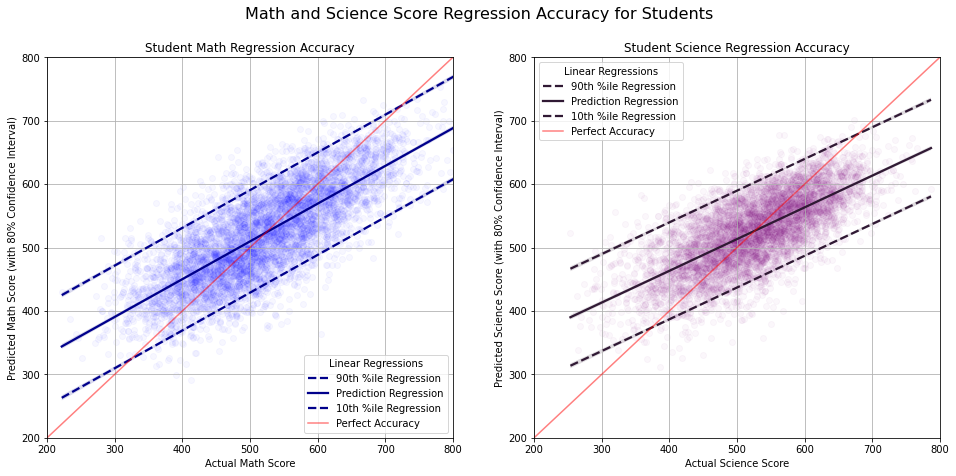

In [301]:
# visualize the regression models

# create a figure on which to display the visualizations
plt.figure(figsize=(16,7))
# put a title on the entire image
plt.suptitle('Math and Science Score Regression Accuracy for Students', fontsize=16)
# set up the first subplot
plt.subplot(121)
# plot the 90th percentile best-fit line
sns.regplot(x=y_test_stud_math, y=pred_CI_stud_math.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
# plot the actual vs. predicted values (scatter plot) along with the best-fit line
sns.regplot(x=y_test_stud_math, y=pred_stud_math, scatter_kws={'alpha':0.03, 'color':'blue'}, line_kws={'color':'#00008B'});
# plot the 10th percentile best-fit line
sns.regplot(x=y_test_stud_math, y=pred_CI_stud_math.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
# create a range of scores from 200,800
x=np.arange(200,810,10)
# plot the range of scores to represent 100% accuracy
plt.plot(x,x,color='#FF0000',alpha=0.5);
# create a legend to identify each line on the plot
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
# label the specific subplot
plt.title('Student Math Regression Accuracy')
# label the x-axis
plt.xlabel('Actual Math Score')
# label the y-axis
plt.ylabel('Predicted Math Score (with 80% Confidence Interval)')
# put a grid on the graph
plt.grid(True)
# limit the graph to valid x-values
plt.xlim(200,800);
# limit the graph to valid y-values
plt.ylim(200,800)
# set up the second subplot
plt.subplot(122)
# plot the 90th percentile best-fit line
sns.regplot(x=y_test_stud_sci, y=pred_CI_stud_sci.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
# plot the actual vs. predicted values (scatter plot) along with the best-fit line
sns.regplot(x=y_test_stud_sci, y=pred_stud_sci, scatter_kws={'alpha':0.03, 'color':'purple'}, line_kws={'color':'#301934'});
# plot the 10th percentile best-fit line
sns.regplot(x=y_test_stud_sci, y=pred_CI_stud_sci.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
# create a range of scores from 200,800
x=np.arange(200,810,10)
# plot the range of scores to represent 100% accuracy
plt.plot(x,x,color='#FF0000',alpha=0.5);
# create a legend to identify each line on the plot
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
# label the specific subplot
plt.title('Student Science Regression Accuracy')
# label the x-axis
plt.xlabel('Actual Science Score')
# label the y-axis
plt.ylabel('Predicted Science Score (with 80% Confidence Interval)')
# put a grid on the graph
plt.grid(True)
# limit the graph to valid x-values
plt.xlim(200,800);
# limit the graph to valid y-values
plt.ylim(200,800);

#### Evaluation Summary
Both math and science models accounted for 50-59% of the variation in average test scores between students. This was adequate considering that school and teacher variables were not included in the student regression model; therefore, it would be nearly impossible for one of the models to account for all variables contributing to the achievement of a student.

Both sets of 80% confidence intervals achieved the appropriate accuracy. This means that ranges of assessment scores generated by the model are accurate for approximately 80% of the data. The other 20% of the data are not captured due to being unique or unlikely results. For example, most of the students score around 500, so it is difficult to generate representative models for students who are unique performers on the assessments and score closer to 300 or 700 (the relative extremes, far from their peers).

### School Score Regression Models

In [302]:
# investigate possible sources of regression inputs in the school dataset
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'language', 'disc_prob_score', 'acad_emph_score',
       'math_shortage_score', 'sci_shortage_score', 'acad_hours', 'disc_prob',
       'acad_emph', 'math_shortage', 'sci_shortage', 'socio_background',
       'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg', 'mdat_avg', 'mgeo_avg',
       'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg', 'sbio_avg', 'sche_avg',
       'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [303]:
# convert IDCNTRY to string so that it is not treated as "ordered" data
school['IDCNTRY'] = school['IDCNTRY'].astype(str)

In [304]:
# select the subset of characteristics for the regression
school_sub_set = school[['IDCNTRY', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg']].dropna()

In [305]:
# separate the inputs in the X matrix
X_sch = school_sub_set[['IDCNTRY', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage','socio_background']]

# create the X matrix with dummy numerical variables for string objects
X_sch = pd.get_dummies(data=X_sch, drop_first=True)
X_sch.head()

acad_hours  IDCNTRY_250  IDCNTRY_268  IDCNTRY_376  IDCNTRY_380  \
0      1600.0            0            0            0            0   
1      1770.0            0            0            0            0   
2      1200.0            0            0            0            0   
3      1068.0            0            0            0            0   
4      1638.0            0            0            0            0   

   IDCNTRY_392  IDCNTRY_440  IDCNTRY_620  IDCNTRY_792  IDCNTRY_926  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   disc_prob_Minor Problems  disc_prob_Moderate to Severe Problems  \
0                         0                                      0   
1                         0                                      0   
2                         0                                      0   
3                         0                                      0   
4                         0                                      0   

   acad_emph_Medium Emphasis  acad_emph_Very High Emphasis  \
0                          0                             1   
1                          0                             0   
2                          0                             0   
3                          1                             0   
4                          1                             0   

   math_shortage_Affected A Lot  math_shortage_Not Affected  \
0                             1                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   

   sci_shortage_Affected A Lot  sci_shortage_Not Affected  \
0                            1                          0   
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                            0                          0   

   socio_background_More Disadvantaged  \
0                                    0   
1                                    0   
2                                    1   
3                                    0   
4                                    1   

   socio_background_Neither More Affluent nor More Disadvantaged  
0                                                  1              
1                                                  1              
2                                                  0              
3                                                  1              
4                                                  0

In [306]:
# create the output matrix for the math scores
Y_sch_math = school_sub_set['mmat_avg']
# create the output matrix for the science scores
Y_sch_sci = school_sub_set['ssci_avg']

In [307]:
# split the input and output matrices into training and testing sets
X_train_sch_math, X_test_sch_math, y_train_sch_math, y_test_sch_math = train_test_split(X_sch, Y_sch_math, test_size=0.4, random_state=101)
X_train_sch_sci, X_test_sch_sci, y_train_sch_sci, y_test_sch_sci = train_test_split(X_sch, Y_sch_sci, test_size=0.4, random_state=101)

# print out the sizes of the respective sets for comparison
print(X_train_sch_math.shape)
print(X_test_sch_math.shape)
print(y_train_sch_math.shape)
print(y_test_sch_math.shape)

(807, 20)
(538, 20)
(807,)
(538,)


In [308]:
# add constants so that the input matrices work with the statsmodels linear regression
X_train_sch_math = sm.add_constant(X_train_sch_math)
X_train_sch_sci = sm.add_constant(X_train_sch_sci)

# fit the trianing data with a statsmodel linear regression
ls_sch_math = sm.OLS(y_train_sch_math, X_train_sch_math).fit()
ls_sch_sci = sm.OLS(y_train_sch_sci, X_train_sch_sci).fit()

# display the summaries of the respective models
print(ls_sch_math.summary())
print(ls_sch_sci.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     30.31
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.07e-83
Time:                        21:22:25   Log-Likelihood:                -4258.9
No. Observations:                 807   AIC:                             8560.
Df Residuals:                     786   BIC:                             8658.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [309]:
## MATH
# add a constant term to the test matrix to make it compliant with the model
x_matrix_sch_math = sm.add_constant(X_test_sch_math)
# use the model to make predictions for all data in the test inputs
pred_sch_math = ls_sch_math.predict(x_matrix_sch_math)
# use get_prediction method to gather more data about predictions
pred_CI_sch_math = ls_sch_math.get_prediction(x_matrix_sch_math)
# use the get_predictions model to construct an 80% confidence interval for the predictions
pred_CI_sch_math = pred_CI_sch_math.summary_frame(alpha=0.20)

## SCIENCE
# add a constant term to the test matrix to make it compliant with the model
x_matrix_sch_sci = sm.add_constant(X_test_sch_sci)
# use the model to make predictions for all data in the test inputs
pred_sch_sci = ls_sch_sci.predict(x_matrix_sch_sci)
# use get_prediction method to gather more data about predictions
pred_CI_sch_sci = ls_sch_sci.get_prediction(x_matrix_sch_sci)
# use the get_predictions model to construct an 80% confidence interval for the predictions
pred_CI_sch_sci = pred_CI_sch_sci.summary_frame(alpha=0.20)

### Evaluate School Score Regression Models

In [310]:
## MATH
# merge the actual student scores with the lower and upper bounds and mean of the predictions
results_sch_math = pd.merge(school[['mmat_avg']],pred_CI_sch_math[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
# create a column that documents if the true score is capture within the confidence interval
results_sch_math['capture'] = ((results_sch_math['mmat_avg'] >= results_sch_math['obs_ci_lower']).astype(int)\
                                *(results_sch_math['mmat_avg'] <= results_sch_math['obs_ci_upper']).astype(int)).astype(bool)
# calculate the % of true scores that are captured by the 80% confidence interval
cap_rate_sch_math = results_sch_math['capture'].sum()/results_sch_math.shape[0]

## SCIENCE
# merge the actual student scores with the lower and upper bounds and mean of the predictions
results_sch_sci = pd.merge(school[['ssci_avg']],pred_CI_sch_sci[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
# create a column that documents if the true score is capture within the confidence interval
results_sch_sci['capture'] = ((results_sch_sci['ssci_avg'] >= results_sch_sci['obs_ci_lower']).astype(int)\
                                *(results_sch_sci['ssci_avg'] <= results_sch_sci['obs_ci_upper']).astype(int)).astype(bool)
# calculate the % of true scores that are captured by the 80% confidence interval
cap_rate_sch_sci = results_sch_sci['capture'].sum()/results_sch_sci.shape[0]

# display the capture rate for each model
print('School Math Regression\nConfidence Interval Capture Rate = {:.3f}\n\
School Science Regression\nConfidence Interval Capture Rate = {:.3f}'.format(cap_rate_stud_math, cap_rate_stud_sci))

School Math Regression
Confidence Interval Capture Rate = 0.810
School Science Regression
Confidence Interval Capture Rate = 0.810


In [311]:
results_sch_math.head(1)

mmat_avg  obs_ci_lower        mean  obs_ci_upper  capture
0  426.441591     443.28275  507.562682    571.842614    False

In [312]:
results_sch_sci.head(1)

ssci_avg  obs_ci_lower        mean  obs_ci_upper  capture
0  446.392404    459.694698  519.053689     578.41268    False

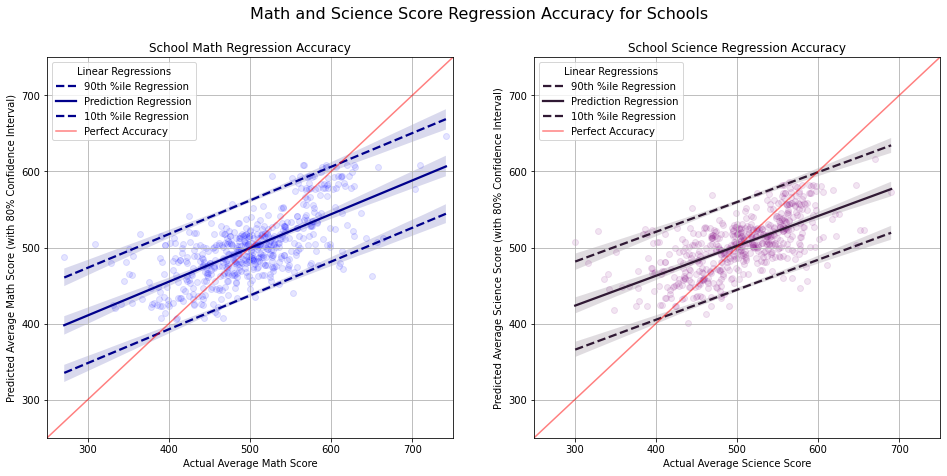

In [313]:
# visualize the regression models

# create a figure on which to display the visualizations
plt.figure(figsize=(16,7))
# put a title on the entire image
plt.suptitle('Math and Science Score Regression Accuracy for Schools', fontsize=16)
# set up the first subplot
plt.subplot(121)
# plot the 90th percentile best-fit line
sns.regplot(x=y_test_sch_math, y=pred_CI_sch_math.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
# plot the actual vs. predicted values (scatter plot) along with the best-fit line
sns.regplot(x=y_test_sch_math, y=pred_sch_math, scatter_kws={'alpha':0.1, 'color':'blue'}, line_kws={'color':'#00008B'});
# plot the 10th percentile best-fit line
sns.regplot(x=y_test_sch_math, y=pred_CI_sch_math.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
# create a range of scores from 200,800
x=np.arange(200,810,10)
# plot the range of scores to represent 100% accuracy
plt.plot(x,x,color='#FF0000',alpha=0.5);
# create a legend to identify each line on the plot
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
# label the specific subplot
plt.title('School Math Regression Accuracy')
# label the x-axis
plt.xlabel('Actual Average Math Score')
# label the y-axis
plt.ylabel('Predicted Average Math Score (with 80% Confidence Interval)')
# put a grid on the graph
plt.grid(True)
# limit the graph to valid x-values
plt.xlim(250,750);
# limit the graph to valid y-values
plt.ylim(250,750)
# set up the second subplot
plt.subplot(122)
# plot the 90th percentile best-fit line
sns.regplot(x=y_test_sch_sci, y=pred_CI_sch_sci.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
# plot the actual vs. predicted values (scatter plot) along with the best-fit line
sns.regplot(x=y_test_sch_sci, y=pred_sch_sci, scatter_kws={'alpha':0.1, 'color':'purple'}, line_kws={'color':'#301934'});
# plot the 10th percentile best-fit line
sns.regplot(x=y_test_sch_sci, y=pred_CI_sch_sci.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
# create a range of scores from 200,800
x=np.arange(200,810,10)
# plot the range of scores to represent 100% accuracy
plt.plot(x,x,color='#FF0000',alpha=0.5);
# create a legend to identify each line on the plot
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
# label the specific subplot
plt.title('School Science Regression Accuracy')
# label the x-axis
plt.xlabel('Actual Average Science Score')
# label the y-axis
plt.ylabel('Predicted Average Science Score (with 80% Confidence Interval)')
# put a grid on the graph
plt.grid(True)
# limit the graph to valid x-values
plt.xlim(250,750);
# limit the graph to valid y-values
plt.ylim(250,750);

#### Evaluation Summary
Both math and science models accounted for 63-66% of the variation in average test scores between schools. This was adequate considering the small number of variables used for each school in addition to the fact that student and teacher variables were not included in the school regression model; therefore, it would be nearly impossible for one of the models to account for all variables contributing to the average achievement of a school.

Both sets of 80% confidence intervals achieved the appropriate accuracy. This means that ranges of assessment scores generated by the model are accurate for approximately 80% of the data. The other 20% of the data are not captured due to being unique or unlikely results. For example, most of the schools score around 500, so it is difficult to generate representative models for schools who are unique performers on the assessments and score closer to 350 or 650 (the relative extremes, far from their peers) or schools that perform much higher or lower than expected (and the reasons are not captured in the survey).

### Math Teacher Score Regression Models

In [314]:
# investigate possible sources of regression inputs in the math teacher dataset
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [315]:
# convert IDCNTRY to string so that it is not treated as "ordered" data
math_teach['IDCNTRY'] = math_teach['IDCNTRY'].astype(str)

In [316]:
# select the subset of characteristics for the regression
math_teach_sub_set = math_teach[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','mmat_avg']].dropna()

In [317]:
# separate the inputs in the X matrix
X_math_teach = math_teach_sub_set[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]

# create the X matrix with dummy numerical variables for string objects
X_math_teach = pd.get_dummies(data=X_math_teach, drop_first=True)
X_math_teach.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
3         34.0                2.0                 3.0              2.0   
15        32.0                3.0                 3.0              2.0   
16        10.0                3.0                 3.0              3.0   
17        10.0                2.0                 2.0              2.0   
31        33.0                3.0                 3.0              3.0   

    style_discussion  style_link_previous  style_procedures  \
3                2.0                  3.0               3.0   
15               2.0                  3.0               3.0   
16               3.0                  3.0               3.0   
17               2.0                  3.0               2.0   
31               3.0                  3.0               3.0   

    style_express_ideas  class_time  stud_explain_new  stud_explain_solve  \
3                   3.0       270.0               2.0                 2.0   
15                  3.0       270.0               3.0                 3.0   
16                  3.0       360.0               3.0                 3.0   
17                  2.0       270.0               3.0                 2.0   
31                  3.0       270.0               3.0                 2.0   

    stud_memorize  stud_practice  stud_apply  stud_class_work  \
3             1.0            1.0         1.0              2.0   
15            1.0            3.0         3.0              3.0   
16            3.0            3.0         3.0              3.0   
17            1.0            3.0         3.0              3.0   
31            3.0            2.0         2.0              3.0   

    stud_heterogeneous  stud_homogenous  computer_class  hw_freq  hw_time  \
3                  2.0              2.0             1.0      1.0     30.0   
15                 3.0              3.0             0.0      1.0     30.0   
16                 3.0              3.0             1.0      1.0     30.0   
17                 2.0              3.0             0.0      2.0     15.0   
31                 2.0              2.0             1.0      4.0     15.0   

    hw_self_correct  hw_graded  assess_observe  assess_ask  assess_short  \
3               2.0        1.0             2.0         2.0           1.0   
15              2.0        2.0             2.0         2.0           2.0   
16              1.0        2.0             2.0         2.0           2.0   
17              0.0        1.0             1.0         1.0           2.0   
31              2.0        2.0             2.0         2.0           2.0   

    assess_long  assess_projects  school_acad_focus_score  \
3           1.0              2.0                  7.30893   
15          0.0              0.0                 12.15607   
16          2.0              2.0                 17.78068   
17          2.0              0.0                 10.05102   
31          0.0              1.0                  9.14714   

    limited_by_needs_score  school_safe_score  job_satisfaction_score  \
3                 11.28828           11.14932                11.74559   
15                12.67245           11.14932                11.74559   
16                10.69865           13.87035                11.74559   
17                10.69865           12.56459                11.74559   
31                10.14509           10.07263                11.74559   

    study_stem  study_edu  IDCNTRY_250  IDCNTRY_268  IDCNTRY_376  IDCNTRY_380  \
3            1          1            0            0            0            0   
15           1          1            0            0            0            0   
16           1          1            0            0            0            0   
17           1          0            0            0            0            0   
31           1          1            0            0            0            0   

    IDCNTRY_392  IDCNTRY_440  IDCNTRY_620  IDCNTRY_792  IDCNTRY_926  \
3             0            0            0 

In [318]:
# create the output matrix for the math scores
Y_math_teach = math_teach_sub_set['mmat_avg']

In [319]:
# split the input and output matrices into training and testing sets
X_train_math_teach, X_test_math_teach, y_train_math_teach, y_test_math_teach = train_test_split(X_math_teach, Y_math_teach, test_size=0.4, random_state=101)

# print out the sizes of the respective sets for comparison
print(X_train_math_teach.shape)
print(X_test_math_teach.shape)
print(y_train_math_teach.shape)
print(y_test_math_teach.shape)

(308, 50)
(206, 50)
(308,)
(206,)


In [320]:
# add constants so that the input matrices work with the statsmodels linear regression
X_train_math_teach = sm.add_constant(X_train_math_teach)

# fit the trianing data with a statsmodel linear regression
ls_math_teach = sm.OLS(y_train_math_teach, X_train_math_teach).fit()

# display the summaries of the respective models
print(ls_math_teach.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     6.156
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           3.78e-23
Time:                        21:22:26   Log-Likelihood:                -1635.6
No. Observations:                 308   AIC:                             3373.
Df Residuals:                     257   BIC:                             3563.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [321]:
# add a constant term to the test matrix to make it compliant with the model
x_matrix_math_teach = sm.add_constant(X_test_math_teach)
# use the model to make predictions for all data in the test inputs
pred_math_teach = ls_math_teach.predict(x_matrix_math_teach)
# use get_prediction method to gather more data about predictions
pred_CI_math_teach = ls_math_teach.get_prediction(x_matrix_math_teach)
# use the get_predictions model to construct an 80% confidence interval for the predictions
pred_CI_math_teach = pred_CI_math_teach.summary_frame(alpha=0.20)

### Evaluate Math Teacher Score Regression Models

In [322]:
# merge the actual student scores with the lower and upper bounds and mean of the predictions
results_math_teach = pd.merge(math_teach[['mmat_avg']],pred_CI_math_teach[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
# create a column that documents if the true score is capture within the confidence interval
results_math_teach['capture'] = ((results_math_teach['mmat_avg'] >= results_math_teach['obs_ci_lower']).astype(int)\
                                *(results_math_teach['mmat_avg'] <= results_math_teach['obs_ci_upper']).astype(int)).astype(bool)
# calculate the % of true scores that are captured by the 80% confidence interval
cap_rate_math_teach = results_math_teach['capture'].sum()/results_math_teach.shape[0]

# display the capture rate for each model
print('Math Teacher Regression\nConfidence Interval Capture Rate = {:.3f}'.format(cap_rate_math_teach))

Math Teacher Regression
Confidence Interval Capture Rate = 0.786


In [323]:
results_math_teach.head(1)

mmat_avg  obs_ci_lower        mean  obs_ci_upper  capture
16  445.604281    452.192007  528.086929    603.981851    False

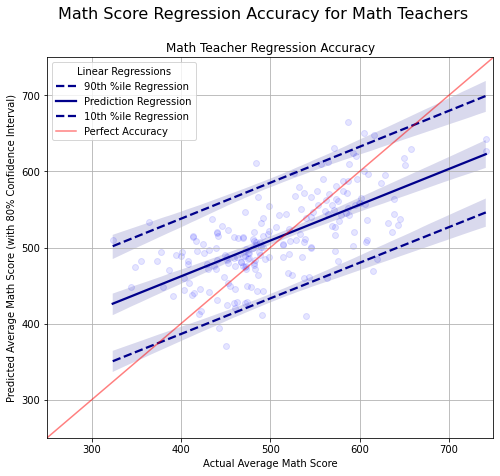

In [324]:
# visualize the regression models

# create a figure on which to display the visualizations
plt.figure(figsize=(8,7))
# put a title on the entire image
plt.suptitle('Math Score Regression Accuracy for Math Teachers', fontsize=16)
# plot the 90th percentile best-fit line
sns.regplot(x=y_test_math_teach, y=pred_CI_math_teach.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
# plot the actual vs. predicted values (scatter plot) along with the best-fit line
sns.regplot(x=y_test_math_teach, y=pred_math_teach, scatter_kws={'alpha':0.1, 'color':'blue'}, line_kws={'color':'#00008B'});
# plot the 10th percentile best-fit line
sns.regplot(x=y_test_math_teach, y=pred_CI_math_teach.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
# create a range of scores from 200,800
x=np.arange(200,810,10)
# plot the range of scores to represent 100% accuracy
plt.plot(x,x,color='#FF0000',alpha=0.5);
# create a legend to identify each line on the plot
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
# label the specific plot
plt.title('Math Teacher Regression Accuracy')
# label the x-axis
plt.xlabel('Actual Average Math Score')
# label the y-axis
plt.ylabel('Predicted Average Math Score (with 80% Confidence Interval)')
# put a grid on the graph
plt.grid(True)
# limit the graph to valid x-values
plt.xlim(250,750);
# limit the graph to valid y-values
plt.ylim(250,750);

#### Evaluation Summary
The math teacher model accounted for ~50% of the variation in average test scores between different math teachers. This was adequate considering the small number of students sampled from each teacher in addition to the fact that student and school variables were not included in the math teacher regression model; therefore, it would be nearly impossible for one of the models to account for all variables contributing to the average achievement of a math teacher.

The set of 80% confidence intervals achieved the appropriate accuracy. This means that ranges of assessment scores generated by the model are accurate for approximately 80% of the data. The other 20% of the data are not captured due to being unique or unlikely results. For example, most of the math teachers score around 500, so it is difficult to generate representative models for teachers who are unique performers on the assessments and score closer to 350 or 650 (the relative extremes, far from their peers) or teachers that perform much higher or lower than expected (and the reasons are not captured in the survey).

### Science Teacher Score Regression Models

In [325]:
# investigate possible sources of regression inputs in the science teacher dataset
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [326]:
# convert IDCNTRY to string so that it is not treated as "ordered" data
sci_teach['IDCNTRY'] = sci_teach['IDCNTRY'].astype(str)

In [327]:
# select the subset of characteristics for the regression
sci_teach_sub_set = sci_teach[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','ssci_avg']].dropna()

In [328]:
# separate the inputs in the X matrix
X_sci_teach = sci_teach_sub_set[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]

# create the X matrix with dummy numerical variables for string objects
X_sci_teach = pd.get_dummies(data=X_sci_teach, drop_first=True)
X_sci_teach.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
1          6.0                2.0                 2.0              1.0   
8          1.0                3.0                 3.0              3.0   
9         15.0                3.0                 3.0              3.0   
11        11.0                3.0                 3.0              3.0   
19        15.0                1.0                 1.0              0.0   

    style_discussion  style_link_previous  style_procedures  \
1                2.0                  3.0               1.0   
8                1.0                  3.0               3.0   
9                3.0                  3.0               3.0   
11               3.0                  3.0               3.0   
19               1.0                  2.0               3.0   

    style_express_ideas  class_time  stud_explain_new  stud_observe_phenom  \
1                   2.0       180.0               1.0                  0.0   
8                   3.0       180.0               2.0                  2.0   
9                   3.0       180.0               3.0                  3.0   
11                  3.0       180.0               3.0                  2.0   
19                  3.0        45.0               3.0                  1.0   

    stud_demo_exp  stud_plan_exp  stud_conduct_exp  stud_present  \
1             1.0            1.0               1.0           1.0   
8             1.0            2.0               2.0           2.0   
9             3.0            1.0               1.0           2.0   
11            2.0            3.0               3.0           2.0   
19            1.0            0.0               1.0           1.0   

    stud_interpret  stud_use_evid  stud_read_text  stud_memorize  \
1              1.0            1.0             2.0            1.0   
8              2.0            1.0             2.0            1.0   
9              2.0            3.0             3.0            3.0   
11             2.0            2.0             2.0            2.0   
19             2.0            1.0             2.0            1.0   

    stud_formulas  stud_field  stud_heterogeneous  stud_homogenous  \
1             2.0         0.0                 2.0              1.0   
8             1.0         0.0                 2.0              2.0   
9             2.0         1.0                 1.0              1.0   
11            2.0         2.0                 3.0              1.0   
19            2.0         1.0                 1.0              1.0   

    computer_class  hw_freq  hw_time  hw_self_correct  hw_graded  \
1              0.0      1.0     30.0              2.0        2.0   
8              0.0      2.0     60.0              1.0        2.0   
9              0.0      2.0     30.0              1.0        2.0   
11             1.0      1.0     30.0              2.0        1.0   
19             1.0      1.0     30.0              1.0        1.0   

    assess_observe  assess_ask  assess_short  assess_long  assess_projects  \
1              2.0         2.0           1.0          2.0              0.0   
8              2.0         2.0           1.0          1.0              1.0   
9              2.0         2.0           1.0          1.0              1.0   
11             2.0         2.0           2.0          1.0              2.0   
19             1.0         2.0           1.0          1.0              1.0   

    school_acad_focus_score  limited_by_needs_score  school_safe_score  \
1                  11.55005                 9.11668            8.39631   
8                  10.95225                 6.01647            8.39631   
9                  10.65284                 9.11668            8.78337   
11                 11.55005                11.93195            9.61153   
19                  8.54651                11.93195           10.07263   

    job_satisfaction_score  study_stem  study_edu  IDCNTRY_250  IDCNTRY_268  \
1                  9.76930           1          1            0        

In [329]:
# create the output matrix for the science scores
Y_sci_teach = sci_teach_sub_set['ssci_avg']

In [330]:
# split the input and output matrices into training and testing sets
X_train_sci_teach, X_test_sci_teach, y_train_sci_teach, y_test_sci_teach = train_test_split(X_sci_teach, Y_sci_teach, test_size=0.4, random_state=101)

# print out the sizes of the respective sets for comparison
print(X_train_sci_teach.shape)
print(X_test_sci_teach.shape)
print(y_train_sci_teach.shape)
print(y_test_sci_teach.shape)

(648, 56)
(432, 56)
(648,)
(432,)


In [331]:
# add constants so that the input matrices work with the statsmodels linear regression
X_train_sci_teach = sm.add_constant(X_train_sci_teach)

# fit the trianing data with a statsmodel linear regression
ls_sci_teach = sm.OLS(y_train_sci_teach, X_train_sci_teach).fit()

# display the summaries of the respective models
print(ls_sci_teach.summary())

                            OLS Regression Results                            
Dep. Variable:               ssci_avg   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     8.327
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.02e-45
Time:                        21:22:27   Log-Likelihood:                -3368.0
No. Observations:                 648   AIC:                             6850.
Df Residuals:                     591   BIC:                             7105.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [332]:
# add a constant term to the test matrix to make it compliant with the model
x_matrix_sci_teach = sm.add_constant(X_test_sci_teach)
# use the model to make predictions for all data in the test inputs
pred_sci_teach = ls_sci_teach.predict(x_matrix_sci_teach)
# use get_prediction method to gather more data about predictions
pred_CI_sci_teach = ls_sci_teach.get_prediction(x_matrix_sci_teach)
# use the get_predictions model to construct an 80% confidence interval for the predictions
pred_CI_sci_teach = pred_CI_sci_teach.summary_frame(alpha=0.20)

### Evaluate Science Teacher Score Regression Models

In [333]:
# merge the actual student scores with the lower and upper bounds and mean of the predictions
results_sci_teach = pd.merge(sci_teach[['ssci_avg']],pred_CI_sci_teach[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
# create a column that documents if the true score is capture within the confidence interval
results_sci_teach['capture'] = ((results_sci_teach['ssci_avg'] >= results_sci_teach['obs_ci_lower']).astype(int)\
                                *(results_sci_teach['ssci_avg'] <= results_sci_teach['obs_ci_upper']).astype(int)).astype(bool)
# calculate the % of true scores that are captured by the 80% confidence interval
cap_rate_sci_teach = results_sci_teach['capture'].sum()/results_sci_teach.shape[0]

# display the capture rate for each model
print('Science Teacher Regression\nConfidence Interval Capture Rate = {:.3f}'.format(cap_rate_sci_teach))

Science Teacher Regression
Confidence Interval Capture Rate = 0.808


In [334]:
results_sci_teach.head(1)

ssci_avg  obs_ci_lower       mean  obs_ci_upper  capture
1  453.555063    418.884881  480.54021    542.195539     True

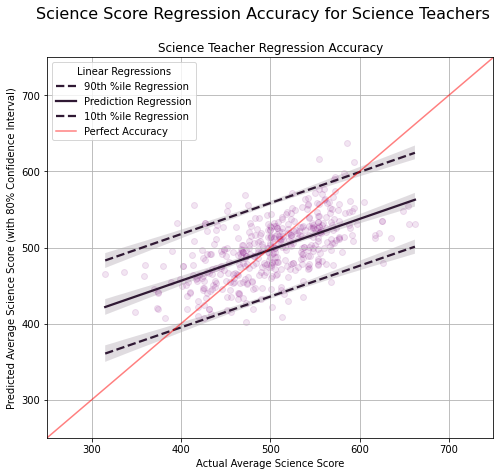

In [335]:
# visualize the regression models

# create a figure on which to display the visualizations
plt.figure(figsize=(8,7))
# put a title on the entire image
plt.suptitle('Science Score Regression Accuracy for Science Teachers', fontsize=16)
# plot the 90th percentile best-fit line
sns.regplot(x=y_test_sci_teach, y=pred_CI_sci_teach.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
# plot the actual vs. predicted values (scatter plot) along with the best-fit line
sns.regplot(x=y_test_sci_teach, y=pred_sci_teach, scatter_kws={'alpha':0.1, 'color':'purple'}, line_kws={'color':'#301934'});
# plot the 10th percentile best-fit line
sns.regplot(x=y_test_sci_teach, y=pred_CI_sci_teach.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
# create a range of scores from 200,800
x=np.arange(200,810,10)
# plot the range of scores to represent 100% accuracy
plt.plot(x,x,color='#FF0000',alpha=0.5);
# create a legend to identify each line on the plot
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
# label the specific plot
plt.title('Science Teacher Regression Accuracy')
# label the x-axis
plt.xlabel('Actual Average Science Score')
# label the y-axis
plt.ylabel('Predicted Average Science Score (with 80% Confidence Interval)')
# put a grid on the graph
plt.grid(True)
# limit the graph to valid x-values
plt.xlim(250,750);
# limit the graph to valid y-values
plt.ylim(250,750);

#### Evaluation Summary
The science teacher model accounted for ~45% of the variation in average test scores between different science teachers. This was adequate considering the small number of students sampled from each teacher in addition to the fact that student and school variables were not included in the science teacher regression model; therefore, it would be nearly impossible for one of the models to account for all variables contributing to the average achievement of a science teacher. In addition to the difficulties, many students are exposed to multiple science teachers and courses, which may make it even more difficult to achieve accurate predictions.

The set of 80% confidence intervals achieved the appropriate accuracy. This means that ranges of assessment scores generated by the model are accurate for approximately 80% of the data. The other 20% of the data are not captured due to being unique or unlikely results. For example, most of the science teachers score around 500, so it is difficult to generate representative models for teachers who are unique performers on the assessments and score closer to 350 or 650 (the relative extremes, far from their peers) or teachers that perform much higher or lower than expected (and the reasons are not captured in the survey).

[Return to Top of Data Modeling](#data_modeling)

<div id='classification_models'></div>

## School Socio-Background Classification Models

In [336]:
def display_results(cv, y_test, y_pred):
    '''
    INPUT:
    cv - the fitted GridSearchCV classification model
    y_test - array of the correct labels for the test set
    y_pred - array of the predicted labels for the test set
    
    OUTPUT:
    None
    '''
    
    # gathers all unique labels in the prediction set
    labels = np.unique(y_pred)
    # constructs a confusion matrix for the model
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    # calculate the accuracy of the model
    accuracy = (y_pred == y_test).mean()

    # prints the unique labels
    print("Labels:", labels)
    # prints the confusion matrix
    print("Confusion Matrix:\n", confusion_mat)
    # prints the accuracy of the model
    print("Accuracy:", accuracy)
    # prints the parameters for the optimum result from GridSearchCV
    print("\nBest Parameters:", cv.best_params_)

In [337]:
# investigate the distribution of the socio-background values
school['socio_background'].value_counts()

More Affluent                                   529
More Disadvantaged                              483
Neither More Affluent nor More Disadvantaged    441
Name: socio_background, dtype: int64

In [338]:
# investigate possible sources of classification inputs in the school dataset
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'language', 'disc_prob_score', 'acad_emph_score',
       'math_shortage_score', 'sci_shortage_score', 'acad_hours', 'disc_prob',
       'acad_emph', 'math_shortage', 'sci_shortage', 'socio_background',
       'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg', 'mdat_avg', 'mgeo_avg',
       'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg', 'sbio_avg', 'sche_avg',
       'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [339]:
# investigate possible sources of classification inputs in the math teacher dataset
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [340]:
# join school data with average teacher data for a more complete school dataset
new_set = school.set_index(['IDCNTRY','IDSCHOOL']).join(math_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']]
                                                        .join(sci_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']], 
                                                              lsuffix="_math", rsuffix="_sci")).dropna()

In [341]:
# reset the index back to numbers
new_set.reset_index(inplace=True)

# convert IDCNTRY to string so that it is not treated as "ordered" data
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)

In [342]:
# separate the inputs in the X matrix
X_socio = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
# create the output matrix for the school sociobackground
y_socio = new_set.socio_background

# print out the sizes of the respective sets for comparison
print(X_socio.shape)
print(y_socio.shape)

(1091, 10)
(1091,)


In [343]:
# split the input and output matrices into training and testing sets
X_train_socio, X_test_socio, y_train_socio, y_test_socio = train_test_split(X_socio, y_socio, test_size=0.2, random_state=42)

In [344]:
# instantiate the base model for RandomForest
clf_socio = RandomForestClassifier(random_state=0, n_jobs=-1)

# specify parameters for grid search
parameters_socio = {
    'bootstrap':[True, False],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [20, 30, 50]
}

# create grid search object
cv_socio = GridSearchCV(clf_socio, param_grid=parameters_socio)

# fit the grid search object to the training data
cv_socio.fit(X_train_socio, y_train_socio)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [20, 30, 50]})

In [345]:
# convert IDCNTRY to int so that it is compliant with XGBOOST
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(int)
# separate the inputs in the X matrix
X_xgb = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
# create the output matrix for the school sociobackground
y_xgb = new_set.socio_background
# split the input and output matrices into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [346]:
# instantiate the base model for XGBoost
xgb = XGBClassifier(n_jobs=-1)

# specify parameters for grid search
parameters_xgb = {
    'n_estimators': [20, 30, 50],
    'max_depth': [10, 25, None],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'booster':['gbtree','gblinear','dart'],
    'gamma':[0.3, 0.5, 0.7],
    'subsample':[0.3, 0.4, 0.5]
}

# create grid search object
cv_xgb = GridSearchCV(xgb, param_grid=parameters_xgb, n_jobs=-1)

# fit the classifier with the training data
cv_xgb.fit(X_train_xgb,y_train_xgb)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:27:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     n...None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
        

In [347]:
# convert IDCNTRY to string so that it is not treated as "ordered" data
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)
# separate the inputs in the X matrix
X_knn = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
# create the output matrix for the school sociobackground
y_knn = new_set.socio_background
# split the input and output matrices into training and testing sets
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

In [348]:
# instantiate the base model for K-NearestNeighbors
knn = KNeighborsClassifier(n_jobs=-1)

# specify parameters for grid search
parameters_knn = {
    'n_neighbors': [5, 9, 13, 17],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'leaf_size': [5, 12, 30, 50],
    'weights':['distance','uniform'],
    'p':[1, 2, 3, 4, 5]
}

# create grid search object
cv_knn = GridSearchCV(knn, param_grid=parameters_knn, n_jobs=-1)

# fit the classifier with the training data
cv_knn.fit(X_train_knn, y_train_knn)

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [5, 12, 30, 50],
                         'n_neighbors': [5, 9, 13, 17], 'p': [1, 2, 3, 4, 5],
                         'weights': ['distance', 'uniform']})

### Evaluate School Socio-Background Classification Models

In [349]:
# create predictions for the optimum RandomForest classifier
y_pred_socio = cv_socio.predict(X_test_socio)

# display results for the optimum RandomForest classifier
display_results(cv_socio, y_test_socio, y_pred_socio)

Labels: ['More Affluent' 'More Disadvantaged'
 'Neither More Affluent nor More Disadvantaged']
Confusion Matrix:
 [[53  8 20]
 [15 39 21]
 [30 12 21]]
Accuracy: 0.5159817351598174

Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 50}


In [350]:
# create predictions for the optimum XGBoost classifier
y_pred_xgb = cv_xgb.predict(X_test_xgb)
    
# display results for the optimum XGBoost classifier
display_results(cv_xgb, y_test_xgb, y_pred_xgb)

Labels: ['More Affluent' 'More Disadvantaged'
 'Neither More Affluent nor More Disadvantaged']
Confusion Matrix:
 [[57 10 14]
 [12 44 19]
 [27 15 21]]
Accuracy: 0.5570776255707762

Best Parameters: {'booster': 'dart', 'gamma': 0.7, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 20, 'subsample': 0.5}


In [351]:
# create predictions for the optimum K-NearestNeighbors classifier
y_pred_knn = cv_knn.predict(X_test_knn)
    
# display results for the optimum K-NearestNeighbors classifier
display_results(cv_knn, y_test_knn, y_pred_knn)

Labels: ['More Affluent' 'More Disadvantaged'
 'Neither More Affluent nor More Disadvantaged']
Confusion Matrix:
 [[47 18 16]
 [15 41 19]
 [20 24 19]]
Accuracy: 0.4885844748858447

Best Parameters: {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 9, 'p': 4, 'weights': 'distance'}


In [352]:
# compare similarity between the RandomForest and XGBoost classifier predictions
(y_pred_socio == y_pred_xgb).mean()

0.776255707762557

In [353]:
# compare similarity between the K-NearestNeighbors and XGBoost classifier predictions
(y_pred_knn == y_pred_xgb).mean()

0.4977168949771689

In [354]:
# compare similarity between the RandomForest and K-NearestNeighbors classifier predictions
(y_pred_knn == y_pred_socio).mean()

0.4657534246575342

In [355]:
# construct dataframe to display a sample of the results of the three predictions
output = pd.DataFrame()
output['Expected Output'] = y_test_socio
output['RF Output'] = y_pred_socio
output['XGB Output'] = y_pred_xgb
output['KNN Output'] = y_pred_knn
output.head(20)

Expected Output  \
852   Neither More Affluent nor More Disadvantaged   
941   Neither More Affluent nor More Disadvantaged   
1085                            More Disadvantaged   
1006                            More Disadvantaged   
761                                  More Affluent   
290                                  More Affluent   
398   Neither More Affluent nor More Disadvantaged   
192                             More Disadvantaged   
289                                  More Affluent   
887   Neither More Affluent nor More Disadvantaged   
88                              More Disadvantaged   
597   Neither More Affluent nor More Disadvantaged   
773   Neither More Affluent nor More Disadvantaged   
51                                   More Affluent   
260                             More Disadvantaged   
589                                  More Affluent   
568                             More Disadvantaged   
44                                   More Affluent   
716   Neither More Affluent nor More Disadvantaged   
307   Neither More Affluent nor More Disadvantaged   

                                         RF Output  \
852                                  More Affluent   
941   Neither More Affluent nor More Disadvantaged   
1085  Neither More Affluent nor More Disadvantaged   
1006                            More Disadvantaged   
761                                  More Affluent   
290                                  More Affluent   
398                                  More Affluent   
192                             More Disadvantaged   
289                                  More Affluent   
887                                  More Affluent   
88                              More Disadvantaged   
597                                  More Affluent   
773                                  More Affluent   
51                                   More Affluent   
260   Neither More Affluent nor More Disadvantaged   
589                                  More Affluent   
568                                  More Affluent   
44                                   More Affluent   
716                                  More Affluent   
307                             More Disadvantaged   

                                        XGB Output  \
852   Neither More Affluent nor More Disadvantaged   
941   Neither More Affluent nor More Disadvantaged   
1085  Neither More Affluent nor More Disadvantaged   
1006                            More Disadvantaged   
761                                  More Affluent   
290                                  More Affluent   
398                                  More Affluent   
192                             More Disadvantaged   
289                                  More Affluent   
887                                  More Affluent   
88                              More Disadvantaged   
597   Neither More Affluent nor More Disadvantaged   
773                                  More Affluent   
51                              More Disadvantaged   
260   Neither More Affluent nor More Disadvantaged   
589                                  More Affluent   
568                                  More Affluent   
44                                   More Affluent   
716                                  More Affluent   
307                                  More Affluent   

                                        KNN Output  
852                                  More Affluent  
941   Neither More Affluent nor More Disadvantaged  
1085                            More Disadvantaged  
1006                                 More Affluent  
761                                  More Affluent  
290   Neither More Affluent nor More Disadvantaged  
398   Neither More Affluent nor More Disadvantaged  
192                             More Disadvantaged  
289                                  More Affluent  
887                             More Disadvantaged  
88                              More Disadvanta

#### Evaluation Summary
The relatively vague nature of the classifications of school socio-background left some interpretation issues for the models. For example, there are no clear objective boundaries between a classification of "More Affluent" and "Neither More Affluent nor More Disadvantaged", so it is unclear when the model should jump between those two classifications.

In the end, the optimized XGBoost Classifier had the highest accuracy (~56%) and the lowest number of significant errors (misidentifying "More Affluent" as "More Disadvantaged" and vice versa only 22 times out of 240 total test values).

Overall, the model could be improved by including relevant averages for student demographics within each school (immigration and academic language data, home resources) to provide a richer set of inputs on which to base the classification.

[Return to Top of Data Modeling](#data_modeling)

<div id='recommendation_engine'></div>

## Student-Assessment Recommendation Engine

In [356]:
# assess general structure of the student achievement dataset
stud_ach

IDCNTRY  test_book  IDSCHOOL  IDCLASS    IDSTUD language     sex  \
0          152          3      5001   500101  50010101  Spanish  Female   
1          152          4      5001   500101  50010102  Spanish  Female   
2          152          5      5001   500101  50010103  Spanish    Male   
3          152          6      5001   500101  50010104  Spanish    Male   
4          152          7      5001   500101  50010105  Spanish    Male   
...        ...        ...       ...      ...       ...      ...     ...   
37740      792          5      5209   520901  52090116  Turkish  Female   
37741      792          6      5209   520901  52090117  Turkish  Female   
37742      792          8      5209   520901  52090120  Turkish  Female   
37743      792          9      5209   520901  52090121  Turkish  Female   
37744      792         10      5209   520901  52090122  Turkish  Female   

         age  MP52024_val  MP52058_val  MP52125_val  MP52229_val  MP52063_val  \
0      13.33          NaN          NaN          NaN          NaN          NaN   
1      14.00          NaN          NaN          NaN          NaN          NaN   
2      13.92          NaN          NaN          NaN          NaN          NaN   
3      13.83          NaN          NaN          NaN          NaN          NaN   
4      14.00          NaN          NaN          NaN          NaN          NaN   
...      ...          ...          ...          ...          ...          ...   
37740  13.42          NaN          NaN          NaN          NaN          NaN   
37741  13.42          NaN          NaN          NaN          NaN          NaN   
37742  13.33          NaN          NaN          NaN          NaN          NaN   
37743  13.75          NaN          NaN          NaN          NaN          NaN   
37744  13.83          NaN          NaN          NaN          NaN          NaN   

       MP52072_val  MP52146_val  MP52092_val  MP52046_val  MP52083_val  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              NaN          NaN          NaN          NaN          NaN   
...            ...          ...          ...          ...          ...   
37740          NaN          NaN          NaN          NaN          NaN   
37741          NaN          NaN          NaN          NaN          NaN   
37742          NaN          NaN          NaN          NaN          NaN   
37743          NaN          NaN          NaN          NaN          NaN   
37744          NaN          NaN          NaN          NaN          NaN   

       MP52082_val  MP52161_val  MP52418_val  MP72007_val  MP72025_val  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              NaN          NaN          NaN          NaN          NaN   
...            ...          ...          ...          ...          ...   
37740          NaN          NaN          NaN          NaN          NaN   
37741          NaN          NaN          NaN          NaN          NaN   
37742          NaN          NaN          NaN          NaN          NaN   
37743          NaN          NaN          NaN          NaN          NaN   
37744          NaN          NaN          NaN          NaN          NaN   

       MP72017_val  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN  

In [357]:
# concatenate average scores on each item with the number of students who assessed that item
item_values = pd.concat([stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].mean(),stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].count()], axis=1).rename(columns={0:'val',1:'count'})

In [358]:
# drop the "_val" suffix from the index of this table
item_values.index = item_values.reset_index()['index'].apply(lambda x: x[:-4])
# display the new table
item_values

val  count
index                   
MP52024  0.510077   5309
MP52058  0.273981   5077
MP52125  0.476990   5302
MP52229  0.459847   4956
MP52063  0.470241   5259
...           ...    ...
SP72210  0.511615   5295
SP72249  0.431106   5298
SP72323  0.566585   5279
SP72368  0.715254   5310
SP72303  0.340885   4635

[386 rows x 2 columns]

In [359]:
# store the file name for the file containing assessment item information
file_name = 'T19_G8_Item Information/T19_G8_Item Information.xlsx'
# pull relevant information for the math assessment items
math_items = pd.read_excel(file_name, sheet_name='MAT').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]
# pull relevant information for the science assessment items
sci_items = pd.read_excel(file_name, sheet_name='SCI').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]

In [360]:
# create a user-item dataframe where rows are different users, columns are different assessment items, and values are scores
user_item = stud_ach.set_index(['IDCNTRY','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_val' in col]]

In [361]:
# filter the user-item dataframe for valid countries (drop benchmark countries)
user_item = user_item[pd.DataFrame(user_item.index)[0].apply(lambda x: x[0]<1000).values]

In [362]:
# display the user-item dataframe
user_item

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
152     50010101          NaN          NaN          NaN          NaN   
        50010102          NaN          NaN          NaN          NaN   
        50010103          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
792     52090116          NaN          NaN          NaN          NaN   
        52090117          NaN          NaN          NaN          NaN   
        52090120          NaN          NaN          NaN          NaN   
        52090121          NaN          NaN          NaN          NaN   
        52090122          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
152     50010101          NaN          NaN          NaN          NaN   
        50010102          NaN          NaN          NaN          NaN   
        50010103          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
792     52090116          NaN          NaN          NaN          NaN   
        52090117          NaN          NaN          NaN          NaN   
        52090120          NaN          NaN          NaN          NaN   
        52090121          NaN          NaN          NaN          NaN   
        52090122          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
152     50010101          NaN          NaN          NaN          NaN   
        50010102          NaN          NaN          NaN          NaN   
        50010103          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
792     52090116          NaN          NaN          NaN          NaN   
        52090117          NaN          NaN          NaN          NaN   
        52090120          NaN          NaN          NaN          NaN   
        52090121          NaN          NaN          NaN          NaN   
        52090122          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
152     50010101          NaN          NaN          NaN          NaN   
        50010102          NaN          NaN          NaN          NaN   
        50010103          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
792     52090116          NaN          NaN          NaN          NaN   
        52090117          NaN          NaN          NaN          NaN   
        52090120          NaN          NaN          NaN          NaN   
        52090121          NaN          NaN          NaN          NaN   
        52090122          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
152     50010101          NaN          NaN          NaN          NaN   
        50010102          NaN          NaN          Na

In [363]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of most similar users
    
    '''
    # compute similarity of each user to the provided user
    similar_users = user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna()
    # sort by similarity
    similar_users.sort_values(ascending=False, inplace=True)
    # create list of just the ids
    most_similar_users = list(similar_users.index)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [364]:
def get_item_info(item_ids, math_items=math_items, sci_items=sci_items):
    '''
    gathers the info of the test items with given ids
    
    INPUT:
    item_ids - (list) a list of item ids
    math_items - (pandas dataframe) dataframe containing all math item information
    sci_items - (pandas dataframe) dataframe containing all science item information
    
    OUTPUT:
    item_info - (list of lists) a list of item information associated with the list of item ids 
                    (this is identified by the title column)
    '''
    item_info = []
    
    # gathers the info for any item id that is included in the list of test ids
    for item in item_ids:
        # if the item is a Math item (M prefix)
        if item[0] == 'M':
            # find all assessment items matching the item_id
            for match in list(math_items.loc[[_ for _ in math_items.index if item[:7] in _[:7]],:].values):
                # convert the matches into a list
                match = list(match)
                # append relevant item info to the final list
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))
        # otherwise if the item is a Science item (S prefix)
        elif item[0] =='S':
            # find all assessment items matching the item_id
            for match in list(sci_items.loc[[_ for _ in sci_items.index if item[:7] in _[:7]],:].values):
                # convert the matches into a list
                match = list(match)
                # append relevant item info to the final list
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))
                
    # return the article names associated with list of article ids
    return item_info 

In [365]:
def get_user_items(user_id, user_item=user_item):
    '''    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    item_ids - (list) a list of the items ids completed by the user
    item_info - (list) a list of test item info associated with the list of item ids 
    
    Description:
    Provides a list of the item ids and item information that have been seen by a user
    '''
    # gathers all of the article ids with which the user has already interacted
    item_ids = list(user_item.columns[np.where(user_item.loc[user_id,:].apply(lambda x: x == x))].astype(str))
    # gets the article names for those same articles
    item_info = get_item_info(item_ids)
    
    return item_ids, item_info # return the ids and information

In [366]:
def get_top_sorted_users(user_id, user_item=user_item):
    '''
    sorts users by similarity to target user and total activity so that collaborative filtering is as productive as possible
    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    index (IDCNTRY, IDSTUD) - is a neighbor user_id (information to differentiate users)
                    similarity - measure of the similarity of each user to the provided user_id
                    items - the number of items completed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create a matrix that measures similiarity
    similarity = pd.DataFrame(user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna(), columns=['similarity'])
    # count the total interactions for each user (measure of level of activity)
    interactions = pd.DataFrame(user_item.count(axis=1),columns=['items'])
    # join the similarity ratings with the user interaction cout
    neighbors_df = similarity.join(interactions) 
    # sort the values by similarity and then by the number of user_interactions
    neighbors_df.sort_values(by=['similarity','items'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [367]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by item id
    rec_names - (list) a list of recommendations for the user by item information
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds items the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total item interactions 
    before choosing those with fewer item interactions.

    * Choose articles with the items with the lowest average performance (most difficult questions) 
    before choosing those with higher average performance (easier questions). 
   
    '''
    # create an empty set for the recommendations
    recs = []
    # sort all test items by difficulty for use ranking
    top_items = item_values.sort_values(by=['count'], ascending=False).sort_values(by=['val']).index.tolist()
    # gets the items already assessed by the target user
    user_item_list = get_user_items(user_id)[0]
    # gathers a list of users similar to the target user (sorted by similarity and level of activity)
    similar_users = get_top_sorted_users(user_id).index.tolist()
    # go through each individual user
    for sim_user in similar_users:
        if len(recs) >= m:
            break
        else:
            # get the similar user's items
            sim_user_items = get_user_items(sim_user)[0]
            # gather only items new to the target user
            new_items = [x[:-4] for x in np.setdiff1d(sim_user_items, user_item_list)]
            # create a list of the new items
            new_list = [x for x in top_items if x in new_items]
            # keep adding items to the recommendations until we reach the recommendation limit
            for item in new_list:
                if len(recs) >= m:
                    break
                else:
                    recs.append(item)
                    user_item_list.append(item)
            
    
    # find all of the names of the articles
    rec_info  = get_item_info(recs)
    
    return recs, rec_info

In [368]:
def FunkSVD(assess_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    assess_mat - (numpy array) a matrix with users as rows, assessment items as columns, and scores as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    item_mat - (numpy array) a latent feature by assessment item matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = assess_mat.shape[0] # number of users in the matrix
    n_items = assess_mat.shape[1] # number of assessment items in the matrix
    num_scores = n_users * n_items # total number of scores in the matrix
    
    # initialize the user and assessment item matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users,latent_features) # user matrix filled with random values of shape user x latent 
    item_mat = np.random.rand(latent_features,n_items) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_items):
                # if the rating exists
                if assess_mat[i, j] >= 0:
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    err = assess_mat[i, j] - user_mat[i,:].dot(item_mat[:,j])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += err**2
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i,k] += learning_rate * (2*err*item_mat[k,j])
                        item_mat[k,j] += learning_rate * (2*err*user_mat[i,k])
        # print results for iteration
        if (iteration+1)%(int(iters/10)) == 0:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
        if iteration > 0 and old_sse < sse_accum:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
            break
    return user_mat, item_mat 

In [369]:
def sig(x):
    '''
    a customized sigmoid activation function for predicted item scores
    smooths the prediction results from FunkSVD to make them more interpretable
    
    INPUT:
    x - (float) a floating-point estimate of a user's score on a new assessment item
    
    OUTPUT:
    (float) - a floating point estimate between 0 and 1 to represent the range of assessment outcomes
    '''
    return 1/(1 + np.exp((-10*(x-.5))))

In [370]:
def user_item_predict(user_id, item_titles):
    '''
    uses FunkSVD to estimate user performance on a previously unassessed assessment items
    
    INPUT:
    user_id - (tuple of integers) a tuple containing an integer for country and an integer for student
    item_titles - (list of strings) a list of the assessment item titles on which to estimate performance
    
    OUTPUT:
    prediction - (list of floats) predicted scores for the user on the requested assessment items within item_titles
    '''
    # try to complete the prediction
    try:
        print("Searching the assessment items...")
        # create a list of the item indexes
        item_ids = [list(user_item.columns).index(item_title+"_val") for item_title in item_titles]
        print("Generating prediction matrix...")
        # create a dataframe of the desired user and 99 random other students with their respective assessment records
        user_item_subset = pd.concat([user_item[user_item.index == user_id],user_item[user_item.index != user_id].sample(99)])
        # convert the dataframe into a numpy matrix for analysis
        assess_mat = np.matrix(user_item_subset)
        print("Optimizing predicrion matrix...")
        # run FunkSVD with the assessment matrix to estimate performance on remaining assessment items
        user_mat, item_mat = FunkSVD(assess_mat, latent_features=9, learning_rate = 0.001, iters = 1000)
        # dot multiply the two resultant matrices to calculate predictions
        preds = user_mat.dot(item_mat)
        # create an empty list with which to store and return the predictions
        item_preds = []
        print("Gathering predictions...")
        # go through each index for desired prediction
        for item_id in item_ids:
            # grab the predicted performance from the matrix
            value = preds[0,item_id]
            # append the prediction to the list
            item_preds.append(sig(value))
        # return only the relevant predictions for the requested item_titles
        return item_preds
    # if the prediction fails for any reason, display an error and return a null value from the function
    except:
        print("---Error---")
        return None

### Evaluate Student-Assesment Recommendation Engine

In [371]:
user_item.sample(10)

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
376     50780112          NaN          NaN          NaN          NaN   
440     50930123          NaN          NaN          NaN          NaN   
380     51880406          NaN          NaN          NaN          NaN   
250     51150423          NaN          NaN          NaN          NaN   
268     50560112          NaN          NaN          NaN          NaN   
250     50680215          NaN          NaN          NaN          NaN   
440     52310113          NaN          NaN          NaN          NaN   
620     50870314          NaN          NaN          NaN          NaN   
268     51050118          NaN          NaN          NaN          NaN   
392     50940228          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
376     50780112          NaN          NaN          NaN          NaN   
440     50930123          NaN          NaN          NaN          NaN   
380     51880406          NaN          NaN          NaN          NaN   
250     51150423          NaN          NaN          NaN          NaN   
268     50560112          NaN          NaN          NaN          NaN   
250     50680215          NaN          NaN          NaN          NaN   
440     52310113          NaN          NaN          NaN          NaN   
620     50870314          NaN          NaN          NaN          NaN   
268     51050118          NaN          NaN          NaN          NaN   
392     50940228          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
376     50780112          NaN          NaN          NaN          NaN   
440     50930123          NaN          NaN          NaN          NaN   
380     51880406          NaN          NaN          NaN          NaN   
250     51150423          NaN          NaN          NaN          NaN   
268     50560112          NaN          NaN          NaN          NaN   
250     50680215          NaN          NaN          NaN          NaN   
440     52310113          NaN          NaN          NaN          NaN   
620     50870314          NaN          NaN          NaN          NaN   
268     51050118          NaN          NaN          NaN          NaN   
392     50940228          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
376     50780112          NaN          NaN          NaN          NaN   
440     50930123          NaN          NaN          NaN          NaN   
380     51880406          NaN          NaN          NaN          NaN   
250     51150423          NaN          NaN          NaN          NaN   
268     50560112          NaN          NaN          NaN          NaN   
250     50680215          NaN          0.0          NaN          NaN   
440     52310113          NaN          NaN          NaN          NaN   
620     50870314          NaN          NaN          NaN          NaN   
268     51050118          NaN          NaN          NaN          NaN   
392     50940228          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
376     50780112          NaN          NaN          NaN          NaN   
440     50930123          NaN          NaN          NaN          NaN   
380     51880406          NaN          NaN          NaN          NaN   
250     51150423          NaN          NaN          NaN          NaN   
268     50560112          NaN          NaN          NaN          NaN   
250     50680215          1.0          1.0          0.

In [372]:
# pick a user_id for testing
user_id = (152, 50460116)

In [373]:
# test the get_top_sorted_users
get_top_sorted_users(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


similarity  items
IDCNTRY IDSTUD                     
440     51170107    1.000000     26
376     50820105    0.832666     50
440     50890526    0.817460     49
620     50610107    0.805556     45
380     50520307    0.774597     31
...                      ...    ...
152     50830142   -0.511100     46
440     52600220   -0.538077     48
250     50710402   -0.547723     48
380     51600417   -0.559017     36
250     50050326   -0.670820     48

[8083 rows x 2 columns]

In [374]:
# generate the user-to-user recommendations and recommendation info
recs, recs_info = user_user_recs(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [375]:
# use the recommendations from above as the item_titles to estimate
item_titles = recs

In [376]:
# TEST RUN #1
# generate user_item predictions for the specific user and item_titles
item_preds = user_item_predict(user_id, item_titles=item_titles)

Searching the assessment items...
Generating prediction matrix...
Optimizing predicrion matrix...
Optimization Statistics
Iterations | Mean Squared Error 
100 		 0.021124
200 		 0.016301
300 		 0.013020
400 		 0.010609
500 		 0.008890
600 		 0.007672
700 		 0.006798
800 		 0.006160
900 		 0.005680
1000 		 0.005308
Gathering predictions...


In [377]:
# print header to interpret context of predictions
print("Predictions:\n1 = Expected Correct\n0 = Expected Incorrect\n\nUser ID: {}".format(user_id))
# for each item in the predicted item_titles
for i, item_pred in enumerate(item_preds):
    # print the item_title and predicted score
    print("\nItem: {} \t\tPredicted Score: {:.2f}".format(item_titles[i], item_pred))
    # print the relevant information about each matching assessment item
    print("\n\tTest Item Information:")
    for item_info in get_item_info([item_titles[i]]):
        print("\t"+item_info)

Predictions:
1 = Expected Correct
0 = Expected Incorrect

User ID: (152, 50460116)

Item: MP52105 		Predicted Score: 0.00

	Test Item Information:
	Algebra: Relationships and Functions (Applying) --> Which slope has a greater value

Item: MP52174 		Predicted Score: 0.07

	Test Item Information:
	Number: Integers (Applying) --> How many kilocalories used
	Number: Integers (Applying) --> How many minutes of soccer played

Item: MP62288 		Predicted Score: 0.09

	Test Item Information:
	Geometry: Geometric Shapes and Measurements (Applying) --> Find vertices of Trapezoids M and N

Item: MP62173 		Predicted Score: 0.00

	Test Item Information:
	Geometry: Geometric Shapes and Measurements (Reasoning) --> Find angle x on a folded piece of paper

Item: MP62105 		Predicted Score: 0.99

	Test Item Information:
	Algebra: Expressions, Operations, and Equations (Reasoning) --> Area of rectangle with sides x and 2x + 1

Item: MP62123 		Predicted Score: 0.16

	Test Item Information:
	Data and Probabi

In [378]:
# TEST RUN #2
# generate user_item predictions for the specific user and item_titles
item_preds = user_item_predict(user_id, item_titles=item_titles)

Searching the assessment items...
Generating prediction matrix...
Optimizing predicrion matrix...
Optimization Statistics
Iterations | Mean Squared Error 
100 		 0.021434
200 		 0.016479
300 		 0.013065
400 		 0.010609
500 		 0.008877
600 		 0.007666
700 		 0.006809
800 		 0.006187
900 		 0.005723
1000 		 0.005365
Gathering predictions...


In [379]:
# print header to interpret context of predictions
print("Predictions:\n1 = Expected Correct\n0 = Expected Incorrect\n\nUser ID: {}".format(user_id))
# for each item in the predicted item_titles
for i, item_pred in enumerate(item_preds):
    # print the item_title and predicted score
    print("\nItem: {} \t\tPredicted Score: {:.2f}".format(item_titles[i], item_pred))
    # print the relevant information about each matching assessment item
    print("\n\tTest Item Information:")
    for item_info in get_item_info([item_titles[i]]):
        print("\t"+item_info)

Predictions:
1 = Expected Correct
0 = Expected Incorrect

User ID: (152, 50460116)

Item: MP52105 		Predicted Score: 0.98

	Test Item Information:
	Algebra: Relationships and Functions (Applying) --> Which slope has a greater value

Item: MP52174 		Predicted Score: 1.00

	Test Item Information:
	Number: Integers (Applying) --> How many kilocalories used
	Number: Integers (Applying) --> How many minutes of soccer played

Item: MP62288 		Predicted Score: 0.78

	Test Item Information:
	Geometry: Geometric Shapes and Measurements (Applying) --> Find vertices of Trapezoids M and N

Item: MP62173 		Predicted Score: 0.96

	Test Item Information:
	Geometry: Geometric Shapes and Measurements (Reasoning) --> Find angle x on a folded piece of paper

Item: MP62105 		Predicted Score: 0.22

	Test Item Information:
	Algebra: Expressions, Operations, and Equations (Reasoning) --> Area of rectangle with sides x and 2x + 1

Item: MP62123 		Predicted Score: 0.94

	Test Item Information:
	Data and Probabi

#### Evaluation Summary
The recommendation system takes into account user assessment history to find users with similar experience. From there, it finds new assessment items from the similar users and ranks them based on prevalence (number of users who assessed the item) and difficulty (average assessment score). The system then selects 10 items to recommend to the user as new study items.

With the additional analysis of FunkSVD and a sigmoid activation function, the recommendations estimate the user's performance on the recommended assessment items. The user can then decide how to best use their resources to prepare for future assessments. A user could focus on reviewing items with high predictions (items with a high chance of success), low predictions (items with a low chance of success), or items with an unclear prediction (items on which a user could have more influence on the outcome).

The recommended items are significant and clearly based on numerical evidence, but the predicted scores are not as reliable. Due to the unpredictable nature of estimating unknowns with a random sample of 99 other students with the FunkSVD algorithm, the predicted scores for the 10 recommended assessment items can vary significantly depending on the sample. For example, in the tests run for comparison, there were 2 items out of 10 that had significantly different predictions. Therefore, users should use the predictions of the recommendation system loosely as they decide which problems to study first.

[Return to Top](#top)

<div id='appendix'></div>

# Appendix: Supplementary Data Visualization

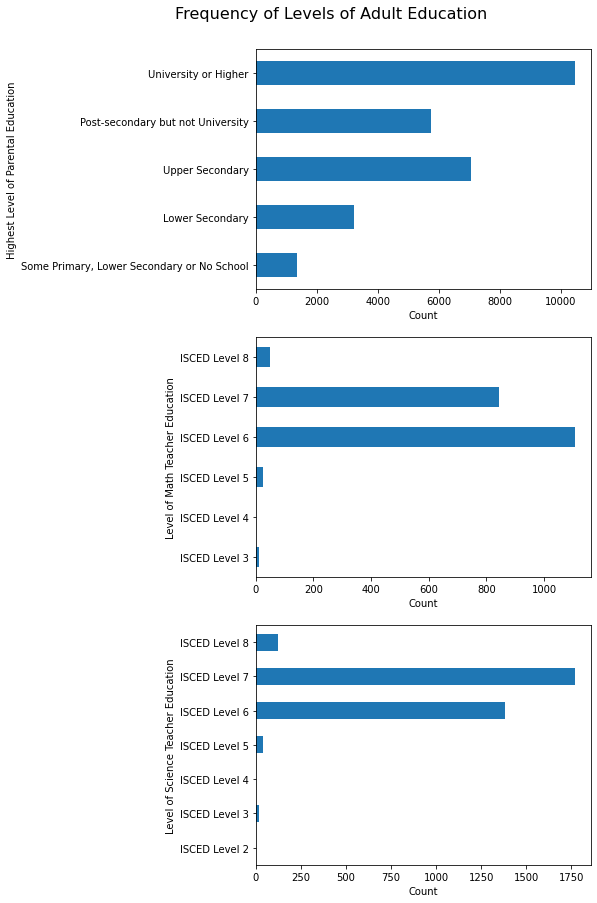

In [419]:
# initialize figure
fig = plt.figure(figsize=(6,15))

# Parental Education
plt.subplot(311)
student['parent_edu_max'].value_counts()[['Some Primary, Lower Secondary or No School','Lower Secondary','Upper Secondary','Post-secondary but not University','University or Higher']].plot(kind='barh');
plt.ylabel('Highest Level of Parental Education')
plt.xlabel('Count')

# Math Teacher Education
plt.subplot(312)
math_teach.edu_level.value_counts().sort_index().plot(kind='barh');
plt.ylabel('Level of Math Teacher Education')
plt.xlabel('Count')

# Science Teacher Education
plt.subplot(313)
sci_teach.edu_level.value_counts().sort_index().plot(kind='barh');
plt.ylabel('Level of Science Teacher Education')
plt.xlabel('Count');

fig.suptitle('Frequency of Levels of Adult Education', fontsize=16, x=0.3, y=.92);

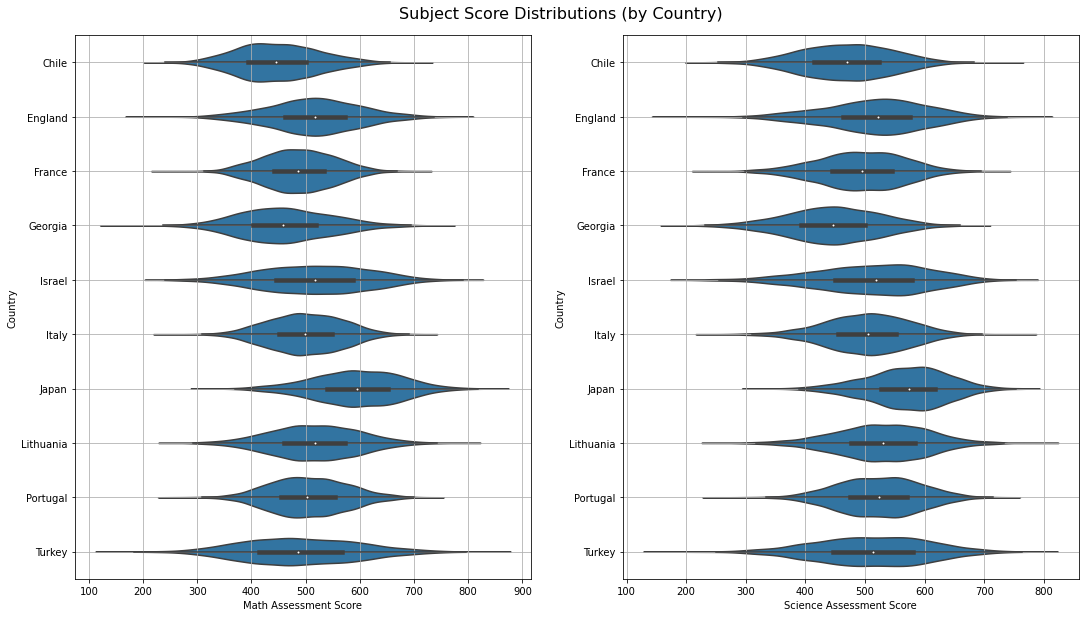

In [445]:
country_dict = country_codes.set_index('IDCNTRY').to_dict()['Country']
student['country_name'] = student['IDCNTRY'].apply(lambda x: country_dict[int(x)])

plt.figure(figsize=(18, 10))

# Plot distribution of math scores by country
plt.subplot(121)
sns.violinplot(data = student, y = 'country_name', x = 'mmat_avg', linestyles = "", color='#1f77b4');
plt.xlabel('Math Assessment Score')
plt.ylabel('Country')
plt.grid(True)

# Plot distribution of science scores by country
plt.subplot(122)
sns.violinplot(data = student, y = 'country_name', x = 'ssci_avg', linestyles = "", color='#1f77b4');
plt.xlabel('Science Assessment Score')
plt.ylabel('Country')
plt.grid(True)

plt.suptitle('Subject Score Distributions (by Country)', fontsize=16, y=0.92);

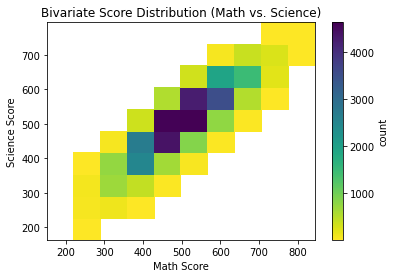

In [462]:
plt.hist2d(data = student, x = 'mmat_avg', y = 'ssci_avg', cmin=10, cmap = 'viridis_r');
plt.colorbar(label = 'count');
plt.xlabel('Math Score');
plt.ylabel('Science Score');
plt.title('Bivariate Score Distribution (Math vs. Science)');

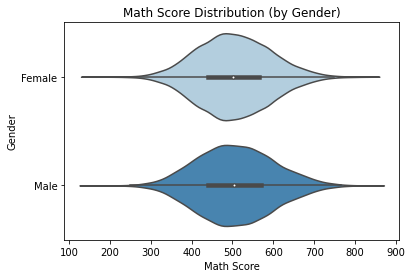

In [486]:
sns.violinplot(data = student, y = 'sex', x = 'mmat_avg', ci = 'sd', palette='Blues');
plt.title('Math Score Distribution (by Gender)');
plt.xlabel('Math Score');
plt.ylabel('Gender');

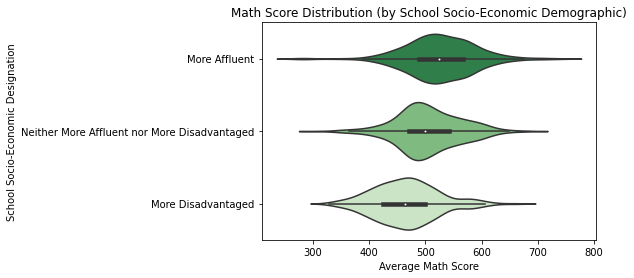

In [489]:
my_order = ['More Disadvantaged','Neither More Affluent nor More Disadvantaged','More Affluent']
my_order.reverse()
sns.violinplot(y = 'socio_background', x = 'mmat_avg', data=school, order=my_order, palette='Greens_r');
plt.title('Math Score Distribution (by School Socio-Economic Demographic)');
plt.xlabel('Average Math Score');
plt.ylabel('School Socio-Economic Designation');